In [1]:
import numpy as np
import pandas as pd
from pandas import json_normalize
import seaborn as sns
import matplotlib.pyplot as plt

import time
import datetime

import json
import os
from dotenv import load_dotenv #pip install python-dotenv

from bs4 import BeautifulSoup
import requests 

from selenium import webdriver 
from selenium.webdriver.common.keys import Keys 
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

import warnings
warnings.filterwarnings("ignore")

# **1. Discogs API** - no ratings, però si genre, style, year, album, length...

List Of Genres On Discogs

https://support.discogs.com/hc/en-us/articles/360005055213-Database-Guidelines-9-Genres-Styles

**Step 1**: comprovar que funciona la meva contrasenya personal (token), ``Response`` ha de ser [200]

In [649]:
url = "https://api.discogs.com/oauth/identity"
headers = {"Authorization": "Discogs token=UwfqmsztxwnfABgQpmhaAsprbUgpOJKGOJSQAqfp"}

response = requests.get(url, headers=headers)
response

<Response [200]>

In [101]:
# comprovar quantes requests he fet i quantes me'n queden

rate_limit = response.headers.get("X-Discogs-Ratelimit")
rate_limit_used = response.headers.get("X-Discogs-Ratelimit-Used")
rate_limit_remaining = response.headers.get("X-Discogs-Ratelimit-Remaining")

print(f"Rate Limit: {rate_limit}")
print(f"Rate Limit Used: {rate_limit_used}")
print(f"Rate Limit Remaining: {rate_limit_remaining}")

Rate Limit: 60
Rate Limit Used: 60
Rate Limit Remaining: 0


**Step 2**: anar a ``Search`` i buscar tots els ``artist`` (o ``release``)

https://www.discogs.com/developers/#page:database,header:database-search

## PROVES

### number of releases for each year (ALL releases, not just albums) 

In [651]:
''' number of releases for each year (ALL releases, not just albums)
1920: 3221
1921: 3004
1922: 3286
1923: 4201
1924: 4425
1925: 4542
1926: 5730
1927: 8424
1928: 9289
1929: 8931
1930: 7663
1931: 5105
1932: 3964
1933: 3746
1934: 3963
1935: 4748
1936: 5146
1937: 5891
1938: 6056
1939: 5952
1940: 6408
1941: 6172
1942: 4435
1943: 3244
1944: 2967
1945: 5287
1946: 8159
1947: 9561
1948: 9263
1949: 11353
1950: 16042
1951: 15592
1952: 17766
1953: 22409
1954: 26821
1955: 33267
1956: 42498
1957: 48515
1958: 60726
1959: 66538
1960: 66306
1961: 67990
1962: 80397
1963: 83654
1964: 91092
1965: 101250
1966: 113577
1967: 120665
1968: 124579
1969: 126602
1970: 129443
1971: 127728
1972: 147641
1973: 152110
1974: 144098
1975: 156613
1976: 164807
1977: 170251
1978: 175504
1979: 173382
1980: 174682
1981: 169318
1982: 171131
1983: 171604
1984: 175795
1985: 177311
1986: 183189
1987: 198754
1988: 212694
1989: 216475
1990: 224114
1991: 224375
1992: 222425
1993: 228141
1994: 251113
1995: 268037
1996: 271230
1997: 270118
1998: 267117
1999: 275081
2000: 281051
2001: 285038
2002: 284177
2003: 289116
2004: 291391
2005: 296256
2006: 303160
2007: 306461
2008: 311422
2009: 311115
2010: 313285
2011: 328114
2012: 346047
2013: 356429
2014: 361632
2015: 363733
2016: 374628
2017: 378863
2018: 383480
2019: 378727
2020: 397605
2021: 370167
2022: 333046
2023: 309072
2024: 237986'''

' number of releases for each year (ALL releases, not just albums)\n1920: 3221\n1921: 3004\n1922: 3286\n1923: 4201\n1924: 4425\n1925: 4542\n1926: 5730\n1927: 8424\n1928: 9289\n1929: 8931\n1930: 7663\n1931: 5105\n1932: 3964\n1933: 3746\n1934: 3963\n1935: 4748\n1936: 5146\n1937: 5891\n1938: 6056\n1939: 5952\n1940: 6408\n1941: 6172\n1942: 4435\n1943: 3244\n1944: 2967\n1945: 5287\n1946: 8159\n1947: 9561\n1948: 9263\n1949: 11353\n1950: 16042\n1951: 15592\n1952: 17766\n1953: 22409\n1954: 26821\n1955: 33267\n1956: 42498\n1957: 48515\n1958: 60726\n1959: 66538\n1960: 66306\n1961: 67990\n1962: 80397\n1963: 83654\n1964: 91092\n1965: 101250\n1966: 113577\n1967: 120665\n1968: 124579\n1969: 126602\n1970: 129443\n1971: 127728\n1972: 147641\n1973: 152110\n1974: 144098\n1975: 156613\n1976: 164807\n1977: 170251\n1978: 175504\n1979: 173382\n1980: 174682\n1981: 169318\n1982: 171131\n1983: 171604\n1984: 175795\n1985: 177311\n1986: 183189\n1987: 198754\n1988: 212694\n1989: 216475\n1990: 224114\n1991: 224375

**Look for the number of releases**

### **MAIN CODE: getting the releases iterating on years, genres and countries**

In [652]:
# album_id_list = []
# artist_list = []
# year_list = []
# album_name_list = []
# genres_list = []
# styles_list = []
# album_length_list = []
# number_of_songs_list = []

# count = 0

# for id in releases_ids:
#     url = f"https://api.discogs.com/releases/{id}"
#     headers = {"Authorization": "Discogs token=UwfqmsztxwnfABgQpmhaAsprbUgpOJKGOJSQAqfp"}
#     response = requests.get(url, headers=headers)
#     data = response.json()

#     # define the data I want to get    
#     album_id = data['id']
#     artist = data['artists'][0]['name']
#     album_name = data['title']
#     year = data['year']
#     genres = data['genres']
#     styles = data['styles']
    
#     count+=1

#     time.sleep(1) # so I don't reach the limit of 60 requests per minute

#     release_type = data['formats'][0]['descriptions']

#     album_id_list.append(album_id)
#     artist_list.append(artist)
#     year_list.append(year)  
#     album_name_list.append(album_name) # I save the albums in a list
#     genres_list.append(genres)
#     styles_list.append(styles)

#     # a more complex information is the total duration of the album, I have to sum the durations of each song
#     number_of_songs = len(data['tracklist'])
#     number_of_songs_list.append(number_of_songs)
#     song_durations = []

#     for song in range(number_of_songs):
#         song_duration = data['tracklist'][song]['duration']
#         minutes = int(song_duration.split(':')[0])
#         seconds = int(song_duration.split(':')[1])
#         song_duration_minutes = minutes + seconds/60
#         song_durations.append(song_duration_minutes)
#     album_length = sum(i for i in song_durations)
#     album_length_list.append(album_length)

#     print(count) # see the number of releases I have requested
#     print(f'{id} - {album_name}') # and I print the albums and their id so I can see them while the code is still running


# df_albums = pd.DataFrame({'album_id': album_id_list
#                             , 'artist': artist_list
#                             , 'year': year_list
#                             , 'album': album_name_list
#                             , 'duration': album_length_list
#                             , 'number_of_songs': number_of_songs_list
#                             , 'genres': genres_list
#                             , 'styles': styles_list
#                             })

In [653]:
# get the number of releases of every genre

url = "https://api.discogs.com/database/search"
headers = {"Authorization": "Discogs token=UwfqmsztxwnfABgQpmhaAsprbUgpOJKGOJSQAqfp"}

years = range(2019,2018, -1)
countries = ['US', 'Spain']
genres = ["Blues", "Brass & Military", "Children's", "Classical", "Electronic", "Folk, World, & Country", "Funk / Soul", "Hip-Hop", "Jazz", "Latin", "Non-Music", "Pop", "Reggae", "Rock", "Stage & Screen"]

# Lists when there are more than 10.000 releases, so I know which ones I have to iterate over style as well
years_iterate_styles_list = []
countries_iterate_styles_list = []
genres_iterate_styles_list = []
releases_iterate_styles_list = []

# Lists when there are less than 10.000 releases
countries_list = []
year_list = []
genres_list = []
styles_list = []
album_id_list = []

count = 0

for year in years:
    for country in countries:
        for genre in genres:
            pages = (response.json()['pagination']['pages'])+1


            for page in range(1,pages):
                # Define parameters for artist search
                params = {
                    "per_page": 100    # Number of results per page (max 100)
                    , 'type': 'release'
                    , 'format': 'album'

                    # items to change
                    , 'genre': genre
                    , 'country': country
                    , 'year': year
                    # , 'style': 
                }

                response = requests.get(url, headers=headers, params=params)
                data = response.json()
                items_number = data['pagination']['items']  # number of items

                time.sleep(1)
                count+=1
                print(count)
                print(f"{year}, {country}, {genre}: {items_number}")

                for i in range(100):
                    # define the data I want to get    
                    country = data['results'][i]['country']
                    year = data['results'][i]['year']
                    genres = data['results'][i]['genre']
                    styles = data['results'][i]['style']
                    album_id = data['results'][i]['id']

                    if items_number < 10000:


                        # save the data in lists
                        countries_list.append(country)
                        year_list.append(year)  
                        genres_list.append(genres)
                        styles_list.append(styles)
                        album_id_list.append(album_id)
                    else:
                        print('More than 10.000 releases, should iterate over styles as well')
                        years_iterate_styles_list.append(year)
                        countries_iterate_styles_list.append(country)
                        genres_iterate_styles_list.append(genre)
                        releases_iterate_styles_list.append(items_number)

KeyError: 'pagination'

In [ ]:
lists = [('countries_list', countries_list)
         , ('year_list', year_list)
         , ('genres_list', genres_list)
         , ('styles_list', styles_list)
         , ('album_id_list', album_id_list)
         ]

for name, lst in lists:
    print(f'{name}: {len(lst)}') # check that all lists have the same length (even though I had make sure with the previous code)

countries_list: 141
year_list: 141
genres_list: 141
styles_list: 141
album_id_list: 141


In [ ]:
response.json()['results'][0]['id']

17625157

In [ ]:
response.json()

{'pagination': {'page': 1,
  'pages': 1,
  'per_page': 100,
  'items': 41,
  'urls': {}},
 'results': [{'country': 'US',
   'year': '2019',
   'format': ['CD', 'Album'],
   'label': ['Not On Label'],
   'type': 'release',
   'genre': ['Classical', 'Brass & Military'],
   'style': [],
   'id': 17493328,
   'barcode': [],
   'user_data': {'in_wantlist': False, 'in_collection': False},
   'master_id': 0,
   'master_url': None,
   'uri': '/The-United-States-Navy-Band-Captain-Kenneth-C-Collins-The-Genius-Of-Paul-Hindemith/release/17493328',
   'catno': 'none',
   'title': 'The United States Navy Band*, Captain Kenneth C. Collins* - The Genius Of Paul Hindemith',
   'thumb': 'https://i.discogs.com/f9xbsn-vPkUQ6WiqHWYV3vRh83wL0fVbxTrZYae-IXk/rs:fit/g:sm/q:40/h:150/w:150/czM6Ly9kaXNjb2dz/LWRhdGFiYXNlLWlt/YWdlcy9SLTE3NDkz/MzI4LTE2MTM3NTk4/NDktNjk4OC5qcGVn.jpeg',
   'cover_image': 'https://i.discogs.com/0QsausCiOPANjoeYrVxx0xq4kWyELEBnOfECgcuNJ3o/rs:fit/g:sm/q:90/h:537/w:600/czM6Ly9kaXNjb2dz/LWR

In [ ]:
years_iterate_styles_list

[]

In [ ]:
countries_iterate_styles_list

[]

In [ ]:
genres_iterate_styles_list

[]

In [ ]:
df_iterate_styles = pd.DataFrame({'year': years_iterate_styles_list, 'country': countries_iterate_styles_list, 'genre': genres_iterate_styles_list, 'releases': releases_iterate_styles_list})
df_iterate_styles

,year,country,genre,releases
0,2019,US,Rock,16937


In [ ]:
df_iterate_styles_old = pd.read_csv('Datasets/df_iterate_styles.csv')
df_iterate_styles_old

,year,country,genre,releases
0,2021,US,Rock,16640
1,2022,US,Rock,16901
2,2023,US,Rock,16341
3,2024,US,Rock,12413
4,2020,US,Electronic,10538
5,2020,US,Rock,16413
6,2019,US,Rock,16937


In [ ]:
df_to_iterate_over_styles = pd.concat([df_iterate_styles, df_iterate_styles_old])
df_to_iterate_over_styles.shape[0]

8

In [ ]:
df_to_iterate_over_styles.duplicated().sum()

1

In [ ]:
df_to_iterate_over_styles = df_to_iterate_over_styles.drop_duplicates()
df_to_iterate_over_styles.shape[0]

7

**Guardo en un df els gèneres per país i any amb més de 10.000 albums**, és a dir, que no els puc agafar de cop i he d'iterar també per ``style``

In [ ]:
df_to_iterate_over_styles

,year,country,genre,releases
0,2019,US,Rock,16937
0,2021,US,Rock,16640
1,2022,US,Rock,16901
2,2023,US,Rock,16341
3,2024,US,Rock,12413
4,2020,US,Electronic,10538
5,2020,US,Rock,16413


In [ ]:
df_to_iterate_over_styles.to_csv('Datasets/df_iterate_styles.csv', index=False)

### **Iterating over genres, same country and year**, per saber una info en concret

In [ ]:
(165000*6)/60/60/24 # número aprox d'hores que trigaré en scrapejar ratings de tots els albums de SputnikMusic

11.458333333333334

In [ ]:
# get the number of releases of every genre

url = "https://api.discogs.com/database/search"
headers = {"Authorization": "Discogs token=UwfqmsztxwnfABgQpmhaAsprbUgpOJKGOJSQAqfp"}

genres = ["Blues", "Classical", "Electronic", "Folk, World, & Country", "Funk / Soul", "Hip-Hop", "Jazz", "Latin", "Pop", "Rock", "Stage & Screen"]

for genre in genres:
    # Define parameters for artist search
    params = {
        "per_page": 100    # Number of results per page (max 100)
        , 'type': 'release'
        , 'format': 'album'
        , 'genre': genre

        # items to change
        , 'country': 'Spain'
        , 'year': 1990
        
        # , 'style': 
    }

    response = requests.get(url, headers=headers, params=params)
    items_number = response.json()['pagination']['items']  # number of items

    print(f"{genre}: {items_number}")

Blues: 69740
Classical: 69740
Electronic: 69740
Folk, World, & Country: 69740
Funk / Soul: 69740
Hip-Hop: 69740
Jazz: 69740
Latin: 69740
Pop: 69740
Rock: 69740
Stage & Screen: 69740


In [177]:
response.json()

{'pagination': {'page': 1,
  'pages': 1,
  'per_page': 100,
  'items': 85,
  'urls': {}},
 'results': [{'country': 'Spain',
   'year': '1990',
   'format': ['CD', 'Album'],
   'label': ['CBS/Sony'],
   'type': 'release',
   'genre': ['Stage & Screen'],
   'style': ['Score'],
   'id': 17253148,
   'barcode': [],
   'user_data': {'in_wantlist': False, 'in_collection': False},
   'master_id': 0,
   'master_url': None,
   'uri': '/Lluis-Llach-La-Forja-De-Un-Rebelde/release/17253148',
   'catno': 'CBS 466793 2',
   'title': 'Lluis Llach - La Forja De Un Rebelde',
   'thumb': '',
   'cover_image': 'https://st.discogs.com/bdd842db545034c49f4b403bf72bd7b2d94cd5de/images/spacer.gif',
   'resource_url': 'https://api.discogs.com/releases/17253148',
   'community': {'want': 0, 'have': 0},
   'format_quantity': 1,
   'formats': [{'name': 'CD', 'qty': '1', 'descriptions': ['Album']}]},
  {'country': 'Spain',
   'year': '1990',
   'format': ['CD', 'Album'],
   'label': ['Ediciones Del Prado',
    'Vi

In [192]:
# get one genre in one year in one country

url = "https://api.discogs.com/database/search"
headers = {"User-Agent": "MyDiscogsApp/1.0", "Authorization": "Discogs token=UwfqmsztxwnfABgQpmhaAsprbUgpOJKGOJSQAqfp"}

# Define parameters for artist search
params = {
    "per_page": 100    # Number of results per page (max 100)
    , 'type': 'master'
    , 'format': 'album'

    # items to change
    , 'country': 'Spain'
    # , 'year': 2023
    , 'genre': 'Rock'
    # , 'style': 
}

response = requests.get(url, headers=headers, params=params)
items_number = response.json()['pagination']['items']  # number of items

print(f"Items: {items_number}")

# response.json()

Items: 8864


In [ ]:
data = response.json()
data

{'pagination': {'page': 1,
  'pages': 2,
  'per_page': 100,
  'items': 139,
  'urls': {'last': 'https://api.discogs.com/database/search?per_page=100&type=release&format=album&country=Worldwide&year=2023&genre=Latin&page=2',
   'next': 'https://api.discogs.com/database/search?per_page=100&type=release&format=album&country=Worldwide&year=2023&genre=Latin&page=2'}},
 'results': [{'country': 'Worldwide',
   'year': '2023',
   'format': ['CD', 'Album'],
   'label': ['Unity Entertainment'],
   'type': 'release',
   'genre': ['Latin'],
   'style': ['Salsa', 'Bolero'],
   'id': 29004910,
   'barcode': ['197188791933'],
   'user_data': {'in_wantlist': False, 'in_collection': False},
   'master_id': 3309658,
   'master_url': 'https://api.discogs.com/masters/3309658',
   'uri': '/release/29004910-Mimy-Succar-Tony-Succar-Mimy-Tony',
   'catno': 'UNI-00003',
   'title': 'Mimy Succar & Tony Succar - Mimy & Tony',
   'thumb': 'https://i.discogs.com/LX4hYbmgyUu_Hmig9u7pXj3AmFbta1nBIAfdpiRoFqs/rs:fit/g

### **Iterating over ``style`` when there are more than 10.000 releases of a genre in a specific country in a given year** (like 2019 US Rock, 16.937 releases)

In [ ]:
# get the number of releases of every genre

url = "https://api.discogs.com/database/search"
headers = {"Authorization": "Discogs token=UwfqmsztxwnfABgQpmhaAsprbUgpOJKGOJSQAqfp"}

genres = ["Blues", "Classical", "Electronic", "Folk, World, & Country", "Funk / Soul", "Hip-Hop", "Jazz", "Pop", "Rock", "Stage & Screen"]

rock_styles = ["Pop Rock", "Punk", "Alternative Rock", "Indie Rock", "Hardcore", "Rock & Roll", "Hard Rock", "Psychedelic Rock", "Black Metal", "Heavy Metal", "Folk Rock", "Experimental", "Prog Rock", "Death Metal", "Garage Rock"]

for genre in genres:  
    # Define parameters
    params = {
        "per_page": 100    # Number of results per page (max 100)
        , 'type': 'release'
        , 'format': 'album'
        , 'genre': genre

        # items to change
        , 'country': 'US'
        , 'year': 2019
        # , 'style': 
    }

    response = requests.get(url, headers=headers, params=params)
    items_number = response.json()['pagination']['items']  # number of items

    if items_number < 10000:
        print(f"{genre}: {items_number}")
    else:
        print(f'{genre}: more than 10000 releases')
        for style in rock_styles:
            # Define parameters
            params = {
                "per_page": 100    # Number of results per page (max 100)
                , 'type': 'release'
                , 'format': 'album'
                , 'genre': genre
                , 'style': style

                # items to change
                , 'country': 'US'
                , 'year': 2019 
            }

            response = requests.get(url, headers=headers, params=params)
            items_number = response.json()['pagination']['items']  # number of items
            print(f"{genre}, {style}: {items_number}")

    # response.json()

Blues: 895
Classical: 1084
Electronic: 9316
Folk, World, & Country: 3601
Funk / Soul: 1506
Hip-Hop: 3701
Jazz: 2409
Pop: 3117
Rock: more than 10000 releases
Rock, Pop Rock: 1274
Rock, Punk: 2625
Rock, Alternative Rock: 1794
Rock, Indie Rock: 2520
Rock, Hardcore: 1250
Rock, Rock & Roll: 367
Rock, Hard Rock: 681
Rock, Psychedelic Rock: 1032
Rock, Black Metal: 977
Rock, Heavy Metal: 801
Rock, Folk Rock: 959
Rock, Experimental: 1135
Rock, Prog Rock: 480
Rock, Death Metal: 1046
Rock, Garage Rock: 542
Stage & Screen: 1102


## 1r per artistes i després els albums de cada artista (not efficient)

### TOTS els artistes

In [70]:
# get the number of releases of every genre

url = "https://api.discogs.com/database/search"
headers = {"Authorization": "Discogs token=UwfqmsztxwnfABgQpmhaAsprbUgpOJKGOJSQAqfp"}

# Define parameters
params = {
    "per_page": 100    # Number of results per page (max 100)
    , 'type': 'artist'
    # , 'format': 'album'
    , 'country': 'Spain'
    # , 'style': 
}

response = requests.get(url, headers=headers, params=params)
data = response.json()
items_number = data['pagination']['items']  # number of items

items_number

    # response.json()

0

In [63]:
url = "https://api.discogs.com/database/search"
headers = {"Authorization": "Discogs token=UwfqmsztxwnfABgQpmhaAsprbUgpOJKGOJSQAqfp"}

conteo = 0
artist_list = []
artist_id_list = []

for page in range(1, 10):
    # Define parameters for artist search
    params = {
        "type": "artist"  # Search for artists
        , "per_page": 100    # Number of results per page (max 100)
        , "page": page          # Start with page 1
    }

    response = requests.get(url, headers=headers, params=params)
    data = response.json()

    for entry in range (100):
        print(f'page: {page}')
        artist = data['results'][entry]['title']
        artist_id = data['results'][entry]['id']

        # if artist_id in data['artist_id'].values:
        #     print('artist already scrapped')
        #     pass
        if response.status_code == 200:
            print('new artist, appending')
            artist_list.append(artist)
            artist_id_list.append(artist_id)
        conteo+=1
        print(f'{conteo} artist_id {artist_id}: {artist}')

page: 1
new artist, appending
1 artist_id 68211: Rick Rubin
page: 1
new artist, appending
2 artist_id 476910: Holland-Dozier-Holland
page: 1
new artist, appending
3 artist_id 386598: Nilesh Patel
page: 1
new artist, appending
4 artist_id 1170513: Norman Seeff
page: 1
new artist, appending
5 artist_id 1069010: Peter Saville (2)
page: 1
new artist, appending
6 artist_id 138572: Todd Rundgren
page: 1
new artist, appending
7 artist_id 12803: George Duke
page: 1
new artist, appending
8 artist_id 1105229: Cream (7)
page: 1
new artist, appending
9 artist_id 499136: Beau Thomas
page: 1
new artist, appending
10 artist_id 254874: Garry Tallent
page: 1
new artist, appending
11 artist_id 275980: Mike McCready
page: 1
new artist, appending
12 artist_id 277864: Peter James
page: 1
new artist, appending
13 artist_id 3898: Joy Division
page: 1
new artist, appending
14 artist_id 321966: Louis Johnson
page: 1
new artist, appending
15 artist_id 252102: Creedence Clearwater Revival
page: 1
new artist, app

In [59]:
data

{'pagination': {'page': 1,
  'pages': 100,
  'per_page': 100,
  'items': 9395066,
  'urls': {'last': 'https://api.discogs.com/database/search?type=artist&per_page=100&page=100',
   'next': 'https://api.discogs.com/database/search?type=artist&per_page=100&page=2'}},
 'results': [{'id': 68211,
   'type': 'artist',
   'user_data': {'in_wantlist': False, 'in_collection': False},
   'master_id': None,
   'master_url': None,
   'uri': '/artist/68211-Rick-Rubin',
   'title': 'Rick Rubin',
   'thumb': 'https://i.discogs.com/jdvgA2glKZjNk2CL8znBMHq0KZPVkMRq-obVTsdYWNk/rs:fit/g:sm/q:40/h:150/w:150/czM6Ly9kaXNjb2dz/LWRhdGFiYXNlLWlt/YWdlcy9BLTY4MjEx/LTE2MDI1ODgyNjAt/MjkyNi5qcGVn.jpeg',
   'cover_image': 'https://i.discogs.com/R5nqhjRHq0zt1nymtUq5vR7SxgRGVXKmmVe1SaswZ4Y/rs:fit/g:sm/q:90/h:762/w:600/czM6Ly9kaXNjb2dz/LWRhdGFiYXNlLWlt/YWdlcy9BLTY4MjEx/LTE2MDI1ODgyNjAt/MjkyNi5qcGVn.jpeg',
   'resource_url': 'https://api.discogs.com/artists/68211'},
  {'id': 476910,
   'type': 'artist',
   'user_data': 

In [65]:
# the new df with the artists I just scrapped
df_artists = pd.DataFrame({'artist_id': artist_id_list, 'artist': artist_list})
df_artists.shape

(900, 2)

In [66]:
df_artists

,artist_id,artist
0,68211,Rick Rubin
1,476910,Holland-Dozier-Holland
2,386598,Nilesh Patel
3,1170513,Norman Seeff
4,1069010,Peter Saville (2)
...,...,...
895,562335,Tamra Rosanes
896,706600,Rida Johnson Young
897,437740,Chris Kane
898,2109303,Neil Bellingham


In [ ]:
# I load the df with all the artists that I have already scrapped
data_artists_already_scrapped = pd.read_csv('Datasets/artists.csv')
data_artists_already_scrapped.shape

(8583, 2)

In [ ]:
# do the concat of both df
artists = pd.concat([data_artists_already_scrapped, df_artists])
artists.shape

(12478, 2)

In [ ]:
artists.sort_values('artist_id')

,artist_id,artist
83,318,808 State
50,754,Lenny Dee
505,1103,Infiniti
819,1231,Vapourspace
1098,1348,MikeroBenics
...,...,...
1638,12965964,Ciaran Fahy
1639,12965967,Mike Ensor
738,12976704,Nuno Souteiro
5424,12981561,Natalia Handoga


In [ ]:
artists.duplicated().sum()

2578

In [ ]:
artists.drop_duplicates(inplace=True)
artists.shape

(9900, 2)

In [ ]:
# export the dataset to save it 
artists.to_csv('Datasets/artists.csv', index=False)

In [ ]:
artists

,artist_id,artist
0,68211,Rick Rubin
1,476910,Holland-Dozier-Holland
2,386598,Nilesh Patel
3,1170513,Norman Seeff
4,1069010,Peter Saville (2)
...,...,...
3890,3604780,Marcoso Oliva
3891,4759561,Török József
3892,2203813,Vittorio Annona (2)
3893,1430063,Argon Sphere


In [ ]:
'Rick Rubin' in artists['artist'].values

True

**Així sembla que puc treure tots els artistes**

### Albums de cada artista individualment

**Get**: ``country``, ``year``, ``genre``, ``style``, ``id``, ``title``

**Step 3**: agafar el ``id`` de cada artista

In [ ]:
response.json()['results'][0]['id']

403992

In [ ]:
url = "https://api.discogs.com/artists/3793643"
# headers = {"Authorization": "Discogs token=UwfqmsztxwnfABgQpmhaAsprbUgpOJKGOJSQAqfp"}

response = requests.get(url, headers=headers)
items = response.json()['pagination']['items']
print(f'Number of releases: {items}')

KeyError: 'pagination'

**Step 4**: entrar a la pàgina de l'artista i treure les ``releases``

In [ ]:
url = "https://api.discogs.com/artists/252102/releases"
# headers = {"Authorization": "Discogs token=UwfqmsztxwnfABgQpmhaAsprbUgpOJKGOJSQAqfp"}

response = requests.get(url, headers=headers)
items = response.json()['pagination']['items']
print(f'Number of releases: {items}')

Number of releases: 1626


In [ ]:
response.json()['releases'][0]['format']

'7", Jukebox'

In [ ]:
response.json()['releases'][1]['main_release']

11286641

In [ ]:
url = "https://api.discogs.com/artists/252102/releases"
headers = {"Authorization": "Discogs token=UwfqmsztxwnfABgQpmhaAsprbUgpOJKGOJSQAqfp"}
params = {
    "per_page": 100    # Number of results per page (max 100)
    # "page": 1          # Start with page 1
}

response = requests.get(url, headers=headers, params=params)

print(f'Pages of releases of this artist: {response.json()['pagination']['pages']}')

Pages of releases of this artist: 17


**Treure tots els ``id`` de les releases (albums, singles, etc)**

In [ ]:
url = "https://api.discogs.com/artists/252102/releases"

releases_ids = []
pages = (response.json()['pagination']['pages'])+1
conteo = 0

for page in range(1,pages):
    # Define parameters for artist search
    params = {
        "type": "artist",  # Search for artists
        "per_page": 100,    # Number of results per page (max 100)
        "page": page          # Start with page 1
    }

    response = requests.get(url, headers=headers, params=params)

    try:
        for i in range(100):
            resource_url = response.json()['releases'][i]['resource_url']
            if 'releases' in resource_url:
                release_id = response.json()['releases'][i]['id']   
                releases_ids.append(release_id)
            else:
                main_release = response.json()['releases'][i]['main_release']   
                releases_ids.append(main_release)
    except:
        break

In [ ]:
len(releases_ids)

1626

In [ ]:
df_releases_ids = pd.DataFrame({'release_id': releases_ids})
df_releases_ids

,release_id
0,15208590
1,11286641
2,2443446
3,2754978
4,1520699
...,...
1617,10258341
1618,15541339
1619,9480517
1620,18148519


In [ ]:
df_releases_ids.duplicated().sum()

0

In [ ]:
url = f"https://api.discogs.com/releases/5617835"
headers = {"Authorization": "Discogs token=UwfqmsztxwnfABgQpmhaAsprbUgpOJKGOJSQAqfp"}
response = requests.get(url, headers=headers)
data = response.json()
data

{'id': 5617835,
 'status': 'Accepted',
 'year': 2010,
 'resource_url': 'https://api.discogs.com/releases/5617835',
 'uri': 'https://www.discogs.com/release/5617835-Mine-Un-Brindis-Pel-Nen-Androide',
 'artists': [{'name': 'Mine!',
   'anv': '',
   'join': '',
   'role': '',
   'tracks': '',
   'id': 3793643,
   'resource_url': 'https://api.discogs.com/artists/3793643',
   'thumbnail_url': 'https://i.discogs.com/MAVas5upCPFFhU76dtBVFVMs27IZXz7rUhcMmRLAHvg/rs:fit/g:sm/q:90/h:400/w:600/czM6Ly9kaXNjb2dz/LWRhdGFiYXNlLWlt/YWdlcy9BLTM3OTM2/NDMtMTM5ODEwNTAx/NS01NzUwLmpwZWc.jpeg'}],
 'artists_sort': 'Mine!',
 'labels': [{'name': 'Música Global Discogràfica',
   'catno': '78810MG',
   'entity_type': '1',
   'entity_type_name': 'Label',
   'id': 58748,
   'resource_url': 'https://api.discogs.com/labels/58748',
   'thumbnail_url': 'https://i.discogs.com/y1s1Yue2ycxEriuOJekNSqaeWiPoFxGop5oqbfdlmps/rs:fit/g:sm/q:90/h:200/w:200/czM6Ly9kaXNjb2dz/LWRhdGFiYXNlLWlt/YWdlcy9MLTU4NzQ4/LTEyNTk4NTA2OTcu/anBlZw

### Info de cada album dins de la seva pàg (com ``number_of_songs``)

**Step 5**: agafar el ``id`` de cada release i entrar a la seva web

In [ ]:
url = f"https://api.discogs.com/releases/2754978"
headers = {"Authorization": "Discogs token=UwfqmsztxwnfABgQpmhaAsprbUgpOJKGOJSQAqfp"}
response = requests.get(url, headers=headers)
data = response.json()
data

{'id': 2754978,
 'status': 'Accepted',
 'year': 1968,
 'resource_url': 'https://api.discogs.com/releases/2754978',
 'uri': 'https://www.discogs.com/release/2754978-Creedence-Clearwater-Revival-Creedence-Clearwater-Revival',
 'artists': [{'name': 'Creedence Clearwater Revival',
   'anv': '',
   'join': '',
   'role': '',
   'tracks': '',
   'id': 252102,
   'resource_url': 'https://api.discogs.com/artists/252102',
   'thumbnail_url': 'https://i.discogs.com/4UWkHgZNJPbO9PRK2vX9aCuGfUv83dMqWV4MnkDrYnw/rs:fit/g:sm/q:90/h:282/w:292/czM6Ly9kaXNjb2dz/LWRhdGFiYXNlLWlt/YWdlcy9BLTI1MjEw/Mi0xMzIzMjk4NDM2/LmpwZWc.jpeg'}],
 'artists_sort': 'Creedence Clearwater Revival',
 'labels': [{'name': 'Fantasy',
   'catno': '8382',
   'entity_type': '1',
   'entity_type_name': 'Label',
   'id': 1329,
   'resource_url': 'https://api.discogs.com/labels/1329',
   'thumbnail_url': 'https://i.discogs.com/KwYdQ8mcJTIXQIivVkunwn2gOr2WQy_QV64ou8GUXOE/rs:fit/g:sm/q:90/h:313/w:250/czM6Ly9kaXNjb2dz/LWRhdGFiYXNlLWlt/YWd

Entrar a la web de cada album per separat (amb el ``id``) i treure la info d'allà: ``num_of_songs``, ``artist`` (name), ``album name`` (title), ``song name`` (song name), ``duration`` (of the song)

In [ ]:
data['id']

2754978

In [ ]:
data['artists'][0]['name']

'Creedence Clearwater Revival'

In [ ]:
data['title']

'Creedence Clearwater Revival'

In [ ]:
data['year']

1968

In [ ]:
data['genres']

['Rock']

In [ ]:
data['styles']

['Rock & Roll', 'Southern Rock', 'Classic Rock', 'Psychedelic Rock']

In [ ]:
song_duration = data['tracklist'][0]['duration']
song_duration

'4:25'

In [ ]:
minutes = int(song_duration.split(':')[0])
seconds = int(song_duration.split(':')[1])
song_duration_minutes = minutes + seconds/60
song_duration_minutes

4.416666666666667

In [ ]:
prova = [4, 5.2]
total = sum(i for i in prova)
total

9.2

In [ ]:
number_of_songs = len(data['tracklist'])
song_durations = []

for song in range(number_of_songs):
    song_duration = data['tracklist'][song]['duration']
    minutes = int(song_duration.split(':')[0])
    seconds = int(song_duration.split(':')[1])
    song_duration_minutes = minutes + seconds/60
    song_durations.append(song_duration_minutes)

'0:32:55'

In [ ]:
album_length

NameError: name 'album_length' is not defined

In [ ]:
number_of_songs

8

In [ ]:
# albums_list = []
# ids_revised = []

for id in ids_to_revise:
    url = f"https://api.discogs.com/releases/{id}"
    headers = {"Authorization": "Discogs token=UwfqmsztxwnfABgQpmhaAsprbUgpOJKGOJSQAqfp"}
    response = requests.get(url, headers=headers)
    release_type = response.json()['formats'][0]['descriptions']

    try:
        if response.status_code == 200:
            if id in ids_revised:
                print(f'album already scraped, with id = {id}')
                pass
            else:
                ids_revised.append(id)
                if 'Album' in release_type:
                    title = response.json()['title']
                    if title in albums_list:
                        print(f"'{title}' already scraped, with id = {id}")
                        pass
                    else:
                        albums_list.append(title)
                        print(f'{id}: {title}')
                else:
                    pass
        else: 
            print("Rate limit exceeded. Waiting...")
            time.sleep(60)
            continue 
    except response.status_code == 429:
        print("Rate limit exceeded. Waiting...")
        time.sleep(60)
        if 'Album' in release_type:
            title = response.json()['title']
        if title in albums_list:
            pass
        else:
            albums_list.append(title)
            print(title)

albums_list

album already scraped, with id = 3403550
1148753: The Royal Albert Hall Concert


JSONDecodeError: Expecting value: line 2 column 1 (char 1)

Falten, que puc treure a RYM: ``album_rating``, ``descriptors``, ``reviews`` (NLP), ``album_language``

In [ ]:
releases_ids

[15208590,
 11286641,
 2443446,
 2754978,
 1520699,
 10078734,
 3516173,
 3516189,
 6651386,
 8487974,
 8553272,
 10049341,
 10054023,
 15709745,
 3379690,
 2005991,
 11947404,
 6925842,
 9088976,
 6844556,
 6627305,
 3996043,
 1761102,
 680968,
 1132211,
 1337000,
 2151651,
 1331703,
 1934679,
 3549149,
 6117582,
 7996095,
 8539988,
 10717609,
 11477748,
 12862962,
 14141751,
 24870449,
 5374659,
 573252,
 2135761,
 2992968,
 2802209,
 10053978,
 10049413,
 10053930,
 2739233,
 6502987,
 6958504,
 4615734,
 3549158,
 498774,
 2509346,
 1018597,
 2232743,
 3516273,
 5655277,
 5864622,
 7900758,
 14793201,
 14845683,
 3171737,
 5890001,
 6074117,
 1750658,
 4694367,
 12341497,
 17362429,
 25210789,
 26486414,
 413743,
 1178161,
 9991617,
 9148695,
 1774522,
 2210218,
 11200462,
 4328550,
 8674215,
 15879708,
 7713835,
 11200374,
 10864725,
 1700702,
 2465976,
 3235931,
 12730229,
 22103731,
 2544700,
 12952052,
 13506680,
 7288203,
 3713962,
 10612138,
 5780494,
 7806841,
 8010242,
 129

## Codi treient tots els albums primer (no artistes) iterating over years, countries and genres

In [ ]:
# get the number of releases of every genre

url = "https://api.discogs.com/database/search"
headers = {"Authorization": "Discogs token=UwfqmsztxwnfABgQpmhaAsprbUgpOJKGOJSQAqfp"}

# Lists when there are less than 10.000 releases
album_id_list = []
titles_list = []
countries_list = []
year_list = []
genres_list = []
styles_list = []

# Lists when there are more than 10.000 releases, so I know which ones I have to iterate over style as well
years_iterate_styles_list = []
countries_iterate_styles_list = []
genres_iterate_styles_list = []
releases_iterate_styles_list = []

count = 0

years = range(2024, 1960, -1)
countries = ['US']
music_genres = ["Blues", "Electronic", "Folk, World, & Country", "Funk / Soul", "Hip-Hop", "Jazz", "Latin", "Pop", "Reggae", "Rock"]
rock_styles = ["Pop Rock", "Punk", "Alternative Rock", "Indie Rock", "Hardcore", "Rock & Roll", "Hard Rock", "Psychedelic Rock", "Black Metal",
               "Heavy Metal", "Folk Rock", "Experimental", "Prog Rock", "Death Metal", "Garage Rock"]

for year in years:
    for country in countries:
        for genre in music_genres:

            # Define parameters for artist search
            params = {
                "per_page": 100    # Number of results per page (max 100)
                , "page": 1 
                , 'type': 'release'
                , 'format': 'album'

                # items to change
                , 'genre': 'Rock'
                , 'country': country
                , 'year': year
            }
            
            response = requests.get(url, headers=headers, params=params)
            data = response.json()
            items_number = data['pagination']['items']  # number of items
            print(f"{year}, {country}, {genre}: {items_number}")

            count+=1
            print(count)
            time.sleep(1)
            
            if items_number < 10000:

                pages = (data['pagination']['pages'])
                
                for page in range(1,pages+1):
                    params["page"] = page
                    params["sort"] = "title"
                    params["sort_order"] = "asc"
                    
                    time.sleep(1)
                    print(f'Page: {page}')
                    response = requests.get(url, headers=headers, params=params)
                    data = response.json()

                    for i in range(len(data['results'])):
                        data_release = data['results'][i]

                        # define the data I want to get 
                        album_id = data_release['id']  
                        title = data_release['title']                     
                        country_name = data_release['country']
                        year = data_release['year']
                        genres = data_release['genre']
                        styles = data_release['style']

                        # Splitting the genres and styles (ChatGPT)
                        genres = ", ".join(data_release.get('genre', []))
                        styles = ", ".join(data_release.get('style', []))

                        album_id_list.append(album_id)
                        titles_list.append(title)
                        countries_list.append(country_name)
                        year_list.append(year)  
                        genres_list.append(genres)
                        styles_list.append(styles)

            else:
                print(f"{year}, {country}, {genre}: {items_number}")
                print('More than 10.000 releases, should iterate over styles as well')
                years_iterate_styles_list.append(year)
                countries_iterate_styles_list.append(country)
                genres_iterate_styles_list.append(genre)
                releases_iterate_styles_list.append(items_number)

2024, US, Blues: 12517
1
2024, US, Blues: 12517
More than 10.000 releases, should iterate over styles as well
2024, US, Electronic: 12517
2
2024, US, Electronic: 12517
More than 10.000 releases, should iterate over styles as well
2024, US, Folk, World, & Country: 12517
3
2024, US, Folk, World, & Country: 12517
More than 10.000 releases, should iterate over styles as well
2024, US, Funk / Soul: 12517
4
2024, US, Funk / Soul: 12517
More than 10.000 releases, should iterate over styles as well
2024, US, Hip-Hop: 12517
5


KeyboardInterrupt: 

## **ROCK ALBUMS** - Though I can get ratings mostly from rock artists in Sputnik

In [ ]:
# rock_styles = ["Pop Rock", "Punk", "Alternative Rock", "Indie Rock", "Hardcore", "Rock & Roll", "Hard Rock", "Psychedelic Rock"
#               , "Black Metal", "Heavy Metal", "Folk Rock", "Experimental", "Prog Rock", "Death Metal", "Garage Rock"]

In [2]:
url = "https://api.discogs.com/database/search"
headers = {"User-Agent": "MyDiscogsApp/1.0", "Authorization": "Discogs token=UwfqmsztxwnfABgQpmhaAsprbUgpOJKGOJSQAqfp"}
response = requests.get(url, headers=headers)
response

<Response [200]>

### Info of a single master

In [67]:
url = "https://api.discogs.com/masters/3599069"
headers = {"User-Agent": "MyDiscogsApp/1.0", "Authorization": "Discogs token=UwfqmsztxwnfABgQpmhaAsprbUgpOJKGOJSQAqfp"}
response = requests.get(url, headers=headers)
data = response.json()

data['title']

'Red Dirt'

In [68]:
data

{'id': 3599069,
 'main_release': 27187458,
 'most_recent_release': 31051829,
 'resource_url': 'https://api.discogs.com/masters/3599069',
 'uri': 'https://www.discogs.com/master/3599069-Last-Quokka-Red-Dirt',
 'versions_url': 'https://api.discogs.com/masters/3599069/versions',
 'main_release_url': 'https://api.discogs.com/releases/27187458',
 'most_recent_release_url': 'https://api.discogs.com/releases/27187458',
 'num_for_sale': 1,
 'lowest_price': 30.5,
 'images': [{'type': 'secondary',
   'uri': 'https://i.discogs.com/pLxBQYiSR0vCcPXEHSAWNcTdKl6LmTFyQSUe-Igzy_8/rs:fit/g:sm/q:90/h:379/w:400/czM6Ly9kaXNjb2dz/LWRhdGFiYXNlLWlt/YWdlcy9SLTI3MTg3/NDU4LTE2ODUwMjg1/OTUtNzEyMy5qcGVn.jpeg',
   'resource_url': 'https://i.discogs.com/pLxBQYiSR0vCcPXEHSAWNcTdKl6LmTFyQSUe-Igzy_8/rs:fit/g:sm/q:90/h:379/w:400/czM6Ly9kaXNjb2dz/LWRhdGFiYXNlLWlt/YWdlcy9SLTI3MTg3/NDU4LTE2ODUwMjg1/OTUtNzEyMy5qcGVn.jpeg',
   'uri150': 'https://i.discogs.com/z6Vezb7oT6oirn9LztDDVUvHPVkTQLb0VGqWc31ojJI/rs:fit/g:sm/q:40/h:150

In [ ]:
data['artists'][0]['name']

'Various'

In [8]:
data['artists'][0]['id']

194

In [12]:
# artist = data['artists'][0]['name']
# title = data['title']
year = data['year']                 
# genres = data['genres']
# styles = data['styles']
year

2007

**RELEASES**

In [ ]:
url = "https://api.discogs.com/releases/28576105"
headers = {"User-Agent": "MyDiscogsApp/1.0", "Authorization": "Discogs token=UwfqmsztxwnfABgQpmhaAsprbUgpOJKGOJSQAqfp"}
response = requests.get(url, headers=headers)
data = response.json()

data['title']

'Nadie Sabe Lo Que Va A Pasar Mañana'

In [ ]:
data['country']

'Worldwide'

In [ ]:
data['formats'][0]['descriptions']

['AAC', 'Album']

### Info of a single artist

In [66]:
url = "https://api.discogs.com/artists/8862415"
headers = {"User-Agent": "MyDiscogsApp/1.0", "Authorization": "Discogs token=UwfqmsztxwnfABgQpmhaAsprbUgpOJKGOJSQAqfp"}
response = requests.get(url, headers=headers)
data = response.json()

data

{'name': 'Zero Again',
 'id': 8862415,
 'resource_url': 'https://api.discogs.com/artists/8862415',
 'uri': 'https://www.discogs.com/artist/8862415-Zero-Again',
 'releases_url': 'https://api.discogs.com/artists/8862415/releases',
 'images': [{'type': 'primary',
   'uri': 'https://i.discogs.com/PHeUQbewbvQbDY7L4T2yF3dpLPvWUHomETB7rU1ueZQ/rs:fit/g:sm/q:90/h:545/w:600/czM6Ly9kaXNjb2dz/LWRhdGFiYXNlLWlt/YWdlcy9BLTg4NjI0/MTUtMTYxNDQzMTM4/MS01NjY1LmpwZWc.jpeg',
   'resource_url': 'https://i.discogs.com/PHeUQbewbvQbDY7L4T2yF3dpLPvWUHomETB7rU1ueZQ/rs:fit/g:sm/q:90/h:545/w:600/czM6Ly9kaXNjb2dz/LWRhdGFiYXNlLWlt/YWdlcy9BLTg4NjI0/MTUtMTYxNDQzMTM4/MS01NjY1LmpwZWc.jpeg',
   'uri150': 'https://i.discogs.com/fwVLRXtheYtXoN4CmZ8EJz1RHk623xe8V1DUXfRZ6DU/rs:fit/g:sm/q:40/h:150/w:150/czM6Ly9kaXNjb2dz/LWRhdGFiYXNlLWlt/YWdlcy9BLTg4NjI0/MTUtMTYxNDQzMTM4/MS01NjY1LmpwZWc.jpeg',
   'width': 600,
   'height': 545}],
 'profile': 'Hardcore punk band from South Wales.',
 'urls': ['https://zeroagain.bandcamp.com'],
 '

In [ ]:
data['profile']

''

### **``master_id = 0``**

In [ ]:
url = "https://api.discogs.com/database/search"
headers = {"User-Agent": "MyDiscogsApp/1.0", "Authorization": "Discogs token=UwfqmsztxwnfABgQpmhaAsprbUgpOJKGOJSQAqfp"}

# Define parameters for artist search
params = {
    "per_page": 100    # Number of results per page (max 100)
    , "page": 1 
    , 'type': 'release'
    , 'format': 'album'
    , 'sort': 'title'
    , 'sort_order': 'asc'
    , 'master_id': 0

    # items to change
    , 'genre': 'Rock'
    , 'country': "UK"
    , 'year': 
    # , 'style': "Prog Rock"
}

response = requests.get(url, headers=headers, params=params)
data = response.json()

data['pagination']['items']

284

In [11]:
# printing the albums where master_id = 0
for i in range(len(data['results'])):
    print(data['results'][i]['title'])

Clark-Hutchinson - A=MH²
Procol Harum - A Salty Dog
Bakerloo - Bakerloo
Bakerloo - Bakerloo
Bakerloo - Bakerloo
Bakerloo - Bakerloo
Deep Purple - Deep Purple
Deep Purple - Deep Purple
Genesis - From Genesis To Revelation
Harsh Reality (4) - Heaven And Hell
Harsh Reality (4) - Heaven And Hell
Harsh Reality (4) - Heaven And Hell
Harsh Reality (4) - Heaven And Hell
King Crimson - In The Court Of The Crimson King (An Observation By King Crimson)
King Crimson - In The Court Of The Crimson King (An Observation By King Crimson)
Traffic - Last Exit
Jody Grind - One Step On
Gordon Giltrap - Portrait
Rare Bird - Rare Bird
Jan Dukes De Grey - Sorcerers
Pink Floyd - Soundtrack From The Film "More"
The Pink Floyd* - Soundtrack From The Film "More"
Jethro Tull - Stand Up
Jethro Tull - Stand Up
Jethro Tull - Stand Up
Jethro Tull - Stand Up
Don Shinn - Temples With Prophets
Colosseum - Those Who Are About To Die, Salute You
Colosseum - Those Who Are About To Die, Salute You


In [13]:
data['results'][0]['id']

8597228

**SUPER CODI**

In [120]:
url_search = "https://api.discogs.com/database/search"
headers = {"User-Agent": "MyDiscogsApp", "Authorization": "Discogs token=UwfqmsztxwnfABgQpmhaAsprbUgpOJKGOJSQAqfp"}

df_masters_scrapped = pd.read_csv('Datasets/df_masters.csv')

# rock_styles = ["Pop Rock", "Punk", "Alternative Rock", "Indie Rock", "Hardcore", "Rock & Roll", "Hard Rock", "Psychedelic Rock"
#               , "Black Metal", "Heavy Metal", "Folk Rock", "Experimental", "Prog Rock", "Death Metal", "Garage Rock"]

# create empty lists
artist_id_list = []
artists_list = []
titles_list = []
years_list = []
release_countries_list = []
album_length_list = []
tracks_list = []
release_type_list = []
genres_list = []
styles_list = []
master_id_new_list = []
artist_profile_list = []
main_release_id_list = []

attempts = 0
scrapped = 0
start_year = 2000

for year in range(start_year, start_year-1, -1):
    print(f'Year: {year}')

    # Define parameters for album search
    params = {
        "type": "release"  # Search for masters
        , "format": "album"           # just search for albums
        , "per_page": 100    # Number of results per page (max 100)
        , "page": 1          # Start with page 1
        , 'country': 'UK'
        , 'master_id': 0
        , "year": year
        , 'genre': 'Rock'
    }

    response1 = requests.get(url_search, headers=headers, params=params)
    time.sleep(1)
    data1 = response1.json()

    items = data1['pagination']['items']
    print(f'Items: {items} releases')

    pages = data1['pagination']['pages']+1
    
    for page in range(1, pages):
        print(f'------------ Page: {page} of {pages-1}, {year} -------------')

        params['page'] = page     # change pages
        response2 = requests.get(url_search, headers=headers, params=params)
        data2 = response2.json()

        for id in range(len(data2['results'])):
            try:
                attempts+=1
                time.sleep(1)

                release_id = data2['results'][id]['id']

                url_release = f"https://api.discogs.com/releases/{release_id}"
                response3 = requests.get(url_release, headers=headers)
                time.sleep(1)
                data3 = response3.json()
                artist = data3['artists'][0]['name']

                if artist == 'Various':
                        print(f'{attempts} attempts - {scrapped} scrapped - {((page-1)*100)+id+1}/{items} - release_id {release_id}: Compilation') 
                        continue   # I don't want compilations
                else:
                # define the data I want to get
                    title = data3['title']
                    release_year = data3['year']                
                    genres = data3['genres']
                    styles = data3['styles']

                # a more complex information is the total duration of the album, I have to sum the durations of each song
                    number_of_songs = len(data3['tracklist'])
                    song_durations = []

                    for song in range(number_of_songs):
                        song_duration = data3['tracklist'][song]['duration']
                        try:
                            minutes = int(song_duration.split(':')[0])
                            seconds = int(song_duration.split(':')[1])
                            song_duration_minutes = minutes + seconds/60
                            song_durations.append(song_duration_minutes)
                        except:
                            pass
                        album_length = round(sum(i for i in song_durations), 2)

                    artist_id = data3['artists'][0]['id']

                # define the data I want to get
                    release_country = data3['country']
                    release_type = data3['formats'][0]['descriptions']

                # artist page
                    url = f"https://api.discogs.com/artists/{artist_id}"
                    time.sleep(1)
                    response5 = requests.get(url, headers=headers)
                    data5 = response5.json()

                # define the data I want to get
                    try:
                        artist_profile = data5['profile']
                    except:
                        artist_profile = np.nan
                        pass

                # save the info in the lists
                    artist_id_list.append(str(artist_id))
                    artists_list.append(artist)
                    titles_list.append(title)
                    years_list.append(release_year)
                    genres_list.append(genres)
                    styles_list.append(styles)
                    master_id_new_list.append(np.nan)
                    album_length_list.append(album_length)
                    tracks_list.append(number_of_songs)
                    release_countries_list.append(release_country)
                    release_type_list.append(release_type)
                    main_release_id_list.append(release_id)

                    if artist_profile == '':
                        artist_profile_list.append(np.nan)
                    else:
                        artist_profile_list.append(artist_profile)

                    scrapped+=1

                # list lengths
                    lists = [artist_id_list, main_release_id_list, master_id_new_list, release_countries_list, artists_list, titles_list, album_length_list
                            , tracks_list, release_type_list, genres_list, styles_list, artist_profile_list, years_list]

                # Check if all lists have the same length
                    lengths = [len(lst) for lst in lists]
                    if len(set(lengths)) != 1:
                        print("Lengths are not the same.")
                        break # stop the loop, I won't be able to store the data if I have one value missing

                    print(f'{attempts} attempts - {scrapped} scrapped - {((page-1)*100)+id+1}/{items} - release_id {release_id}: {artist} - {title}')
                    time.sleep(1)
            except:
                print(f'{attempts} attempts - {scrapped} scrapped - {((page-1)*100)+id+1}/{items} - release_id {release_id}: {artist} - {title} - Album not found')
                continue    # sometimes it crashes for some unknown reason, so I skip this album and continue

Year: 2000
Items: 748 releases
------------ Page: 1 of 8, 2000 -------------
1 attempts - 1 scrapped - 1/748 - release_id 1997723: The Fall - Live In Cambridge 1988
2 attempts - 2 scrapped - 2/748 - release_id 2652963: Thea Gilmore - The Lipstick Conspiracies
3 attempts - 3 scrapped - 3/748 - release_id 3664218: The Tubes - Infomercial: How To Become Tubular
4 attempts - 4 scrapped - 4/748 - release_id 3646762: The Unknown (25) - Pop Art
5 attempts - 5 scrapped - 5/748 - release_id 8705558: The Bopshack Stompers - Meteor
6 attempts - 6 scrapped - 6/748 - release_id 7608043: Charlie Feathers - 'Live' In London
7 attempts - 7 scrapped - 7/748 - release_id 529871: Formula One - Full Circle
8 attempts - 8 scrapped - 8/748 - release_id 10035395: Skooshny - Water 
9 attempts - 9 scrapped - 9/748 - release_id 3588293: Krom Lek - Psychedelic Dot Krom
10 attempts - 10 scrapped - 10/748 - release_id 4692219: Nigel Stonier - English Ghosts
11 attempts - 11 scrapped - 11/748 - release_id 2169956: 

#### Continue

In [ ]:
df_masters_id0 = pd.DataFrame({'artist_id': artist_id_list
                        , 'master_id': master_id_new_list
                        , 'main_release_id': main_release_id_list
                        , 'release_country': release_countries_list
                        , 'artist': artists_list
                        , 'title': titles_list
                        , 'year': years_list
                        , 'album_length': album_length_list
                        , 'tracks': tracks_list
                        , 'release_type': release_type_list
                        , 'genres': genres_list
                        , 'styles': styles_list
                        , 'artist_profile': artist_profile_list
                        })
df_masters_id0.shape

(703, 13)

In [122]:
print(f'{df_masters_id0.shape[0]} releases\n{df_masters_id0.artist.nunique()} different artists')

703 releases
600 different artists


In [123]:
df_masters_id0

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
0,2228,NaN,1997723,UK,The Fall,Live In Cambridge 1988,2000,65.97,15,[Album],[Rock],"[Alternative Rock, Indie Rock]","Post-punk band from Greater Manchester, UK. 19..."
1,363200,NaN,2652963,UK,Thea Gilmore,The Lipstick Conspiracies,2000,51.97,12,[Album],[Rock],"[Pop Rock, Indie Rock]","British singer-songwriter, born 25 November 19..."
2,182928,NaN,3664218,UK,The Tubes,Infomercial: How To Become Tubular,2000,59.20,14,[Album],[Rock],[Pop Rock],The Tubes are a San Francisco-based rock band ...
3,1750934,NaN,3646762,UK,The Unknown (25),Pop Art,2000,0.00,13,[Album],[Rock],[Punk],"Pop punk band from Cleveland, Ohio, USA, found..."
4,2167951,NaN,8705558,UK,The Bopshack Stompers,Meteor,2000,0.00,23,[Album],[Rock],[Rockabilly],Neorockabilly band formed in the early 90's in...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
698,125174,NaN,11829776,UK & Europe,The Waterboys,A Pagan Place / This Is The Sea / Fisherman's ...,2000,0.00,33,"[Album, Reissue]","[Rock, Blues, Folk, World, & Country]",[],Scottish folk rock band formed in 1983 by Mike...
699,694459,NaN,16029226,"USA, Canada & UK",Charlie Souza,Live Your Dream,2000,40.97,11,"[Album, Stereo]","[Rock, Pop]","[Classic Rock, Rock & Roll, Blues Rock]","Charlie Souza is a bassist, singer songwriter ..."
700,1155497,NaN,12627182,UK & US,The Muffin Men,Kamikazi !,2000,68.15,20,"[CD-ROM, Album, Special Edition, Unofficial Re...","[Jazz, Rock]",[Avantgarde],NaN
701,7166503,NaN,15268050,"UK, Europe & US",Skitzo Calypso,Electrophoria/P.L.A.A.G.E.S.,2000,0.00,10,"[CD-ROM, Album, Stereo]","[Electronic, Rock]","[Electro, Alternative Rock]","Since 1996, Skitzo Calypso has taken a kitchen..."


### **Proves**: un any en un país

In [91]:
# get all rock_styles in one year in one country

url = "https://api.discogs.com/database/search"
headers = {"Authorization": "Discogs token=UwfqmsztxwnfABgQpmhaAsprbUgpOJKGOJSQAqfp"}

genres = ["Blues", "Classical", "Electronic", "Folk, World, & Country", "Funk / Soul", "Hip-Hop", "Jazz", "Latin", "Pop", "Rock", "Stage & Screen"]
rock_styles = ["Pop Rock", "Punk", "Alternative Rock", "Indie Rock", "Hardcore", "Rock & Roll", "Hard Rock", "Psychedelic Rock"
              , "Black Metal", "Heavy Metal", "Folk Rock", "Experimental", "Prog Rock", "Death Metal", "Garage Rock"]
styles = ['Psychobilly', 'Rockabilly', 'Krautrock', 'Stoner Rock', 'Space Rock', "Oi", 'Acoustic', 'Classic Rock', 'Pop Punk', 'Power Pop']

for style in styles:
    # Define parameters for artist search
    params = {
        "per_page": 100    # Number of results per page (max 100)
        , 'type': 'release'
        , 'format': 'album'
        , 'genre': 'Rock'

        # items to change
        , 'country': 'UK'
        , 'year': 2014
        , 'style': style
    }

    response = requests.get(url, headers=headers, params=params)
    data = response.json()
    items_number = data['pagination']['items']  # number of items

    print(f"{style}: {items_number}")

Psychobilly: 36
Rockabilly: 45
Krautrock: 141
Stoner Rock: 147
Space Rock: 135
Oi: 34
Acoustic: 209
Classic Rock: 145
Pop Punk: 82
Power Pop: 54


**Get one style in one year in one country**

In [97]:
url = "https://api.discogs.com/database/search"
headers = {"User-Agent": "MyDiscogsApp/1.0", "Authorization": "Discogs token=UwfqmsztxwnfABgQpmhaAsprbUgpOJKGOJSQAqfp"}

# Define parameters for artist search
params = {
    "per_page": 100    # Number of results per page (max 100)
    , 'type': 'release'
    , 'format': 'album'
    , 'page': 0

    # items to change
    , 'country': 'UK'
    , 'year': 2014
    , 'genre': 'Rock'
    , 'style': 'Avantgarde'
}

response = requests.get(url, headers=headers, params=params)
data = response.json()
items_number = response.json()['pagination']['items']  # number of items

print(f"Items: {items_number}")

# response.json()

Items: 123


**Get rock releases in the UK for years**

In [100]:
# get all rock_styles in one year in one country

url = "https://api.discogs.com/database/search"
headers = {"Authorization": "Discogs token=UwfqmsztxwnfABgQpmhaAsprbUgpOJKGOJSQAqfp"}

genres = ["Blues", "Classical", "Electronic", "Folk, World, & Country", "Funk / Soul", "Hip-Hop", "Jazz", "Latin", "Pop", "Rock", "Stage & Screen"]
rock_styles = ["Pop Rock", "Punk", "Alternative Rock", "Indie Rock", "Hardcore", "Rock & Roll", "Hard Rock", "Psychedelic Rock"
              , "Black Metal", "Heavy Metal", "Folk Rock", "Experimental", "Prog Rock", "Death Metal", "Garage Rock"]
styles = ['Psychobilly', 'Rockabilly', 'Krautrock', 'Stoner Rock', 'Space Rock', "Oi", 'Acoustic', 'Classic Rock', 'Pop Punk', 'Power Pop']

for year in range(1970,1990):
    # Define parameters for artist search
    params = {
        "per_page": 100    # Number of results per page (max 100)
        , 'type': 'release'
        , 'format': 'album'
        , 'genre': 'Rock'

        # items to change
        , 'country': 'UK'
        , 'year': year
        # , 'style': style
    }

    response = requests.get(url, headers=headers, params=params)
    data = response.json()
    items_number = data['pagination']['items']  # number of items

    print(f"{year}: {items_number}")

1970: 2038
1971: 2320
1972: 2177
1973: 2125
1974: 2117
1975: 1993
1976: 2103
1977: 2229
1978: 2168
1979: 2141
1980: 2275
1981: 2136
1982: 2147
1983: 2272


KeyError: 'pagination'

### **Rock masters from a specific country**

In [260]:
url_search = "https://api.discogs.com/database/search"
headers = {"User-Agent": "MyDiscogsApp/1.0", "Authorization": "Discogs token=UwfqmsztxwnfABgQpmhaAsprbUgpOJKGOJSQAqfp"}

df_masters_scrapped = pd.read_csv('Datasets/df_masters.csv')

rock_styles = ["Pop Rock", "Punk", "Alternative Rock", "Indie Rock", "Hardcore", "Rock & Roll", "Hard Rock", "Psychedelic Rock"
              , "Black Metal", "Heavy Metal", "Folk Rock", "Experimental", "Prog Rock", "Death Metal", "Garage Rock"]

# create empty lists
artist_id_list = []
artists_list = []
titles_list = []
years_list = []
release_countries_list = []
album_length_list = []
tracks_list = []
release_type_list = []
genres_list = []
styles_list = []
master_id_new_list = []
artist_profile_list = []
main_release_id_list = []

attempts = 0
scrapped = 0
start_year = 2023

for year in range(start_year, start_year-1, -1):
    print(f'Year: {year}')

    for style in rock_styles:
        print(f'Style: {style}')

        # Define parameters for album search
        params = {
            "type": "release"  # Search for masters
            , "format": "album"           # just search for albums
            , "per_page": 100    # Number of results per page (max 100)
            , "page": 1          # Start with page 1
            , 'country': 'UK'
            , "year": year
            , 'genre': 'Rock'
            , "style": style
        }

        response1 = requests.get(url_search, headers=headers, params=params)
        time.sleep(1)
        data1 = response1.json()

        items = data1['pagination']['items']
        print(f'Items: {items} releases')

        pages = data1['pagination']['pages']+1
        
        for page in range(1, pages):
            print(f'------------ Page: {page} of {pages-1}, {style} of {year} -------------')

            params['page'] = page     # change pages
            response2 = requests.get(url_search, headers=headers, params=params)
            data2 = response2.json()

            for id in range(len(data2['results'])):
                attempts+=1
                time.sleep(1)

                master_id = data2['results'][id]['master_id']

                if master_id == 0:
                    print(f'{attempts} attempts - {scrapped} scrapped - {((page-1)*100)+id}/{items} - master_id {master_id}')
                    pass        # I cannot get info 
                elif master_id in master_id_new_list:
                    print(f'{attempts} attempts - {scrapped} scrapped - {((page-1)*100)+id}/{items} - master_id {master_id} already in list') 
                    pass        # there are several releases of the same master_release, I just want one (the master_release)
                elif master_id in df_masters_scrapped['master_id'].values:
                    print(f'{attempts} attempts - {scrapped} scrapped - {((page-1)*100)+id}/{items} - master_id {master_id} already in list') 
                    pass        # I have already scrapped it before
                else:
                    url_master = f"https://api.discogs.com/masters/{master_id}"
                    response3 = requests.get(url_master, headers=headers)
                    time.sleep(1)
                    data3 = response3.json()

                    artist = data3['artists'][0]['name']

                    if artist == 'Various':
                            print(f'{attempts} attempts - {scrapped} scrapped - {((page-1)*100)+id}/{items} - master_id {master_id}: Compilation') 
                            pass   # I don't want compilations
                    else:
                    # define the data I want to get
                        title = data3['title']
                        release_year = data3['year']                 
                        genres = data3['genres']
                        styles = data3['styles']

                    # a more complex information is the total duration of the album, I have to sum the durations of each song
                        number_of_songs = len(data3['tracklist'])
                        song_durations = []

                        for song in range(number_of_songs):
                            song_duration = data3['tracklist'][song]['duration']
                            try:
                                minutes = int(song_duration.split(':')[0])
                                seconds = int(song_duration.split(':')[1])
                                song_duration_minutes = minutes + seconds/60
                                song_durations.append(song_duration_minutes)
                            except:
                                pass
                            album_length = round(sum(i for i in song_durations), 2)

                        main_release_id = data3['main_release']
                        artist_id = data3['artists'][0]['id']

                    # release page
                        url = f"https://api.discogs.com/releases/{main_release_id}"
                        time.sleep(1)
                        response4 = requests.get(url, headers=headers)
                        data4 = response4.json()

                    # define the data I want to get
                        release_country = data4['country']
                        release_type = data4['formats'][0]['descriptions']

                    # artist page
                        url = f"https://api.discogs.com/artists/{artist_id}"
                        time.sleep(1)
                        response5 = requests.get(url, headers=headers)
                        data5 = response5.json()

                    # define the data I want to get
                        try:
                            artist_profile = data5['profile']
                        except:
                            artist_profile = np.nan
                            pass

                    # save the info in the lists
                        artist_id_list.append(str(artist_id))
                        artists_list.append(artist)
                        titles_list.append(title)
                        years_list.append(release_year)
                        genres_list.append(genres)
                        styles_list.append(styles)
                        master_id_new_list.append(master_id)
                        album_length_list.append(album_length)
                        tracks_list.append(number_of_songs)
                        release_countries_list.append(release_country)
                        release_type_list.append(release_type)
                        main_release_id_list.append(main_release_id)

                        if artist_profile == '':
                            artist_profile_list.append(np.nan)
                        else:
                            artist_profile_list.append(artist_profile)

                        scrapped+=1

                    # list lengths
                        lists = [artist_id_list, main_release_id_list, master_id_new_list, release_countries_list, artists_list, titles_list, album_length_list
                                 , tracks_list, release_type_list, genres_list, styles_list, artist_profile_list, years_list]

                    # Check if all lists have the same length
                        lengths = [len(lst) for lst in lists]
                        if len(set(lengths)) != 1:
                            print("Lengths are not the same.")
                            break # stop the loop, I won't be able to store the data if I have one value missing

                        print(f'{attempts} attempts - {scrapped} scrapped - {((page-1)*100)+id}/{items} - master_id {master_id}: {artist} - {title}')
                        time.sleep(1)

Year: 2023
Style: Pop Rock
Items: 489 releases
Page: 1 of 5, Pop Rock of 2023
1 - master_id 3076961 already in list
2 - master_id 3076961 already in list
3 - master_id 3076961 already in list
4 - master_id 3076961 already in list
5 - master_id 3076961 already in list
6 - master_id 3076961 already in list
7 - master_id 0
8 - master_id 3076961 already in list
9 - master_id 3076961 already in list
10 - master_id 3631038 already in list
11 - master_id 3076961 already in list
12 - master_id 3076961 already in list
13 - master_id 3076961 already in list
14 - master_id 3076961 already in list
15 - master_id 3175212 already in list
16 - master_id 3076961 already in list
17 - master_id 3076961 already in list
18 - master_id 802350 already in list
19 - master_id 3145092 already in list
20 - master_id 3219979 already in list
21 - master_id 3076961 already in list
22 - master_id 3145092 already in list
23 - master_id 206047 already in list
24 - master_id 0
25 - master_id 3056594 already in list
26

In [ ]:
# UK 2023

# Pop Rock: 489
# Punk: 872
# Alternative Rock: 772
# Indie Rock: 905
# Hardcore: 259
# Rock & Roll: 66
# Hard Rock: 219
# Psychedelic Rock: 517
# Black Metal: 204
# Heavy Metal: 172
# Folk Rock: 249
# Experimental: 406
# Prog Rock: 329
# Death Metal: 231
# Garage Rock: 173

In [261]:
(220*60)/5863

2.25140712945591

### **Iterating over ``master_id``**

In [83]:
# import the last df to see the last master_id I got
df_masters_concat = pd.read_csv('Datasets/df_masters.csv')
df_masters_concat.tail(1)

,master_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile,artist_id
1865,2161,Germany,Sonic Infusion,Magnifica,1992,21.32,5,"['12""', '45 RPM']",['Electronic'],"['Trance', 'Acid House', 'Techno']",NaN,5945.0


In [86]:
# define the last master_id I got
df_masters_concat['master_id'].iloc[-1]

2161

In [94]:
headers = {"User-Agent": "MyDiscogsApp/1.0", "Authorization": "Discogs token=UwfqmsztxwnfABgQpmhaAsprbUgpOJKGOJSQAqfp"}

# import the last df
df_masters = pd.read_csv('Datasets/df_masters.csv')

# create empty lists
artist_id_list = []
artists_list = []
titles_list = []
years_list = []
release_countries_list = []
album_length_list = []
tracks_list = []
release_type_list = []
genres_list = []
styles_list = []
master_id_new_list = []
artist_profile_list = []

count = 0
start_id = df_masters_concat['master_id'].iloc[-1]

for master_id in range(start_id, start_id+200):
    url = f"https://api.discogs.com/masters/{master_id}"
    response = requests.get(url, headers=headers)
    data = response.json()

    time.sleep(1)

    if master_id in df_masters['master_id'].values:
        print(f'master_id {master_id}: Album already scrapped')
        pass
    else:
    # if response.status_code == 200:
        try:
            artist = data['artists'][0]['name'] # if doesn't find the artist, it's because the master doesn't exist, and I want to pass to the next master_id       
            if artist == 'Various':
                print(f'master_id {master_id}: Compilation') 
                pass   # I don't want compilations
            else:
            # define the data I want to get
                title = data['title']
                year = data['year']                 
                genres = data['genres']
                styles = data['styles']

            # a more complex information is the total duration of the album, I have to sum the durations of each song
                number_of_songs = len(data['tracklist'])
                song_durations = []

                for song in range(number_of_songs):
                    song_duration = data['tracklist'][song]['duration']
                    try:
                        minutes = int(song_duration.split(':')[0])
                        seconds = int(song_duration.split(':')[1])
                        song_duration_minutes = minutes + seconds/60
                        song_durations.append(song_duration_minutes)
                    except:
                        pass
                    album_length = round(sum(i for i in song_durations), 2)

                main_release_id = data['main_release']
                artist_id = data['artists'][0]['id']
            
            # release page
                url = f"https://api.discogs.com/releases/{main_release_id}"
                time.sleep(1)
                response = requests.get(url, headers=headers)
                data = response.json()

            # define the data I want to get
                release_country = data['country']
                release_type = data['formats'][0]['descriptions']

            # artist page
                url = f"https://api.discogs.com/artists/{artist_id}"
                time.sleep(1)
                response = requests.get(url, headers=headers)
                data = response.json()

            # define the data I want to get
                try:
                    artist_profile = data['profile']
                except:
                    artist_profile = np.nan
                    pass

            # save the info in the lists
                artist_id_list.append(str(artist_id))
                artists_list.append(artist)
                titles_list.append(title)
                years_list.append(year)
                genres_list.append(genres)
                styles_list.append(styles)
                master_id_new_list.append(master_id)
                album_length_list.append(album_length)
                tracks_list.append(number_of_songs)
                release_countries_list.append(release_country)
                release_type_list.append(release_type)

                if artist_profile == '':
                    artist_profile_list.append(np.nan)
                else:
                    artist_profile_list.append(artist_profile)

            # list lengths
                lists = [master_id_new_list, release_countries_list, artists_list, titles_list, album_length_list, tracks_list , release_type_list, genres_list, styles_list, artist_profile_list]

            # Check if all lists have the same length
                lengths = [len(lst) for lst in lists]
                if len(set(lengths)) != 1:
                    print("Lengths are not the same.")
                    break # stop the loop, I won't be able to store the data if I have one value missing

                count+=1
                print(f'{count} - master_id {master_id}: {artist} - {title}')
                time.sleep(1)
        except:
            print(f'master_id {master_id}: No album found')
            pass

master_id 1962: Album already scrapped
1 - master_id 1963: The Cult - Sweet Soul Sister
2 - master_id 1964: Voodoo Child - Light Is In Your Eyes / Electronics
3 - master_id 1965: Art Of Trance - Easter Island
4 - master_id 1966: Evil Activities - X-Tinction
5 - master_id 1967: In Gowan Ring - The Twin Trees
6 - master_id 1968: The Ascent Of Everest - How Lonely Sits The City!
7 - master_id 1969: Alice Russell - Under The Munka Moon II
8 - master_id 1970: Voodoo Child - Take It Home / Strings
master_id 1971: Compilation
master_id 1972: No album found
9 - master_id 1973: Cosmosis - Synergy
10 - master_id 1974: Oliver Ho - Prima Materia
11 - master_id 1975: Theo Parrish - Baby Steps
12 - master_id 1976: Evil Activities - Project: Hardcore
13 - master_id 1977: Tommyknocker - Revolution
14 - master_id 1978: Slogun - Fair Game
15 - master_id 1979: Sei2ure - Illusion Of Safety
16 - master_id 1980: The Cult - Sun King / Edie (Ciao Baby)
17 - master_id 1981: Green Velvet - Velvet Tracks
18 - ma

In [95]:
(17*60)/177

5.762711864406779

### **Saving the data**

In [18]:
# list lengths
lists = [artist_id_list, master_id_new_list, release_countries_list, artists_list, titles_list, album_length_list, tracks_list , release_type_list, genres_list, styles_list, artist_profile_list, main_release_id_list]

# Check if all lists have the same length
lengths = [len(lst) for lst in lists]
if len(set(lengths)) == 1:
    print(len(master_id_new_list))
else:
    print("Lengths are not the same.")

# for lst in lists:
#     print(f'{len(lst)}') # check that all lists have the same length (even though I had made sure with the previous code)

8


#### See which list is shorter than the rest

In [263]:
lists = [
    ('master_id', master_id_new_list),
    ('release_country', release_countries_list),
    ('artists', artists_list),
    ('titles', titles_list),
    ('years', years_list),
    ('album_length', album_length_list),
    ('tracks', tracks_list),
    ('release_type', release_type_list),
    ('genres', genres_list),
    ('styles', styles_list),
    ('artist_profile', artist_profile_list)
]

# Check if all lists have the same length
lengths = [len(lst) for name, lst in lists]
if len(set(lengths)) == 1:
    print("All lists have the same length:", lengths[0])
else:
    print("Lengths are not the same.")

# for name, lst in lists:
#     print(f'{name}: {len(lst)}') # check that all lists have the same length (even though I had made sure with the previous code)

All lists have the same length: 1334


#### Continue

In [264]:
df_masters = pd.DataFrame({'artist_id': artist_id_list
                        , 'master_id': master_id_new_list
                        , 'main_release_id': main_release_id_list
                        , 'release_country': release_countries_list
                        , 'artist': artists_list
                        , 'title': titles_list
                        , 'year': years_list
                        , 'album_length': album_length_list
                        , 'tracks': tracks_list
                        , 'release_type': release_type_list
                        , 'genres': genres_list
                        , 'styles': styles_list
                        , 'artist_profile': artist_profile_list
                        })
df_masters.shape

(1334, 13)

In [265]:
print(f'{df_masters.shape[0]} releases\n{df_masters.artist.nunique()} different artists')

1334 releases
1129 different artists


In [266]:
df_masters

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
0,7903813,3556393,31357027,UK,Brenda (32),Brenda,2023,23.03,8,[Album],[Rock],"[Pop Punk, Indie Rock]",NaN
1,10388,20041,401145,UK,Madness,The Rise & Fall,1982,0.00,13,"[LP, Album]",[Pop],[Ska],"Madness are an English ska, 2 tone & pop band ..."
2,10388,19854,384117,UK,Madness,7,1981,0.00,13,"[LP, Album]","[Rock, Pop]","[Pop Rock, Ska]","Madness are an English ska, 2 tone & pop band ..."
3,32411,78115,1799976,Netherlands,Sheena Easton,Take My Time,1981,0.00,12,"[LP, Album, Stereo]",[Rock],"[Soft Rock, Pop Rock]","Scottish singer born April 27, 1959 in Bellshill."
4,277352,185909,1356717,UK,The Searchers,Sugar And Spice,1963,0.00,12,"[LP, Album, Mono]","[Rock, Pop]","[Beat, Rock & Roll]",Liverpool based group that were originally the...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1329,12904475,3156537,27447327,UK,Sir Bald Y Los Hairies,Escaped From The Zoo!,2023,0.00,14,[LP],[Rock],"[Surf, Garage Rock, Rock & Roll]",NaN
1330,802221,628917,5177060,UK,Gay For Johnny Depp,The Politics Of Cruelty,2007,21.87,12,[Album],[Rock],"[Garage Rock, Grindcore]",Gay for Johnny Depp were a hardcore band forme...
1331,1660046,3129519,27326340,UK,The Guy Hamper Trio,Man In The Mouth Of A Cave (Music By The Guy H...,2023,0.00,10,"[LP, Album]",[Rock],"[Garage Rock, Mod]",NaN
1332,3316040,3253624,28381846,UK,The Wytches,Our Guest Can't Be Named,2023,0.00,10,[LP],[Rock],"[Stoner Rock, Alternative Rock]",English rock band formed in 2011 in Peterborou...


In [51]:
df_masters.release_country.value_counts().head()

release_country
UK                 973
UK & Ireland        56
UK & Europe         46
UK, Europe & US     28
UK & US             13
Name: count, dtype: int64

In [52]:
df_masters.year.value_counts().head()

year
2024    1119
Name: count, dtype: int64

### **Concat with the previous df**

In [107]:
# import the last df
df_masters = pd.read_csv('Datasets/df_masters.csv')
df_masters.shape

(40720, 13)

In [ ]:
# concat with the df of the albums I just scrapped
df_masters_concat = pd.concat([, df_masters_id0])
df_masters_concat.reset_index(drop=True, inplace=True)
df_masters_concat.shape

(41839, 13)

In [109]:
df_masters_concat[['artist', 'title']].duplicated().sum()

267

In [ ]:
[['artist', 'title']].duplicated().sum()

57

In [124]:
df_masters_id0[['artist', 'title']].duplicated().sum()

70

In [125]:
df_masters_id0[df_masters_id0[['artist', 'title']].duplicated()]

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
98,848573,NaN,3040721,UK,Don Mandarin,This Was Quo Country,2000,0.00,19,[Album],[Rock],[],NaN
99,2870283,NaN,3941794,UK,Obvious (2),Obvious,2000,42.93,7,[Album],[Rock],[Prog Rock],"Progressive rock assemblage, led by famous [a=..."
100,1524532,NaN,18665770,UK,Alistair Murphy,Islands,2000,48.60,5,[Album],[Rock],[],"UK music artist from East, England, since 1981..."
101,381339,NaN,6035571,UK,Mathias (2),Mathias,2000,0.00,14,[Album],[Rock],[Heavy Metal],NaN
102,7046672,NaN,13591866,UK,Red Smed & The Hot Trot Smash The System Boogi...,Parretgrad UK,2000,0.00,13,[Album],[Rock],[],NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
590,29718,NaN,32873523,UK,Cyndi Lauper,She's So Unusual / True Colors,2000,0.00,23,"[Album, Compilation]","[Electronic, Rock, Pop]",[Pop Rock],"American Grammy Award winning singer, songwrit..."
604,90653,NaN,1701952,UK,Kent (2),Scala Night,2000,64.67,13,"[Album, Unofficial Release]","[Rock, Pop]",[Alternative Rock],Swedish alternative/pop rock band formed in Es...
637,787590,NaN,17604016,UK,Noel Robinson,Worthy In This Place,2000,0.00,24,[Album],"[Rock, Pop, Folk, World, & Country]","[Gospel, Religious, African]",Noel Robinson is a British Worship leader with...
664,243020,NaN,5336711,UK & Europe,Savoy Brown,Looking From The Outside - Live '69 / '70,2000,72.20,10,[Album],"[Rock, Blues]",[Blues Rock],"Savoy Brown, originally known as the Savoy Bro..."


In [ ]:
df_masters_id0[df_masters_id0['title']=="Waded"]

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
671,3128936,NaN,30865602,UK,Twenty One Pilots,Clancy,2024,0.0,13,"[LP, Album, Limited Edition, Numbered]",[Rock],[Alternative Rock],twenty one pilots (official capitalization) is...


In [94]:
# make sure I have no duplicates
if df_masters_concat['master_id'].duplicated().sum() == 0:
    print('No duplicates')
else: 
    duplicates = df_masters_concat[['artist', 'title']].duplicated().sum()
    df_masters_concat.drop_duplicates(subset='title', inplace=True)
    df_masters_concat.reset_index(drop=True, inplace=True)
    print(f'Found {duplicates} duplicates')
    print(f'Resulting dataset: {df_masters_concat.shape}')

Found 267 duplicates
Resulting dataset: (38889, 13)


In [273]:
print(f'{df_masters_concat.shape[0]} releases\n{df_masters_concat.artist.nunique()} different artists')

4648 releases
3539 different artists


### **Exporting to csv**

In [126]:
df_masters_id0.to_csv('Datasets/df_masters_id0_2000.csv', index=False)

In [ ]:
# # import the last df
# df_masters_concat = pd.read_csv('Datasets/df_masters.csv')

### **Statistics**

In [3]:
df_masters_concat = pd.read_csv('Datasets/df_masters.csv')

In [4]:
'The Missing Piece' in df_masters_concat['title'].values

True

In [5]:
df_masters_concat[df_masters_concat['artist']=='Gentle Giant']

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
42,240248,15531,752653,UK,Gentle Giant,The Missing Piece,1977,36.03,9,"['LP', 'Album']",['Rock'],"['Prog Rock', 'Classic Rock']",British progressive rock band active between 1...
6298,240248,1757099,14482539,UK,Gentle Giant,Unburied Treasure,2019,1671.88,283,"['Compilation', 'Remastered']",['Rock'],['Prog Rock'],British progressive rock band active between 1...


In [6]:
df_masters_concat.artist.value_counts().head(10)

artist
The Fall                              42
Bob Dylan                             28
King Gizzard And The Lizard Wizard    24
Six By Seven                          21
Thee Oh Sees                          18
Schroedinger's Cat                    18
This Is The Bridge                    17
The Levellers                         17
Hawkwind                              17
The Bevis Frond                       17
Name: count, dtype: int64

In [7]:
df_masters_concat.release_country.value_counts().head(10)

release_country
UK                 7767
US                 2001
Europe              874
UK & Europe         671
UK, Europe & US     280
Germany             278
UK & US             234
Worldwide           195
Australia           148
Japan               128
Name: count, dtype: int64

<Axes: xlabel='count', ylabel='release_country'>

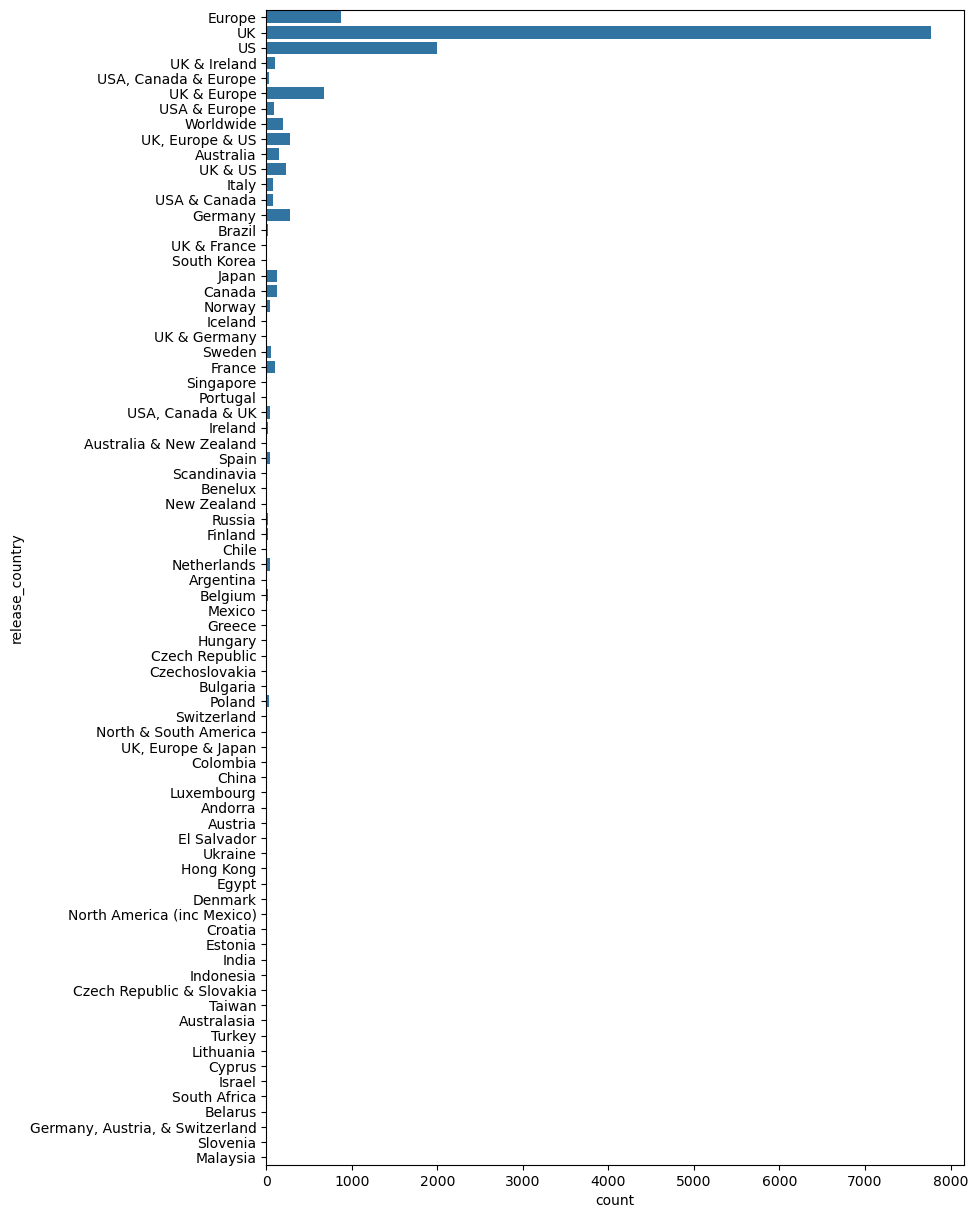

In [26]:
plt.figure(figsize=(9,15))
sns.countplot(data=df_masters_concat, y='release_country')

In [8]:
df_masters_concat.year.value_counts().head(10)

year
2020    1255
2019    1208
2016    1204
2021    1082
2022    1039
2023     975
2018     799
2024     778
2014     608
2015     470
Name: count, dtype: int64

<Axes: xlabel='count', ylabel='year'>

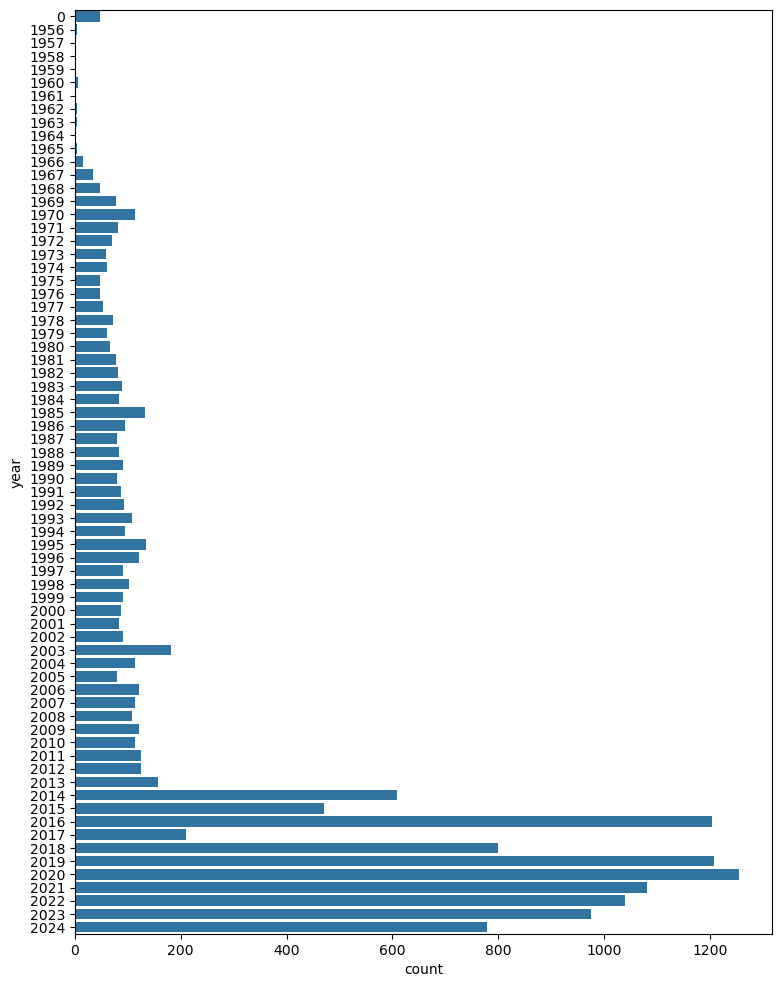

In [21]:
plt.figure(figsize=(9,12))
sns.countplot(data=df_masters_concat, y='year')

In [9]:
df_masters_concat.genres.value_counts().head(10)

genres
['Rock']                                     10004
['Electronic', 'Rock']                        1044
['Rock', 'Pop']                                983
['Rock', 'Folk, World, & Country']             479
['Electronic', 'Rock', 'Pop']                  229
['Jazz', 'Rock']                               123
['Rock', 'Blues']                              104
['Rock', 'Pop', 'Folk, World, & Country']       96
['Pop']                                         70
['Electronic']                                  69
Name: count, dtype: int64

In [10]:
df_masters_concat.styles.value_counts().head(10)

styles
['Indie Rock']                        780
['Punk']                              554
['Alternative Rock']                  513
[]                                    416
['Black Metal']                       391
['Prog Rock']                         379
['Psychedelic Rock']                  368
['Hard Rock']                         264
['Alternative Rock', 'Indie Rock']    243
['Death Metal']                       243
Name: count, dtype: int64

In [11]:
df_masters_concat[df_masters_concat['release_country']=='Europe'].sort_values('artist')

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
1829,156155,118883,737915,Europe,3 Mustaphas 3,Shopping,1987,44.72,9,"['LP', 'Album']","['Rock', 'Folk, World, & Country']",['Folk Rock'],British band [b]3 Mustaphas 3[/b] did much to ...
4689,3750880,1706746,15028328,Europe,5 Seconds Of Summer,CALM,2020,39.50,12,['Album'],"['Rock', 'Pop']","['Pop Rock', 'Power Pop']",5 Seconds Of Summer (5SOS) is an Australian po...
1326,103279,219113,2075252,Europe,60ft Dolls,The Big 3,1996,41.67,13,['Album'],['Rock'],"['Britpop', 'Indie Rock', 'Hard Rock']","Rock trio from Newport, South Wales, in the st..."
2899,14085388,3566297,31387334,Europe,86TVs,86TVs,2024,0.00,15,"['LP', 'Album', 'Limited Edition']","['Rock', 'Pop']","['Alternative Rock', 'Indie Rock']","Made up of [a499923] Felix and Hugo White, alo..."
13165,72848,67911,478707,Europe,A,Hi-Fi Serious,2002,45.50,12,['Album'],['Rock'],"['Alternative Rock', 'Grunge']","Alternative rock band formed in Suffolk, Engla..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3780,6774153,3038081,26603456,Europe,boygenius,The Record,2023,42.32,12,['Album'],['Rock'],"['Folk Rock', 'Indie Rock']","Phoebe Bridgers, Lucy Dacus and Julien Baker f..."
1088,3971017,725754,6023794,Europe,frnkiero andthe cellabration.,.Stomachaches.,2014,0.00,12,['Album'],['Rock'],[],NaN
3744,12268465,3149436,27982503,Europe,sign crushes motorist,Hurting,2023,30.42,10,"['Album', 'Limited Edition', 'Stereo']",['Rock'],"['Alternative Rock', 'Indie Rock', 'Noisecore']",Add as Sign Crushes Motorist
9400,5609390,1558662,13757895,Europe,whenyoung,Reasons To Dream,2019,41.67,11,['Album'],['Rock'],['Alternative Rock'],"Whenyoung is an Irish indie rock group, origin..."


In [13]:
df_masters_concat['artist_profile'].isna().sum()

1971

In [14]:
percentage_artist_profile_missing = round(df_masters_concat['artist_profile'].isna().sum() / df_masters_concat.shape[0] * 100, 2)
print(f'% missing artist_profile: {percentage_artist_profile_missing}%')

% missing artist_profile: 14.02%


In [15]:
df_masters_concat[df_masters_concat['artist_profile']==''] # should be empty

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile


In [284]:
df_masters_concat.loc[10, 'artist_profile']

'English Pop punk band from Southend-on-Sea, Essex, consisting of James Bourne, Matt Willis and Charlie Simpson. Formed in 2000, the band had four UK number-one singles, won two Brit awards and have released four studio albums, selling in excess of five million records.\r\n\r\nIn 2003, Dutch releases of this band were released under the artist name "Bust" to avoid confusion with Dutch band [a493201] who had a hit back then with "We Want More".'

In [16]:
df_masters_concat.groupby(["release_country", 'year']).agg({'master_id': 'count'}).sort_values('master_id', ascending=False).astype(int).head(10)

master_id
release_country year           
UK              2020        741
                2019        718
                2016        669
                2021        602
                2022        577
                2023        551
                2018        435
                2024        428
                2014        310
                2015        269

## Other actions I can do later

### Classifying releases: albums and EP/singles

In my opinion it's important to distinguish albums than EPs/singles, so I will add another feature.

I find that many albums have ``album_length = 0``, I will just drop these albums if they have few tracks (probably EPs)

33⅓ RPM → Likely an album (if track count is high).

45 RPM → Likely a single or EP (if track count is low).

12" at 45 RPM → Probably a maxi-single or extended EP.

**EXPLODE**

In [149]:
df_masters_concat.sample(5)

,master_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
314,454,UK,Dave Tarrida,Life's A Glitch,2004,0.00,8,"['12""', '33 ⅓ RPM', 'Album']",['Electronic'],"['Techno', 'Electro', 'Experimental']","Producer born in Edinburgh, Scotland. Founding..."
379,526,US,Fabrice Lig,Gualapagos EP,2002,0.00,4,"['12""', 'EP']",['Electronic'],['Techno'],Belgian DJ and producer.
648,819,Japan,Utada Hikaru,Automatic / Time Will Tell,1998,16.23,3,"['Maxi-Single', 'Stereo']","['Funk / Soul', 'Pop']","['J-pop', 'Vocal', 'Contemporary R&B']","Hikaru Utada (born January 19, 1983 in Manhatt..."
578,742,Netherlands,Armin van Buuren,Going Wrong,2008,21.92,3,"['12""']",['Electronic'],['Trance'],Dutch record producer and DJ born 25 December ...
250,384,Germany,Cristian Vogel,Dungeon Master,2002,0.00,8,"['12""', '33 ⅓ RPM', 'Album']",['Electronic'],"['Techno', 'Electro']","Cristian Vogel (born 1972, Santiago, Chile) is..."


In [150]:
print(df_masters_concat['release_type'].dtype)

object


These are actually not lists, like [Electronic], different than actual lists ['Electronic']

In [ ]:
import ast
import re

# Define a cleaning function
def clean_and_convert(x):
    if isinstance(x, str):
        # Fix the 12'' issue by replacing double apostrophes with a single apostrophe
        x = re.sub(r"''", "'", x)  # Replace '' with a single '
        
        # Handle other possible special characters or unwanted formatting
        # x = x.replace('⅓', '1/3')  # Example for specific character replacement
        
        try:
            return ast.literal_eval(x)  # Convert to list
        except (SyntaxError, ValueError):
            return x  # Return original string if conversion fails
    return x  # If not a string, return it as is

# Apply cleaning and conversion
df_masters_concat['release_type'] = df_masters_concat['release_type'].apply(clean_and_convert)

# Now try exploding the column again
df_masters_concat = df_masters_concat.explode('release_type')
df_masters_concat.head()

,master_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles
0,113,UK,Vince Watson,Moments In Time,2002,75.23,13,Album,['Electronic'],"['Techno', 'Tech House']"
1,114,UK,Vince Watson,Biologique,1999,75.78,12,Album,['Electronic'],"['Deep House', 'Tech House', 'Techno']"
2,115,Switzerland,Soleil (2),Soleil,2004,22.55,5,MP3,['Electronic'],"['IDM', 'Electro']"
3,116,Germany,Blue Arsed Fly,Knackered EP,1997,13.87,3,"12""",['Electronic'],['Techno']
3,116,Germany,Blue Arsed Fly,Knackered EP,1997,13.87,3,EP,['Electronic'],['Techno']


In [ ]:
# check the total number of releases I have
df_masters_concat.shape 

(126, 10)

In [ ]:
# how many duplicates so far (theorically 0)
df_masters_concat[['master_id', 'release_type']].duplicated().sum()

0

In [ ]:
# different types of releases
print(f'Number of release types: {df_masters_concat['release_type'].nunique()}')
print(df_masters_concat['release_type'].unique())

Number of release types: 14
['Album' 'MP3' '12"' 'EP' '33 ⅓ RPM' '45 RPM' '7"' 'Single' 'Stereo'
 'FLAC' 'LP' 'White Label' 'Limited Edition' 'Repress']


In [ ]:
# easy transformations
df_masters_concat['release_type'] = np.where(df_masters_concat['title'].str.contains(r'\bEP\b|\bE\.P\.\b', regex=True), 'EP', df_masters_concat['release_type'])
df_masters_concat['release_type'] = np.where(df_masters_concat['release_type']=='Single', 'EP', df_masters_concat['release_type'])

df_masters_concat[['master_id', 'release_type']].duplicated().sum()
# how many duplicates now (theorically more than 0)

15

In [ ]:
# dropping the duplicates and checking the new number of releases
df_masters_concat = df_masters_concat.drop_duplicates(subset=['master_id', 'release_type'])
df_masters_concat.shape

(111, 10)

In [ ]:
df_albums = df_masters_concat['release_type'] == 'Album' # mask for albums
df_ep = df_masters_concat['release_type'] == 'EP' # mask for EP
df_releases = df_masters_concat[df_albums | df_ep] # combine both masks in a new df
df_releases.shape[0] # releases converted to either Album or EP

29

In [ ]:
# the releases I still have to convert
df_masters_concat[~df_masters_concat['master_id'].isin(df_releases['master_id'])].shape[0]

42

In [ ]:
df_masters_concat.pivot_table(values="master_id", index="release_type", aggfunc="count").sort_values('master_id')

,master_id
release_type,
Limited Edition,1
White Label,1
FLAC,2
LP,2
MP3,2
Stereo,2
"7""",3
Album,6
45 RPM,11


In [ ]:
df_masters_concat.sort_values('release_type')

,master_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles
27,141,UK,Dvus,The Last E / The Last A,1991,0.00,2,"12""",['Electronic'],"['Breakbeat', 'Hardcore', 'Techno']"
21,135,UK,Max Duley,Watch As We Now Drift,1998,0.00,5,"12""",['Electronic'],"['Techno', 'Experimental']"
25,139,UK,Max Duley,Joyrage,1999,0.00,4,"12""",['Electronic'],"['Techno', 'Experimental']"
44,160,UK,Max Duley,Mute Embrace,2001,0.00,3,"12""",[Electronic],"[Techno, Experimental]"
35,149,UK,Max Duley,Walking Wounded,2000,0.00,4,"12""",['Electronic'],"['Abstract', 'Techno', 'Tribal', 'Experimental']"
...,...,...,...,...,...,...,...,...,...,...
2,115,Switzerland,Soleil (2),Soleil,2004,22.55,5,MP3,['Electronic'],"['IDM', 'Electro']"
33,147,Germany,choenyi,Defervescence,2007,61.67,11,MP3,['Electronic'],"['Minimal Techno', 'Experimental']"
17,130,US,Cybotron,Clear,1983,11.10,2,Stereo,"['Electronic', 'Hip Hop']",['Electro']
16,129,US,Cybotron,Alleys Of Your Mind,1981,7.37,2,Stereo,['Electronic'],['Electro']


In [ ]:
df_masters_concat.sort_values('master_id')

,master_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles
0,113,UK,Vince Watson,Moments In Time,2002,75.23,13,Album,['Electronic'],"['Techno', 'Tech House']"
1,114,UK,Vince Watson,Biologique,1999,75.78,12,Album,['Electronic'],"['Deep House', 'Tech House', 'Techno']"
2,115,Switzerland,Soleil (2),Soleil,2004,22.55,5,MP3,['Electronic'],"['IDM', 'Electro']"
3,116,Germany,Blue Arsed Fly,Knackered EP,1997,13.87,3,EP,['Electronic'],['Techno']
4,117,UK,Origin,Wide-Eyed Angel,1999,22.27,2,"12""",['Electronic'],['Progressive Trance']
...,...,...,...,...,...,...,...,...,...,...
48,165,UK,Art Brut,Emily Kane,2005,0.00,2,EP,[Rock],[Indie Rock]
49,167,Germany,choenyi,Over Time,2007,39.48,6,FLAC,[Electronic],"[Minimal Techno, Experimental]"
49,167,Germany,choenyi,Over Time,2007,39.48,6,Album,[Electronic],"[Minimal Techno, Experimental]"
50,168,UK,Cosmo & Dibs,Help Me / Oh So Nice,1991,11.28,2,"12""",[Electronic],"[Breakbeat, Hardcore]"


In [ ]:
# show only the 33 ⅓ RPM's
df_masters_concat[df_masters_concat['release_type']=="33 ⅓ RPM"].sort_values('tracks', ascending=False)

,master_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles
42,157,UK,2 Bad Mice,Hold It Down,1992,22.45,6,33 ⅓ RPM,[Electronic],"[Breakbeat, Hardcore]"
8,121,UK,Mixrace,The Future Is Before Your Eyes,1992,0.00,6,33 ⅓ RPM,['Electronic'],"['Hardcore', 'Breakbeat']"
9,122,UK,Mixrace,Organized Chaos E.P.,1993,0.00,6,33 ⅓ RPM,['Electronic'],"['Breakbeat', 'Hardcore', 'Jungle']"
21,135,UK,Max Duley,Watch As We Now Drift,1998,0.00,5,33 ⅓ RPM,['Electronic'],"['Techno', 'Experimental']"
23,137,UK,Max Duley,Beyond The Pale E.P.,1999,0.00,5,33 ⅓ RPM,['Electronic'],"['Techno', 'Experimental']"
6,119,UK,Hyper On Experience,Keep It In The Family E.P.,1993,0.00,4,33 ⅓ RPM,['Electronic'],"['Breakbeat', 'Hardcore']"
35,149,UK,Max Duley,Walking Wounded,2000,0.00,4,33 ⅓ RPM,['Electronic'],"['Abstract', 'Techno', 'Tribal', 'Experimental']"
34,148,UK,Max Duley,This Weak Flesh,2000,0.00,4,33 ⅓ RPM,['Electronic'],"['Techno', 'Experimental']"
32,146,UK,Max Duley,Storyteller,2000,0.00,4,33 ⅓ RPM,['Electronic'],"['Abstract', 'Techno', 'Experimental']"
31,145,UK,Max Duley,Elegant Manoeuvres,2000,0.00,4,33 ⅓ RPM,['Electronic'],['Techno']


In [ ]:
# show only the 45 RPM's
df_masters_concat[df_masters_concat['release_type']=="45 RPM"].sort_values('tracks', ascending=False)

,master_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles
7,120,UK,Hyper On Experience,Fun For All The Family E.P.,1992,18.75,6,45 RPM,['Electronic'],"['Breakbeat', 'Hardcore']"
34,148,UK,Max Duley,This Weak Flesh,2000,0.00,4,45 RPM,['Electronic'],"['Techno', 'Experimental']"
40,155,UK,2 Bad Mice,2 Bad Mice / No Respect,1991,0.00,4,45 RPM,[Electronic],"[Breakbeat, Hardcore]"
44,160,UK,Max Duley,Mute Embrace,2001,0.00,3,45 RPM,[Electronic],"[Techno, Experimental]"
46,163,UK,Max Duley,Genuflect,2003,0.00,3,45 RPM,[Electronic],"[Abstract, Techno, Experimental]"
47,164,Germany,House Pimps,Get The Hook,1993,0.00,3,45 RPM,[Electronic],"[Hard Trance, Acid]"
16,129,US,Cybotron,Alleys Of Your Mind,1981,7.37,2,45 RPM,['Electronic'],['Electro']
24,138,UK,Dvus,T-10 / Thrillseekers,1991,0.00,2,45 RPM,['Electronic'],"['Breakbeat', 'Hardcore', 'Techno']"
26,140,Germany,Cybotron,Alleys Of Your Mind / Off To Battle,2004,0.00,2,45 RPM,['Electronic'],"['Techno', 'Electro']"
39,154,Belgium,V-One,Dead Cities,1999,17.90,2,45 RPM,[Electronic],"[Trance, Progressive Trance]"


33⅓ RPM → Likely an album (if track count is high).

45 RPM → Likely a single or EP (if track count is low).

12" at 45 RPM → Probably a maxi-single or extended EP.

### Dropping releases

In [ ]:
# define the 2 conditions
df_eps_0 = df_masters_concat[df_masters_concat['album_length']==0].query('tracks <= 6')

# print the rows
print(f'Total rows: {df_masters_concat.shape[0]}')  
print(f'EPs: {df_eps_0.shape[0]}')

Total rows: 20
EPs: 7


In [ ]:
df_eps_0.sort_values('tracks')

,master_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles
5,118,UK,Origin,Yellow,1999,0.0,2,"[12""]",[Electronic],"[Progressive House, Trance]"
13,126,UK,Earth Leakage Trip,Neopolitan EP,1992,0.0,3,"[12"", 33 ⅓ RPM, EP]",[Electronic],"[Breakbeat, Hardcore, Techno, Bleep]"
6,119,UK,Hyper On Experience,Keep It In The Family E.P.,1993,0.0,4,"[12"", 33 ⅓ RPM, EP]",[Electronic],"[Breakbeat, Hardcore]"
10,123,UK,Mixrace,The Endless Skies / True Jungle,1994,0.0,4,"[12"", 33 ⅓ RPM]",[Electronic],"[Drum n Bass, Jungle]"
14,127,UK,Earth Leakage Trip,The Virtuality EP,1992,0.0,4,"[12"", EP, 45 RPM]",[Electronic],"[Breakbeat, Techno, Ambient]"
8,121,UK,Mixrace,The Future Is Before Your Eyes,1992,0.0,6,"[12"", 33 ⅓ RPM]",[Electronic],"[Hardcore, Breakbeat]"
9,122,UK,Mixrace,Organized Chaos E.P.,1993,0.0,6,"[12"", EP, 33 ⅓ RPM]",[Electronic],"[Breakbeat, Hardcore, Jungle]"


In [ ]:
df_eps_0.country.value_counts()

country
UK         57
US         10
Germany     6
Name: count, dtype: int64

In [ ]:
df_eps_0.genres.value_counts()

genres
['Electronic']    41
[Electronic]      28
[Rock]             3
['Rock']           1
Name: count, dtype: int64

In [ ]:
# keeping only the id that are NOT (~) in df_eps_0
df_masters_concat = df_masters_concat[~df_masters_concat['master_id'].isin(df_eps_0['master_id'])]
print(f'Rows left: {df_masters_concat.shape[0]}') 

Rows left: 46


In [ ]:
# sort by the number of tracks in the album, ascending
df_masters_concat.sort_values(['tracks', 'album_length'], ascending=True).head(20)

,artist,album,year,country,album_length,tracks,genres,styles,master_id
108,Chris Liberator,Just Say No To The Bush Conspiracy!,2004,UK,0.00,1,[Electronic],"[Techno, Acid]",228
18,choenyi,Sew,2008,US,140.98,1,['Electronic'],"['Abstract', 'Experimental', 'Ambient']",131
24,Dvus,T-10 / Thrillseekers,1991,UK,0.00,2,['Electronic'],"['Breakbeat', 'Hardcore', 'Techno']",138
26,Cybotron,Alleys Of Your Mind / Off To Battle,2004,Germany,0.00,2,['Electronic'],"['Techno', 'Electro']",140
27,Dvus,The Last E / The Last A,1991,UK,0.00,2,['Electronic'],"['Breakbeat', 'Hardcore', 'Techno']",141
48,Art Brut,Emily Kane,2005,UK,0.00,2,['Rock'],['Indie Rock'],165
62,Christiaan Kouijzer,Hydraulix 24,2004,UK,0.00,2,['Electronic'],['Techno'],181
65,D.A.V.E. The Drummer,Hotwire,2006,US,0.00,2,['Electronic'],['Techno'],184
68,D.A.V.E. The Drummer,Strictly Underground,1998,UK,0.00,2,['Electronic'],"['Techno', 'Acid']",188
70,Sci,The Blind Man / Uprising,1991,UK,0.00,2,['Electronic'],"['Breakbeat', 'Hardcore', 'Techno']",190


In [ ]:
df_masters_concat.shape

(89, 9)

In [ ]:
df_masters_concat.drop([18,24], inplace=True)
df_masters_concat.shape

(87, 9)

### **``album_length = 0`` Let's try to find the length in Spotipy**

In [825]:
df_masters_concat.album_length.value_counts().head()

album_length
0.00     158
43.15      2
23.53      2
11.28      2
11.83      2
Name: count, dtype: int64

In [830]:
percentage_album_length_missing = round(df_masters_concat[df_masters_concat['album_length']==0].shape[0] / df_masters_concat.shape[0] * 100, 2)
print(f'% missing album_length: {percentage_album_length_missing}%')

% missing album_length: 40.72%


I think **I'm gonna have a problem with the album length**, because about a third of the albums don't have info of the songs duration on the Discogs API.

Introducing this data manually can take a looooong time...

In [831]:
# import the df of the albums I have already scrapped
df_masters_concat = pd.read_csv('Datasets/df_masters.csv')
df_masters_concat.shape

(388, 11)

In [832]:
from dotenv import load_dotenv
import os
load_dotenv()

True

In [834]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

user = os.getenv('client_id')
password = os.getenv('client_secret')

#Initialize SpotiPy with user credentials
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id = user,
                                                           client_secret = password))

In [836]:
# subset where album_length = 0
df_masters_concat[df_masters_concat['album_length']==0].sample(5)

,master_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
343,468,US,DJ ESP,The Earthworm Sings,1993,0.0,3,"['12""', '33 ⅓ RPM']",['Electronic'],"['Techno', 'Acid']",Originally known as DJ Groovespot way way back...
120,241,US,Blink-182,They Came To Conquer...Uranus,1996,0.0,3,"['7""', '45 RPM']",['Rock'],['Punk'],"Pop punk band from California, US.\r\nFormed 1..."
347,472,US,Frame Six,Spellbound EP,1999,0.0,4,"['12""', '33 ⅓ RPM', 'EP']",['Electronic'],['Techno'],NaN
45,162,UK,Max Duley,Speech Emphasis,2001,0.0,4,"['12""', '33 ⅓ RPM']",['Electronic'],"['Techno', 'Experimental']",West London based producer & DJ. Founder of th...
107,228,UK,Chris Liberator,Just Say No To The Bush Conspiracy!,2004,0.0,1,"['12""', 'Single Sided']",['Electronic'],"['Techno', 'Acid']",Major UK Acid/Techno DJ & producer.\r\n\r\nHal...


In [849]:
# copy the artist name
artist = 'Chris Liberator'

results = sp.search(q = artist
                    , type = 'artist'
                    , limit = 5)

# theorically the artist should be the first result
artist_name = results['artists']['items'][0]['name']
artist_id = results['artists']['items'][0]['id'] # get the artist_id

if artist_name == artist:
    print(f'artist: {artist_name}')
    print(f'id: {artist_id}')
else:
    print('cannot find this artist, try some other position')

artist: Chris Liberator
id: 2Sx6hw3kQuFZeWLR7fIfKs


I have to add a couple of conditions, because I want only **albums** and my artist to be the **main artist**

In [850]:
results = sp.artist_albums(artist_id
                        #    , include_groups = 'album, single'
                           , limit=50)
# create empty lists
artist_list = []
album_list = []
album_type_list = []
album_release_date_list = []
total_tracks_list = []

data = results['items']

for i in range(len(data)):
    album_type = data[i]['album_type']
    artist = data[i]['artists'][0]['name']
    total_tracks = data[i]['total_tracks']

    # only interested in albums from my artist
    if artist != artist_name:
        pass
    else:
        # define features
        album = data[i]['name']
        album_type = data[i]['album_type']
        album_release_date = data[i]['release_date']

        # save the info in the lists
        artist_list.append(artist)
        album_list.append(album)
        album_type_list.append(album_type)
        album_release_date_list.append(album_release_date)
        total_tracks_list.append(total_tracks)

        print(album)

We Want To Fucking Party
We Are Acid!
Acid Tension
Acid Techno In The Modern Era
Mainstream
SUF107
OFFICIAL:007
We Have Lost the Way
Teknic 07
Happy Birthday LSD
Peak Sweets
We're On The Outside
Deadly Swine
Way Of The Samurai
Dirt Box
I'm Bored
Illegal Rave Re-curring
One Night In Hackney Remixes
Beethoven / Mozart
Science Of Acid
Beats Rockin' EP
Typhoon
Soul Mantra / Black Star Rising
Spectrum - Remixes


In [851]:
# create the dataframe
df_albums = pd.DataFrame({'artist': artist_list
                            , 'release_date': album_release_date_list 
                            , 'album': album_list
                            , 'tracks': total_tracks_list
                            , 'album_type': album_type_list
                           })
df_albums.shape

(24, 5)

In [852]:
# check if my album is in the results
df_albums.sort_values('tracks')

,artist,release_date,album,tracks,album_type
0,Chris Liberator,2024-12-18,We Want To Fucking Party,1,single
1,Chris Liberator,2024-12-18,We Are Acid!,1,single
2,Chris Liberator,2024-12-18,Acid Tension,1,single
4,Chris Liberator,2021-09-07,Mainstream,1,single
7,Chris Liberator,2018-12-04,We Have Lost the Way,1,single
21,Chris Liberator,1998-02-09,Typhoon,2,single
19,Chris Liberator,1999,Science Of Acid,2,single
18,Chris Liberator,2005-01-03,Beethoven / Mozart,2,single
17,Chris Liberator,2006-06-01,One Night In Hackney Remixes,2,single
16,Chris Liberator,2007-02-05,Illegal Rave Re-curring,2,single


In [853]:
# subset where album_length = 0
df_masters_concat[df_masters_concat['album_length']==0].head()

,master_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
5,118,UK,Origin,Yellow,1999,0.0,2,"['12""']",['Electronic'],"['Progressive House', 'Trance']",NaN
6,119,UK,Hyper On Experience,Keep It In The Family E.P.,1993,0.0,4,"['12""', '33 ⅓ RPM', 'EP']",['Electronic'],"['Breakbeat', 'Hardcore']","Alex Banks, Daniel Scott Demierre\r\n\r\nAlex ..."
8,121,UK,Mixrace,The Future Is Before Your Eyes,1992,0.0,6,"['12""', '33 ⅓ RPM']",['Electronic'],"['Hardcore', 'Breakbeat']",NaN
9,122,UK,Mixrace,Organized Chaos E.P.,1993,0.0,6,"['12""', 'EP', '33 ⅓ RPM']",['Electronic'],"['Breakbeat', 'Hardcore', 'Jungle']",NaN
10,123,UK,Mixrace,The Endless Skies / True Jungle,1994,0.0,4,"['12""', '33 ⅓ RPM']",['Electronic'],"['Drum n Bass', 'Jungle']",NaN


In [ ]:
df_masters_concat.shape

(89, 9)

I don't want to get rid of these albums, because they have been released so dropping them would be deleting information, but they affect the average of ``album_length``, so I will just convert them to null values.

In [ ]:
# replace it with a nan
df_masters_concat.loc[28, 'album_length'] = np.nan

In [ ]:
df_masters_concat[df_masters_concat['album_length']==0].head()

,artist,album,year,country,album_length,tracks,genres,styles,master_id
6,Hyper On Experience,Keep It In The Family E.P.,1993,UK,0.0,4,['Electronic'],"['Breakbeat', 'Hardcore']",119
8,Mixrace,The Future Is Before Your Eyes,1992,UK,0.0,6,['Electronic'],"['Hardcore', 'Breakbeat']",121
9,Mixrace,Organized Chaos E.P.,1993,UK,0.0,6,['Electronic'],"['Breakbeat', 'Hardcore', 'Jungle']",122
10,Mixrace,The Endless Skies / True Jungle,1994,UK,0.0,4,['Electronic'],"['Drum n Bass', 'Jungle']",123
13,Earth Leakage Trip,Neopolitan EP,1992,UK,0.0,3,['Electronic'],"['Breakbeat', 'Hardcore', 'Techno', 'Bleep']",126


### **Exporting to csv**

In [ ]:
df_masters_concat.to_csv('Datasets/df_masters.csv', index=False)

## Other options

### Getting the ``master_id`` from every album (all countries, only rock, one year at a time)

**BEWARE:** these are releases, but it could be a re-edition, and there are many different releases (for different countries, etc), so **it's not the actual ``year`` of the album, neither ``genre``**.

That's why I'm getting the ``master_id`` and later I'm going to do another search by this feature, where the actual ``year``, ``genre`` and ``style`` of the album is stored

We will see this later when I create the df, **there will be duplicates with the same ``master_id``** and slightly different data (most of which I'm not getting, so you won't see it). The important thing is that there will be duplicates.

In [ ]:
url = "https://api.discogs.com/database/search"
headers = {"User-Agent": "MyDiscogsApp/1.0", "Authorization": "Discogs token=UwfqmsztxwnfABgQpmhaAsprbUgpOJKGOJSQAqfp"}

# Lists when there are less than 10.000 releases
titles_list = []
countries_list = []
master_id_list = []

# Lists when there are more than 10.000 releases, so I know which ones I have to iterate over some other feature as well
years_to_iterate_list = []
countries_to_iterate_list = []
genres_to_iterate_list = []
releases_to_iterate_list = []

count = 0

# years = range(2024, 1960, -1)
# countries = ['US', 'UK']
rock_styles = ["Pop Rock", "Punk", "Alternative Rock", "Indie Rock", "Hardcore", "Rock & Roll", "Hard Rock", "Psychedelic Rock", "Black Metal",
               "Heavy Metal", "Folk Rock", "Experimental", "Prog Rock", "Death Metal", "Garage Rock"]

for style in rock_styles:
    # Define parameters for artist search
    params = {
        "per_page": 100    # Number of results per page (max 100)
        , "page": 1 
        , 'type': 'release'
        , 'format': 'album'
        # , 'country': country

        # items to change
        , 'genre': 'Rock'
        , 'year': 2024
        , 'style': style
    }
    
    response = requests.get(url, headers=headers, params=params)
    data = response.json()
    items_number = data['pagination']['items']  # number of items
    print(f"{country}, {style}: {items_number}")

    count+=1
    print(count)
    time.sleep(1)
    
    if items_number < 10000:

        pages = (data['pagination']['pages'])
        
        for page in range(1,pages+1):
            params["page"] = page
            params["sort"] = "title"
            params["sort_order"] = "asc"
            
            time.sleep(1)
            print(f'Page: {page}')
            response = requests.get(url, headers=headers, params=params)
            data = response.json()

            for i in range(len(data['results'])):
                data_release = data['results'][i]

                # define the data I want to get 
                title = data_release['title']                     
                country_release = data_release['country']
                master_id = data_release['master_id']

                if master_id == 0:
                    pass
                else:
                    titles_list.append(title)
                    countries_list.append(country_release)
                    master_id_list.append(master_id)  

    else:
        print('More than 10.000 releases, should iterate over something else as well')
        # years_to_iterate_list.append(year)
        # countries_to_iterate_list.append(country)
        # genres_to_iterate_list.append(genre)
        releases_to_iterate_list.append(items_number)

2024, US, Pop Rock: 3998
1
Page: 1
Page: 2
Page: 3
Page: 4
Page: 5
Page: 6
Page: 7
Page: 8
Page: 9
Page: 10
Page: 11
Page: 12
Page: 13
Page: 14
Page: 15
Page: 16
Page: 17
Page: 18
Page: 19
Page: 20
Page: 21
Page: 22
Page: 23
Page: 24
Page: 25
Page: 26
Page: 27
Page: 28
Page: 29
Page: 30
Page: 31
Page: 32
Page: 33
Page: 34
Page: 35
Page: 36
Page: 37
Page: 38
Page: 39
Page: 40
2024, US, Punk: 7336
2
Page: 1
Page: 2
Page: 3
Page: 4
Page: 5
Page: 6
Page: 7
Page: 8
Page: 9
Page: 10
Page: 11
Page: 12
Page: 13
Page: 14
Page: 15
Page: 16
Page: 17
Page: 18
Page: 19
Page: 20
Page: 21
Page: 22
Page: 23
Page: 24
Page: 25
Page: 26
Page: 27
Page: 28
Page: 29
Page: 30
Page: 31
Page: 32
Page: 33
Page: 34
Page: 35
Page: 36
Page: 37
Page: 38
Page: 39
Page: 40
Page: 41
Page: 42
Page: 43
Page: 44
Page: 45
Page: 46
Page: 47
Page: 48
Page: 49
Page: 50
Page: 51
Page: 52
Page: 53
Page: 54
Page: 55
Page: 56
Page: 57
Page: 58
Page: 59
Page: 60
Page: 61
Page: 62
Page: 63
Page: 64
Page: 65
Page: 66
Page: 67
Page:

KeyboardInterrupt: 

In [ ]:
df_to_iterate = pd.DataFrame({'year': years_to_iterate_list, 'country': countries_to_iterate_list, 'genre': genres_to_iterate_list, 'releases': releases_to_iterate_list})
df_to_iterate

,year,country,genre,releases


In [ ]:
lists = [('years_to_iterate_list', years_to_iterate_list)
         , ('countries_to_iterate_list', countries_to_iterate_list)
         , ('genres_to_iterate_list', genres_to_iterate_list)
         , ('releases_to_iterate_list', releases_to_iterate_list)
         ]

for name, lst in lists:
    print(f'{name}: {len(lst)}') # check that all lists have the same length (even though I had make sure with the previous code)

years_to_iterate_list: 0
countries_to_iterate_list: 0
genres_to_iterate_list: 0
releases_to_iterate_list: 0


### Saving the data

In [ ]:
lists = [ ('titles', titles_list)
         , ('countries', countries_list)
         , ('master_id', master_id_list)
         ]
for name, lst in lists:
    print(f'{name}: {len(lst)}') # check that all lists have the same length (even though I had made sure with the previous code)

titles_list: 107397
countries_list: 107397
master_id_list: 107397


In [ ]:
df_albums_rock = pd.DataFrame({'title': titles_list
                        , 'country_release': countries_list
                        , 'master_id': master_id_list
                            })
df_albums_rock.shape

(107397, 3)

In [ ]:
df_albums_rock.sample(10)

,title,country,master_id
68278,Ancst - Through The Woods,Germany,3558235
55655,Artemas - Pretty,Worldwide,3458783
38975,Engulf - The Dying Planet Weeps,Italy,3492816
57338,A Lot Like Birds - Conversation Piece,US,707805
92485,Better Than Ezra - Super Magick,US,3496260
12168,Shannon And The Clams - The Moon Is In The Wro...,Europe,3483532
64365,The Folk Implosion - Walk Thru Me,US,3528131
89588,Abrams - Blue City,US,3503631
67440,Aufnorden - Return To Jötunheimr,Canada,3116892
21003,My Solid Ground - My Solid Ground,Germany,314079


In [ ]:
df_albums_rock[['master_id']].duplicated().sum()

93720

In [ ]:
df_albums_rock.drop_duplicates(subset=['master_id'], inplace=True)
df_albums_rock.reset_index(drop=True, inplace=True)
df_albums_rock.shape

(13677, 3)

In [ ]:
df_albums_rock['master_id'] = df_albums_rock['master_id'].astype(str)
df_albums_rock.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13677 entries, 0 to 13676
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   title      13677 non-null  object
 1   country    13677 non-null  object
 2   master_id  13677 non-null  object
dtypes: object(3)
memory usage: 320.7+ KB


In [124]:
# importing the df of the albums I have already gotten
df_albums_rock_already_scrapped = pd.read_csv('Datasets/df_albums_rock.csv')
df_albums_rock_already_scrapped['master_id'] = df_albums_rock_already_scrapped['master_id'].astype(str)
df_albums_rock_already_scrapped.shape

(13677, 4)

In [ ]:
# df_albums_rock_already_scrapped = pd.read_csv('Datasets/df_albums_rock.csv')
# df_albums_rock_already_scrapped.rename(columns={'country': 'country_release'}, inplace=True)
# df_albums_rock_already_scrapped.to_csv('Datasets/df_albums_rock.csv')

In [ ]:
df_albums_rock_scrapped = pd.concat([df_albums_rock_already_scrapped, df_albums_rock])
df_albums_rock_scrapped.shape

(27354, 4)

In [ ]:
df_albums_rock_scrapped[['master_id']].duplicated().sum()

0

In [ ]:
df_albums_rock_scrapped.drop_duplicates(subset=['master_id'], inplace=True)
df_albums_rock_scrapped.reset_index(drop=True, inplace=True)
df_albums_rock_scrapped.shape

(13677, 3)

In [ ]:
# exporting to csv
df_albums_rock_scrapped.to_csv('Datasets/df_albums_rock.csv', index=False)

### Getting info from every album with the ``master_id``

#### Testing with only one album

In [ ]:
# import the dataframe of the albums already scrapped
df_albums_rock_scrapped = pd.read_csv('Datasets/df_albums_rock.csv')

In [ ]:
df_albums_rock_scrapped.head()

,title,country,master_id
0,"Πάνος Μουζουράκης, Θέμης Καραμουρατίδης, Γεράσ...",Greece,3518182
1,Мегаполис - Из Жизни Планет. Музыкальное Посвя...,Russia,766851
2,湯川潮音* - 湯川潮音,Japan,3598574
3,אריק איינשטיין* | שלום חנוך* - שבלול,Israel,496264
4,МакSим - Другая Реальность,Russia,574463


In [ ]:
# get the number of releases of every genre

headers = {"User-Agent": "MyDiscogsApp/1.0", "Authorization": "Discogs token=UwfqmsztxwnfABgQpmhaAsprbUgpOJKGOJSQAqfp"}

# Define parameters for artist search
master_id = 709794

url = f"https://api.discogs.com/masters/{master_id}"
response = requests.get(url, headers=headers)
data = response.json()
data

{'id': 709794,
 'main_release': 5887139,
 'most_recent_release': 30401390,
 'resource_url': 'https://api.discogs.com/masters/709794',
 'uri': 'https://www.discogs.com/master/709794-Low-Roar-0',
 'versions_url': 'https://api.discogs.com/masters/709794/versions',
 'main_release_url': 'https://api.discogs.com/releases/5887139',
 'most_recent_release_url': 'https://api.discogs.com/releases/26845514',
 'num_for_sale': 23,
 'lowest_price': 11.55,
 'images': [{'type': 'primary',
   'uri': 'https://i.discogs.com/XaTh6-GVSvHbr9LC-1DMB8ozig7IAFw4yVB9IMqz0KU/rs:fit/g:sm/q:90/h:272/w:300/czM6Ly9kaXNjb2dz/LWRhdGFiYXNlLWlt/YWdlcy9SLTU4ODcx/MzktMTQwNTQ0MjQz/Mi05Mjg3LmpwZWc.jpeg',
   'resource_url': 'https://i.discogs.com/XaTh6-GVSvHbr9LC-1DMB8ozig7IAFw4yVB9IMqz0KU/rs:fit/g:sm/q:90/h:272/w:300/czM6Ly9kaXNjb2dz/LWRhdGFiYXNlLWlt/YWdlcy9SLTU4ODcx/MzktMTQwNTQ0MjQz/Mi05Mjg3LmpwZWc.jpeg',
   'uri150': 'https://i.discogs.com/oIZ0fMYsr2i2CZR1s2ViocbpNHQME6phJP128AJZBIE/rs:fit/g:sm/q:40/h:150/w:150/czM6Ly9kaXN

In [ ]:
data['artists'][0]['name']

'Low Roar'

In [ ]:
data['tracklist'][1]['duration']

'4:49'

In [ ]:
# a more complex information is the total duration of the album, I have to sum the durations of each song
number_of_songs = len(data['tracklist'])

# number_of_songs_list.append(number_of_songs)
song_durations = []
album_length_list = []
number_of_songs

for song in range(number_of_songs):
    song_duration = data['tracklist'][song]['duration']
    print(song_duration)
    minutes = int(song_duration.split(':')[0])
    seconds = int(song_duration.split(':')[1])
    song_duration_minutes = minutes + seconds/60
    song_durations.append(song_duration_minutes)
album_length = sum(i for i in song_durations)
album_length_list.append(album_length)
album_length

7:35
4:49
5:56
5:52
7:16
4:41
5:35
1:25
6:04
3:16
5:10
6:31
4:04


68.23333333333333

In [ ]:
master_id_list

0       595460
1       709794
2      3430175
3        82436
4      3610565
        ...   
102    3469048
103    3523834
104    1694639
105     172974
106    2838163
Name: master_id, Length: 107, dtype: int64

#### Actual code (aprox 1.5 seconds every album)

In [ ]:
# import the dataframe of the albums already scrapped
df_albums_rock_scrapped = pd.read_csv('Datasets/df_albums_rock.csv')
master_id_list = df_albums_rock_scrapped['master_id']

df_rock_genres_concat = pd.read_csv('Datasets/df_rock_genres_concat.csv')

# create empty lists
artists_list = []
years_list = []
genres_list = []
styles_list = []
master_id_new_list = []
albums_list = []
album_length_list = []
tracks_list = []

count = 0
headers = {"User-Agent": "MyDiscogsApp/1.0", "Authorization": "Discogs token=UwfqmsztxwnfABgQpmhaAsprbUgpOJKGOJSQAqfp"}

for id in master_id_list:
    count+=1
    if id in df_rock_genres_concat['master_id'].values:
        print(f'{count} - album already scrapped')
        pass
    else:

        time.sleep(1)

        url = f"https://api.discogs.com/masters/{id}"
        response = requests.get(url, headers=headers, params=params)
        data = response.json()

        # define the data I want to get
        artist = data['artists'][0]['name']
        album_title = data['title']
        year = data['year']                 
        genres = data['genres']
        styles = data['styles']

        # a more complex information is the total duration of the album, I have to sum the durations of each song
        number_of_songs = len(data['tracklist'])

        # tracks_list.append(number_of_songs)
        song_durations = []

        for song in range(number_of_songs):
            song_duration = data['tracklist'][song]['duration']
            try:
                minutes = int(song_duration.split(':')[0])
                seconds = int(song_duration.split(':')[1])
                song_duration_minutes = minutes + seconds/60
                song_durations.append(song_duration_minutes)
            except:
                pass
            album_length = round(sum(i for i in song_durations), 2)
        
        print(f'{count}: {artist} - {album_title}')

        # Splitting the genres and styles (ChatGPT)
        # genres = ", ".join(data_release.get('genres', []))
        # styles = ", ".join(data_release.get('styles', []))

        artists_list.append(artist)
        albums_list.append(album_title)
        years_list.append(year)
        genres_list.append(genres)
        styles_list.append(styles)
        master_id_new_list.append(id)
        album_length_list.append(album_length)
        tracks_list.append(number_of_songs)

1 - album already scrapped
2 - album already scrapped
3 - album already scrapped
4 - album already scrapped
5 - album already scrapped
6 - album already scrapped
7 - album already scrapped
8 - album already scrapped
9 - album already scrapped
10 - album already scrapped
11 - album already scrapped
12 - album already scrapped
13 - album already scrapped
14 - album already scrapped
15 - album already scrapped
16 - album already scrapped
17 - album already scrapped
18 - album already scrapped
19 - album already scrapped
20 - album already scrapped
21 - album already scrapped
22 - album already scrapped
23 - album already scrapped
24 - album already scrapped
25 - album already scrapped
26 - album already scrapped
27 - album already scrapped
28 - album already scrapped
29 - album already scrapped
30 - album already scrapped
31 - album already scrapped
32 - album already scrapped
33 - album already scrapped
34 - album already scrapped
35 - album already scrapped
36 - album already scrapped
3

KeyboardInterrupt: 

### Saving the data

In [ ]:
lists = [('artists', artists_list)
         , ('albums', albums_list)
         , ('years', years_list)
         , ('album_length', album_length_list)
         , ('tracks', tracks_list)
         , ('genres', genres_list)
         , ('styles', styles_list)
         , ('master_id', master_id_new_list)
         ]
for name, lst in lists:
    print(f'{name}: {len(lst)}') # check that all lists have the same length (even though I had made sure with the previous code)

artists_list: 924
albums_new_list: 924
years_list: 924
album_length_list: 924
number_of_songs_list: 924
genres_list: 924
styles_list: 924
master_id_new_list: 924


In [ ]:
df_rock_genres = pd.DataFrame({'artist': artists_list
                        , 'album': albums_list
                        , 'year': years_list
                        , 'album_length': album_length_list
                        , 'tracks': tracks_list
                        , 'genres': genres_list
                        , 'styles': styles_list
                        , 'master_id': master_id_new_list
                        })
df_rock_genres.shape

(924, 8)

In [ ]:
df_rock_genres['master_id'] = df_rock_genres['master_id'].astype(str)
df_rock_genres.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 924 entries, 0 to 923
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   artist        924 non-null    object 
 1   album         924 non-null    object 
 2   year          924 non-null    int64  
 3   album_length  924 non-null    float64
 4   tracks        924 non-null    int64  
 5   genres        924 non-null    object 
 6   styles        924 non-null    object 
 7   master_id     924 non-null    object 
dtypes: float64(1), int64(2), object(5)
memory usage: 57.9+ KB


In [ ]:
df_rock_genres.sample(5)

,artist,album,year,album_length,tracks,genres,styles,master_id
648,INXS,X,1990,41.42,11,"[Electronic, Rock, Pop]","[Pop Rock, Synth-pop]",71886
897,Section 25,Always Now,1981,0.00,10,[Rock],"[New Wave, Post-Punk]",55226
433,Kate Bush,The Kick Inside,1978,42.35,13,"[Rock, Pop]","[Art Rock, Pop Rock]",28531
104,Charly Garcia,Piano Bar,1984,36.78,10,"[Rock, Pop]",[Pop Rock],517296
252,Santana,Shaman,2002,75.45,16,[Rock],"[Blues Rock, Classic Rock]",77693


### Concat with the previous df

In [ ]:
# import the last df
df_rock_genres_scrapped = pd.read_csv('Datasets/df_rock_genres.csv')
df_rock_genres_scrapped['master_id'] = df_rock_genres_scrapped['master_id'].astype(str)
df_rock_genres_scrapped.shape

(1006, 8)

In [ ]:
# concat with the previous df
df_rock_genres_concat = pd.concat([df_rock_genres_scrapped, df_rock_genres])
df_rock_genres_concat.reset_index(drop=True, inplace=True)
df_rock_genres_concat.shape

(1930, 8)

In [ ]:
df_rock_genres_concat.to_csv('Datasets/df_rock_genres_concat.csv', index=False)

### Merge with the previous df that had info of the country

In [ ]:
# merge with the previous df that had info of the country
df_rock_merged = pd.merge(df_albums_rock, df_rock_genres_concat, on=['master_id'])
df_rock_merged = df_rock_merged.drop('title', axis=1)
df_rock_merged

,country,master_id,artist,album,year,album_length,tracks,genres,styles
0,Greece,3518182,Πάνος Μουζουράκης,Μεγαλώνω,2024,29.83,9,"['Rock', 'Pop', 'Folk, World, & Country']","['Pop Rock', 'Éntekhno']"
1,Russia,766851,Мегаполис,Из Жизни Планет. Музыкальное Посвящение Неснят...,2014,81.92,15,"['Jazz', 'Rock', 'Stage & Screen']","['Pop Rock', 'Soundtrack', 'Easy Listening', '..."
2,Japan,3598574,Shione Yukawa,湯川潮音,2006,0.00,10,['Pop'],[]
3,Israel,496264,Arik Einstein,שבלול = Shablool,1970,43.35,12,"['Rock', 'Non-Music']","['Psychedelic Rock', 'Soft Rock', 'Comedy', 'P..."
4,Russia,574463,МакSим,Другая Реальность,2013,45.18,13,"['Electronic', 'Rock', 'Pop']","['Synth-pop', 'Pop Rock', 'Electro']"
...,...,...,...,...,...,...,...,...,...
1925,Greece,3478798,Selofan,Animal Mentality,2024,0.00,8,"[Electronic, Rock]","[Coldwave, Post-Punk]"
1926,US,3719619,Jr. Juggernaut,Another Big Explosion,2024,44.38,10,[Rock],[Punk]
1927,Europe,3565157,Fucked Up,Another Day,2024,37.75,10,[Rock],"[Hardcore, Punk]"
1928,Germany,3686892,Curses!,Another Heaven,2024,42.00,9,"[Electronic, Rock]","[Post-Punk, Synth-pop]"


In [ ]:
df_rock_merged.album_length.value_counts().head()

album_length
0.00     659
36.82      5
37.42      4
36.13      4
43.92      4
Name: count, dtype: int64

I think **I'm gonna have a problem with the album length**, because about a third of the albums don't have info of the songs duration on the Discogs API.

Introducing this data manually can take a looooong time...

In [ ]:
df_rock_merged.to_csv('Datasets/df_rock_merged.csv', index=False)

In [153]:
df_rock_merged = pd.read_csv('Datasets/df_rock_merged.csv')
df_rock_merged

,country,master_id,artist,album,year,album_length,tracks,genres,styles
0,Greece,3518182,Πάνος Μουζουράκης,Μεγαλώνω,2024,29.83,9,"['Rock', 'Pop', 'Folk, World, & Country']","['Pop Rock', 'Éntekhno']"
1,Russia,766851,Мегаполис,Из Жизни Планет. Музыкальное Посвящение Неснят...,2014,81.92,15,"['Jazz', 'Rock', 'Stage & Screen']","['Pop Rock', 'Soundtrack', 'Easy Listening', '..."
2,Japan,3598574,Shione Yukawa,湯川潮音,2006,0.00,10,['Pop'],[]
3,Israel,496264,Arik Einstein,שבלול = Shablool,1970,43.35,12,"['Rock', 'Non-Music']","['Psychedelic Rock', 'Soft Rock', 'Comedy', 'P..."
4,Russia,574463,МакSим,Другая Реальность,2013,45.18,13,"['Electronic', 'Rock', 'Pop']","['Synth-pop', 'Pop Rock', 'Electro']"
...,...,...,...,...,...,...,...,...,...
1925,Greece,3478798,Selofan,Animal Mentality,2024,0.00,8,"['Electronic', 'Rock']","['Coldwave', 'Post-Punk']"
1926,US,3719619,Jr. Juggernaut,Another Big Explosion,2024,44.38,10,['Rock'],['Punk']
1927,Europe,3565157,Fucked Up,Another Day,2024,37.75,10,['Rock'],"['Hardcore', 'Punk']"
1928,Germany,3686892,Curses!,Another Heaven,2024,42.00,9,"['Electronic', 'Rock']","['Post-Punk', 'Synth-pop']"


### Statistics

In [ ]:
df_rock_merged.country.value_counts().head(10)

country
US           447
Europe       179
Worldwide    163
Russia       136
Japan        130
UK           126
Germany       94
Spain         55
France        48
Italy         44
Name: count, dtype: int64

In [ ]:
df_rock_merged[df_rock_merged['country']=='Worldwide'].sort_values('year').head(10)

,country,master_id,artist,album,year,album_length,tracks,genres,styles
926,Worldwide,75259,The Beatles,Meet The Beatles!,1964,26.72,12,"['Rock', 'Pop']","['Beat', 'Rock & Roll', 'Pop Rock']"
1291,Worldwide,46151,The Beatles,Something New,1964,24.78,11,"[Rock, Pop]","[Rock & Roll, Pop Rock, Beat]"
106,Worldwide,507400,The Beatles,A Hard Day's Night (Original Motion Picture So...,1964,29.35,12,"['Rock', 'Stage & Screen']","['Soundtrack', 'Rock & Roll', 'Pop Rock']"
207,Worldwide,45760,The Beatles,Beatles '65,1964,26.77,11,['Rock'],"['Rock & Roll', 'Pop Rock']"
1108,Worldwide,17217,The Beach Boys,Pet Sounds,1966,35.02,13,"[Rock, Pop]","[Pop Rock, Vocal, Psychedelic Rock, Art Rock]"
1429,Worldwide,290764,The Four Seasons,The Genuine Imitation Life Gazette,1969,44.83,10,[Rock],"[Psychedelic Rock, Pop Rock]"
1538,Worldwide,84216,Elton John,Tumbleweed Connection,1970,46.88,10,[Rock],[Soft Rock]
446,Worldwide,84203,Elton John,Elton John,1970,39.40,10,['Rock'],['Pop Rock']
1640,Worldwide,48962,Wings (2),Wild Life,1971,37.95,8,"[Rock, Pop]",[Pop Rock]
902,Worldwide,85550,Elton John,Madman Across The Water,1971,45.13,9,['Rock'],"['Pop Rock', 'Classic Rock']"


In [ ]:
df_rock_merged.groupby(["country", 'year']).agg({'master_id': 'count'}).sort_values('master_id', ascending=False).astype(int).head(10)

,,master_id
country,year,
US,2024,175
Worldwide,2024,77
UK,2024,65
Germany,2024,52
Europe,2024,51
Spain,2024,26
France,2024,24
Japan,2024,24
US,2023,22


## **FOLLIUM HEATMAP**

In [ ]:
import folium
from folium import Marker, Icon, Map
from folium.plugins import HeatMap

In [ ]:
# agafem les coordenades de Sonora Sport Tavern (botó dret al punt del Google Maps)
spain_lat = 40.43866481145577
spain_lon = -3.6833287051188606 
map_1 = Map(location=[spain_lat, spain_lon], zoom_start=7)
map_1

In [ ]:
df_albums_scrapped.head()

,album_id,title,country,year,genres,styles
0,31709714,Chris Daniels & The Kings With Freddi Gowdy* -...,US,2024,Blues,NaN
1,31465775,49 Winchester - 49 Winchester,US,2024,"Rock, Blues, Folk, World, & Country","Country, Folk, Country Rock, Folk Rock, Indie ..."
2,31722665,Etran De L'Aïr - 100% Sahara Guitar,US,2024,"Rock, Blues, Folk, World, & Country","African, Folk Rock"
3,29863099,Big Sugar - 500 Pounds,UK & US,2024,"Rock, Blues",Blues Rock
4,32697411,Tommy Castro - A Bluesman Came To Town (A Blue...,US,2024,Blues,NaN


In [ ]:
df_albums_scrapped.shape[0]

389

In [ ]:
import random

long_min = -8.509390109879313
long_max = -1.0510570677868925
lat_max = 42.85354755087108
lat_min = 37.84946531795629
fake_lats = []
fake_longs = []

for i in range(df_albums_scrapped.shape[0]):
    lat = random.uniform(lat_min, lat_max)
    long = random.uniform(long_min, long_max)
    fake_lats.append(lat)
    fake_longs.append(long)

In [ ]:
df_albums_scrapped['lat'] = fake_lats
df_albums_scrapped['lon'] = fake_longs
df_albums_scrapped.head()

,album_id,title,country,year,genres,styles,lat,lon
0,31709714,Chris Daniels & The Kings With Freddi Gowdy* -...,US,2024,Blues,NaN,39.878615,-7.058068
1,31465775,49 Winchester - 49 Winchester,US,2024,"Rock, Blues, Folk, World, & Country","Country, Folk, Country Rock, Folk Rock, Indie ...",37.942980,-7.210670
2,31722665,Etran De L'Aïr - 100% Sahara Guitar,US,2024,"Rock, Blues, Folk, World, & Country","African, Folk Rock",39.735670,-4.038696
3,29863099,Big Sugar - 500 Pounds,UK & US,2024,"Rock, Blues",Blues Rock,39.139016,-3.558383
4,32697411,Tommy Castro - A Bluesman Came To Town (A Blue...,US,2024,Blues,NaN,41.363053,-5.208412


In [ ]:
spanish_artists = df_albums_scrapped # subset dels accidents del matí
spain_group = folium.FeatureGroup(name=f'Morning: whatever') # crear el FeatureGroup
HeatMap(data=df_albums_scrapped[['lat', 'lon']]).add_to(spain_group) # el subset és morning i només ens interessen 2 columnes: les coordenades
spain_group.add_to(map_1)
map_1

In [ ]:
album_id_list = []
artist_list = []
year_list = []
album_name_list = []
genres_list = []
styles_list = []
album_length_list = []
number_of_songs_list = []

count = 0

for id in releases_ids:
    url = f"https://api.discogs.com/releases/{id}"
    headers = {"Authorization": "Discogs token=UwfqmsztxwnfABgQpmhaAsprbUgpOJKGOJSQAqfp"}
    response = requests.get(url, headers=headers)
    data = response.json()

    # define the data I want to get    
    album_id = data['id']
    artist = data['artists'][0]['name']
    album_name = data['title']
    year = data['year']
    genres = data['genres']
    styles = data['styles']
    
    count+=1

    time.sleep(1) # so I don't reach the limit of 60 requests per minute

    release_type = data['formats'][0]['descriptions']

    album_id_list.append(album_id)
    artist_list.append(artist)
    year_list.append(year)  
    album_name_list.append(album_name) # I save the albums in a list
    genres_list.append(genres)
    styles_list.append(styles)

    # a more complex information is the total duration of the album, I have to sum the durations of each song
    number_of_songs = len(data['tracklist'])
    number_of_songs_list.append(number_of_songs)
    song_durations = []

    for song in range(number_of_songs):
        song_duration = data['tracklist'][song]['duration']
        minutes = int(song_duration.split(':')[0])
        seconds = int(song_duration.split(':')[1])
        song_duration_minutes = minutes + seconds/60
        song_durations.append(song_duration_minutes)
    album_length = sum(i for i in song_durations)
    album_length_list.append(album_length)

    print(count) # see the number of releases I have requested
    print(f'{id} - {album_name}') # and I print the albums and their id so I can see them while the code is still running


df_albums = pd.DataFrame({'album_id': album_id_list
                            , 'artist': artist_list
                            , 'year': year_list
                            , 'album': album_name_list
                            , 'duration': album_length_list
                            , 'number_of_songs': number_of_songs_list
                            , 'genres': genres_list
                            , 'styles': styles_list
                            })

4
2754978 - Creedence Clearwater Revival
24
680968 - Bayou Country
25
1132211 - Green River


KeyboardInterrupt: 

In [ ]:
lists = [('album_id_list', album_id_list)
         , ('artist_list', artist_list)
         , ('year_list', year_list)
         , ('album_name_list', album_name_list)
         , ('album_length_list', album_length_list)
         , ('number_of_songs_list', number_of_songs_list)
         , ('genres_list', genres_list)
         , ('styles_list', styles_list)
         ]

for name, lst in lists:
    print(f'{name}: {len(lst)}') # check that all lists have the same length (even though I had make sure with the previous code)

album_id_list: 3
artist_list: 3
year_list: 3
album_name_list: 3
album_length_list: 3
number_of_songs_list: 3
genres_list: 3
styles_list: 3


In [ ]:
number_of_songs_list

[8, 7, 9]

In [ ]:
# if I stop the scraping in the middle of a van and from the last van I have info only of some variables, I want to delete them, so I keep only the vans with the info of all the variables
lists = (titles, prices, dates, fuels, kms, capacities, seats, owners, consumptions, sliding_doors)
# for i in lists:
#     del i[-1]

In [ ]:
df_albums = pd.DataFrame({'album_id': album_id_list
                            , 'artist': artist_list
                            , 'year': year_list
                            , 'album': album_name_list
                            , 'duration': album_length_list
                            , 'number_of_songs': number_of_songs_list
                            , 'genres': genres_list
                            , 'styles': styles_list
                            })
df_albums

,album_id,artist,year,album,duration,number_of_songs,genres,styles
0,2754978,Creedence Clearwater Revival,1968,Creedence Clearwater Revival,32.916667,8,[Rock],"[Rock & Roll, Southern Rock, Classic Rock, Psy..."
1,680968,Creedence Clearwater Revival,1969,Bayou Country,33.716667,7,[Rock],"[Folk Rock, Blues Rock, Hard Rock]"
2,1132211,Creedence Clearwater Revival,1969,Green River,28.783333,9,[Rock],"[Folk Rock, Country Rock]"


In [ ]:
response.json()['title']

'Greatest Hits'

In [ ]:
albums_list

['Creedence Clearwater Revival',
 'Bayou Country',
 'Green River',
 'Willy And The Poor Boys',
 'Pendulum',
 "Cosmo's Factory",
 'Mardi Gras',
 'Live In Europe',
 'Live In Germany',
 'The Royal Albert Hall Concert',
 'More Creedence Clearwater Revival Greatest Hits',
 'The Very Best Of Creedence Clearwater Revival',
 'The Movie Album']

In [ ]:
url = f"https://api.discogs.com/releases/1148753"
headers = {"Authorization": "Discogs token=UwfqmsztxwnfABgQpmhaAsprbUgpOJKGOJSQAqfp"}
response = requests.get(url, headers=headers)
title = response.json()['title']
id = response.json()['id']
id

1148753

In [ ]:
len(releases_ids)

1621

In [ ]:
# comprovar quantes requests he fet i quantes me'n queden

rate_limit = response.headers.get("X-Discogs-Ratelimit")
rate_limit_used = response.headers.get("X-Discogs-Ratelimit-Used")
rate_limit_remaining = response.headers.get("X-Discogs-Ratelimit-Remaining")

print(f"Rate Limit: {rate_limit}")
print(f"Rate Limit Used: {rate_limit_used}")
print(f"Rate Limit Remaining: {rate_limit_remaining}")

Rate Limit: 60
Rate Limit Used: 2
Rate Limit Remaining: 58


In [ ]:
url = "https://api.discogs.com/releases/11286641"
headers = {"Authorization": "Discogs token=UwfqmsztxwnfABgQpmhaAsprbUgpOJKGOJSQAqfp"}
response = requests.get(url, headers=headers)
response.json()['title']

'Porterville / Call It Pretending'

**Step 6**: veure quin tipus de release és, si és ``album`` m'interessa, si no, no

['LP', 'Album', 'Stereo']

## Buscar artistes d'un gènere en concret

**Step 1**: anar a ``Search`` i buscar tots els ``artist`` (o ``release``)

https://www.discogs.com/developers/#page:database,header:database-search

In [188]:
url = "https://api.discogs.com/database/search"

headers = {"Authorization": "Discogs token=UwfqmsztxwnfABgQpmhaAsprbUgpOJKGOJSQAqfp"}

# Define parameters for album search
params = {
    "type": "master"  # Search for releases
    , "format": "album"           # just search for albums
    , "per_page": 100    # Number of results per page (max 100)
    , "page": 1          # Start with page 1
    , 'country': 'Spain'
    # , "year": 2023
    , 'genre': 'Rock'
    # , "style": "Prog Rock"
}

response = requests.get(url, headers=headers, params=params)
prog_rock_albums = response.json()['pagination']['items'] # número de items
prog_rock_albums

8864

In [163]:
response.json()['results'][0]['formats'][0]['descriptions']

['Album']

In [164]:
response.json()['pagination']['items']

2782

In [165]:
response.json()

{'pagination': {'page': 1,
  'pages': 28,
  'per_page': 100,
  'items': 2782,
  'urls': {'last': 'https://api.discogs.com/database/search?type=release&format=album&per_page=100&page=28&year=2023&style=Prog+Rock',
   'next': 'https://api.discogs.com/database/search?type=release&format=album&per_page=100&page=2&year=2023&style=Prog+Rock'}},
 'results': [{'country': 'Poland',
   'year': '2023',
   'format': ['CD', 'Album'],
   'label': ['Lynx Music',
    'Lynx Music',
    'Lynx Music',
    'Lynx Music',
    'Lynx Music Studio',
    'Rock-Serwis',
    'www.stereostyle.pl'],
   'type': 'release',
   'genre': ['Rock'],
   'style': ['Prog Rock'],
   'id': 26689616,
   'barcode': ['5 904653 776150',
    '5904653776150',
    '14153 www.stereostyle.pl',
    'IFPI L700',
    'IFPI ZY02'],
   'user_data': {'in_wantlist': False, 'in_collection': False},
   'master_id': 3433643,
   'master_url': 'https://api.discogs.com/masters/3433643',
   'uri': '/release/26689616-Framauro-Alea-Iacta-Est',
   'cat

In [ ]:
items = response.json()['pagination']['items']

for page in pages
for i in range(100):
    print(i, response.json()['results'][i]['formats'][0]['descriptions'])

0 ['Album', 'Album']
1 ['Album', 'Album']
2 ['Album', 'Album']
3 ['Album', 'Album']
4 ['Album']
5 ['Album', 'Album']
6 ['Album']
7 ['Album']
8 ['Album']
9 ['Album']
10 ['Album']
11 ['Album']
12 ['Album', 'Mini-Album']
13 ['Album']
14 ['Album', 'Mini-Album']
15 ['Album']
16 ['Album', 'Mini-Album']
17 ['Album']
18 ['Album']
19 ['Album']
20 ['Album', 'Mini-Album']
21 ['Album', 'Mini-Album']
22 ['Album']
23 ['Album']
24 ['Album']
25 ['Album', 'Mini-Album']
26 ['Album', 'Mini-Album']
27 ['Album', 'Mini-Album']
28 ['Album']
29 ['Album', 'Mini-Album']
30 ['Album', 'Mini-Album']
31 ['Album']
32 ['Album']
33 ['Album']
34 ['Album', 'Mini-Album']
35 ['Album']
36 ['Album', 'Mini-Album']
37 ['Album']
38 ['Album']
39 ['Album']
40 ['Album']
41 ['Album']
42 ['Album']
43 ['Album', 'Mini-Album']
44 ['Album']
45 ['Album']
46 ['Album', 'Mini-Album']
47 ['Album']
48 ['Album', 'Mini-Album']
49 ['Album', 'Mini-Album']
50 ['Album', 'Mini-Album']
51 ['Album', 'Mini-Album']
52 ['Album']
53 ['Album', 'Mini-Album

IndexError: list index out of range

In [ ]:
# mitjana d'albums per artista de prog rock
prog_rock_albums / df_prog_artists['artist'].count()

13.520257387988561

# 2. Rate Your Music - Webscraping (**fail**)

**NO DEIXA FER CAP TIPUS DE WEBSCRAPING**

In [ ]:
# Sonemic, Inc. prohibits any kind of automated means, (e.g. crawling, scraping, etc) of access to the service without express permission. Please see 
# https://rateyourmusic.com/tos

In [ ]:
url = 'http://rateyourmusic.com/artist/shpongle'
response = requests.get(url)

print(response.status_code)  # Should print 200 if successful

403


In [ ]:
url = 'http://rateyourmusic.com/artist/shpongle'
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/119.0.0.0 Safari/537.36"
}
response = requests.get(url, headers=headers).content

soup = BeautifulSoup(response)
rating = soup.select('#release_824835 > div.disco_info > div.disco_mainline > a')
rating

[]

In [ ]:
rating = soup.select("div.disco_info div.disco_mainline a")
print(rating)

[]


In [ ]:
rating

[]

# **3. Progarchives** - bs4 només artistes prog i Selenium info d'albums però un per un

http://www.progarchives.com/bands-alpha.asp?letter=a

In [ ]:
url = 'http://www.progarchives.com/bands-alpha.asp?letter=a'

headers = {'User-Agent': "Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:108.0) Gecko/20100101 Firefox/108.0"}
response = requests.get(url, headers=headers)

print(response.status_code)  # Should print 200 if successful

200


In [ ]:
from bs4 import BeautifulSoup

response = requests.get(url, headers=headers).content
soup = BeautifulSoup(response, "html.parser")
href = soup.select('tr td a')
href[0]

<a href="artist.asp?id=12469"><strong>Å</strong></a>

In [ ]:
href[0].get('href').split('=')[1]

'12469'

### **Get artists for first letter**

In [ ]:
# test with artists that their name start with the letter 'A'

url = 'http://www.progarchives.com/bands-alpha.asp?letter=a'
response = requests.get(url, headers=headers).content
soup = BeautifulSoup(response, "html.parser")

# Create empty lists
artist_name_a_list = []
artist_style_a_list = []
artist_country_a_list = []

# define what I want to scrape
artist_name_a = soup.select('tr td a')
artist_style_a = soup.select('tr td span')

for artist in range(len(artist_name_a)):
    print(f'{artist}: {artist_name_a[artist].text}')

for artist in range(3, len(artist_name_a), 2):
    print(f'{artist}: {artist_style_a[artist].text}')

for artist in range(4, len(artist_name_a), 2):
    print(f'{artist}: {artist_style_a[artist].text}')

0: Å
1: Å
2: A BAND, THE
3: A FOOL'S ERRAND
4: A LA PING PONG
5: A PIEDI NUDI
6: A((WAKE))
7: A-MUSIK
8: A-Z
9: A. ARMADA
10: A.C.T
11: A.I.(D)
12: A.L.F.
13: A.P.A.T.T.
14: A.R. & MACHINES
15: A.S.T.R.A
16: A2RK
17: AABSINTHE
18: AALTO
19: AAMUNKOITE
20: AARDVARK
21: AARDVARK'
22: AARFLOT, ANDREAS
23: AARON LEBOS REALITY
24: AARSET, EIVIND
25: AAXSKFG
26: ABACAB
27: ABACUS
28: ABANDON
29: ABANDONED STARS
30: ABARAX
31: ABASH
32: ABBFINOOSTY
33: ABBHAMA
34: ABEDUL
35: ABEL GANZ
36: ABERCROMBIE, JOHN
37: ABERRANT VASCULAR
38: ABIGAIL'S GHOST
39: ABIGOR
40: ABIOGENESI
41: ABISSI INFINITI
42: ABLUTION
43: ABNORMAL THOUGHT PATTERNS
44: ABODEAN SKYE
45: ABORYM
46: ABOU-KHALIL, RABIH
47: ABOUT TESS
48: ABOUT:BLANK
49: ABOVE SYMMETRY / EX ASPERA
50: ABRAHAM, LEE
51: ABRAXAS
52: ABRAXIS
53: ABRETE GANDUL
54: ABSCHAUM
55: ABSCONDITUS
56: ABSENTE H
57: ABSENTHIA
58: ABSINTHE JUNK
59: ABSOLACE
60: ABSOLUTE ELSEWHERE
61: ABSOLUTE ZERO
62: ABSOLUUTTINEN NOLLAPISTE
63: ABSORBED
64: ABSTRACCIÓN
65: A

In [ ]:
letters = [chr(i) for i in range(97, 123)]  # Lowercase a-z

# Create empty lists
artist_name_list = []
artist_href_list = []
artist_style_list = []
artist_country_list = []

for letter in letters:
    url = f'http://www.progarchives.com/bands-alpha.asp?letter={letter}'
    response = requests.get(url, headers=headers).content
    soup = BeautifulSoup(response, "html.parser")

    print(letter) # to keep track of the artists I have scraped and I'm currently scraping

    # define what I want to scrape
    artist_name = soup.select('tr td a')
    artist_href = soup.select('tr td a')
    artist_style = soup.select('tr td span')

    for artist in range(len(artist_name)):
        artist_name_list.append(artist_name[artist].text)
        artist_href_list.append(artist_href[artist].get('href').split('=')[1])

    for style in range(3, len(artist_style), 2):
        artist_style_list.append(artist_style[style].text)

    for country in range(4, len(artist_style), 2):
        artist_country_list.append(artist_style[country].text)

    print(len(artist_name_list)) # cummulative sum of the artists I have scraped so far

a
1118
b
1817
c
2628
d
3182
e
3718
f
4228
g
4731
h
5162
i
5493
j
5663
k
6074
l
6549
m
7554
n
7948
o
8326
p
9033
q
9113
r
9544
s
10867
t
11561
u
11730
v
12009
w
12326
x
12360
y
12449
z
12589


In [ ]:
# create dataframe
df_prog_artists = pd.DataFrame({'artist': artist_name_list
                                 , 'href': artist_href_list 
                                 , 'style': artist_style_list
                                 , 'country': artist_country_list})

df_prog_artists # show

,artist,href,style,country
0,Å,12469,Krautrock,Italy
1,Å,12827,Eclectic Prog,Sweden
2,"A BAND, THE",7277,RIO/Avant-Prog,United Kingdom
3,A FOOL'S ERRAND,11047,Post Rock/Math rock,Netherlands
4,A LA PING PONG,12161,Progressive Electronic,Germany
...,...,...,...,...
12584,ZYPRESSEN,2982,RIO/Avant-Prog,Japan
12585,"ZYTECKI, JAKUB",9490,Progressive Metal,Poland
12586,ZYTOSPACE,11362,Progressive Electronic,Spain
12587,ZYWIOLAK,4579,Prog Folk,Poland


In [ ]:
# export to csv
# df_prog_artists.to_csv('Datasets/df_prog_artists.csv', index=False)

In [ ]:
# import the df in case I need it
df_prog_artists = pd.read_csv('Datasets/df_prog_artists.csv')

In [ ]:
"TAYLOR'S UNIVERSE" in df_prog_artists.artist.values

True

In [ ]:
df_prog_artists.country.value_counts()

country
United States     2794
United Kingdom    1460
Italy             1167
Germany            914
France             783
                  ... 
Panama               1
Jordan               1
Nicaragua            1
Iraq                 1
Madagascar           1
Name: count, Length: 100, dtype: int64

In [ ]:
df_prog_artists['style'].value_counts()

style
Crossover Prog               1609
Progressive Metal            1332
Psychedelic/Space Rock        997
Jazz Rock/Fusion              976
Post Rock/Math rock           767
RIO/Avant-Prog                741
Eclectic Prog                 706
Experimental/Post Metal       689
Neo-Prog                      650
Tech/Extreme Prog Metal       621
Heavy Prog                    606
Symphonic Prog                589
Prog Folk                     542
Progressive Electronic        519
Rock Progressivo Italiano     441
Krautrock                     352
Prog Related                  192
Zeuhl                          78
Canterbury Scene               76
Indo-Prog/Raga Rock            56
Proto-Prog                     47
Various Genres                  3
Name: count, dtype: int64

### Enter the page of every artist to get info the albums: ``rating``, ``number of votes``, ``album name``, ``year``

In [ ]:
PATH = ("C:/Program Files (x86)/chromedriver.exe")
driver = webdriver.Chrome(PATH)
driver.get("https://www.progarchives.com/bands-alpha.asp?letter=a")

time.sleep(2)

artist = driver.find_element_by_class_name('cls_tdDisco1')
artist.click()

**Sembla que no em fa clic, que no m'entra a la web de cada artista**

Since the rating is calculated and rendered by JavaScript after the page loads, it’s not available in the raw HTML right away.

This means you can’t extract it directly from the static page source using requests or BeautifulSoup because it’s only rendered once the JavaScript executes.

To scrape this dynamically generated content, you will need to use a browser automation tool like Selenium. Selenium can execute JavaScript and wait for the content to load before scraping it.

**No deixa automatitzar, sí que puc pillar info amb Selenium (o bs4) però hauria d'entrar a la web de cada artista, 12.589 artistes**

In [ ]:
artist_href_list = df_prog_artists['href'].to_list()

In [ ]:
url = 'http://www.progarchives.com/artist.asp?id=17'
headers = {'User-Agent': "Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:108.0) Gecko/20100101 Firefox/108.0"}
response = requests.get(url, headers=headers).content
soup = BeautifulSoup(response, "html.parser")

albums = soup.select('table')[0].select('td')
albums

[<td align="center" valign="top" width="20%">
 <a href="album.asp?id=64"><img border="0" src="http://www.progarchives.com/progressive_rock_discography_covers/17/cover_364410972016_r.jpg" style="border: 1px #aaaaaa solid;display:block;margin-bottom:5px;" width="175"/></a>
 <div class="discographyStar" id="readOnlyRating_1_64" title="Average PA members rating"></div>
 <script language="javascript" type="120cdbc8ebd65e8f8baa8c21-text/javascript">
 generateReadOnlyStarbox('readOnlyRating_1_64', 4.07729083665339);
 </script>
 <span id="avgRatings_1" style="color:#C75D4F;font-weight:bold;" title="4.08 out of 5 (PA Average Rating Value)">4.08</span> | <span id="nbRatings_1">503</span> ratings
 
 <div class="discographyStar" id="quickRating_1_64" title="Your rating (updatable anytime)"></div>
 <script language="javascript" type="120cdbc8ebd65e8f8baa8c21-text/javascript">
 generateQuickRatingStarbox('quickRating_1_64', 0, '-1');
 </script>
 <a href="album.asp?id=64"><strong>Vemod</strong></a><b

In [ ]:
len(albums)

6

In [ ]:
albums[0].text

'\n\n\n\n4.08 | 503 ratings\r\n\r\n\n\nVemod\n1993\n'

In [ ]:
for i in range(len(albums)):
    print(i, albums[i].text)

0 



4.08 | 503 ratings



Vemod
1993

1 



4.02 | 474 ratings



Nucleus
1995

2 



4.09 | 498 ratings



From Within
1999

3 



3.83 | 390 ratings



Gravity
2003

4 



3.95 | 454 ratings



A Time of Day
2007

5 



4.18 | 768 ratings



Until All the Ghosts Are Gone
2015



In [ ]:
for i in range(1, len(albums), 2):
    print(i, albums[i].text)

1 Vemod
3 Nucleus
5 From Within
7 Gravity
9 A Time of Day
11 Until All the Ghosts Are Gone


In [ ]:
PATH = ("C:/Program Files (x86)/chromedriver.exe")
driver = webdriver.Chrome(PATH)

for id in artist_href_list:
    driver.get(f"https://www.progarchives.com/artist.asp?id={id}")

    time.sleep(2)
    for i in range(1,4):
        year = driver.find_elements_by_css_selector(f'#main > div > div:nth-child(6) > table:nth-child(23) > tbody > tr > td:nth-child({i}) > span:nth-child(10)')
        print(year[0].text)

WebDriverException: Message: 'chromedriver.exe' executable needs to be in PATH. Please see https://sites.google.com/a/chromium.org/chromedriver/home


# **4. Sputnik Music** - molt centrat en rock/metal, pocs ratings d'altres genres

## Testing

In [ ]:
url = 'https://www.sputnikmusic.com/soundoff.php?albumid=130#add'
url

'https://www.sputnikmusic.com/soundoff.php?albumid=130#add'

In [ ]:
response = requests.get(url)

print(response.status_code)  # Should print 200 if successful

200


In [ ]:
url = 'https://www.sputnikmusic.com/soundoff.php?albumid=129'
response = requests.get(url).content
soup = BeautifulSoup(response, "html.parser")
rating = soup.select('font.reviewheading b')
len(rating)

4391

In [ ]:
artist_name = rating[2].text.split('dig it')[0].split('new music')[1].split('\xa0\xa0\xa0')[0].split('\n\n\n\n\n\n\n\n\n\n')[1]
artist_name

'Nine Inch Nails'

In [ ]:
album_name = rating[2].text.split('dig it')[0].split('new music')[1].split('\xa0\xa0\xa0')[1]
album_name

'The Downward Spiral'

## **MAIN CODE to get the rating and number of votes for each album**

In [36]:
df_ratings_scrapped = pd.read_csv('Datasets/df_ratings.csv')
start_id = df_ratings_scrapped['album_id'].iloc[-1]
start_id

11917

In [37]:
import requests
from bs4 import BeautifulSoup
import numpy as np

df_ratings_scrapped = pd.read_csv('Datasets/df_ratings.csv')

album_id_list = []
artists_list = []
albums_list = []
avg_rating_list = []
number_of_votes_list = []

start_id = df_ratings_scrapped['album_id'].iloc[-1]

for album_id in range(start_id+1,start_id+1000):
    response = requests.get(f"https://www.sputnikmusic.com/soundoff.php?albumid={album_id}").content
    soup = BeautifulSoup(response, "html.parser")
    
    # Extract artist and album name
    info = soup.select('table tr')
    try:
        artist_name = info[2].text.split('dig it')[0].split('new music')[1].split('\xa0\xa0\xa0')[0].split('\n\n\n\n\n\n\n\n\n\n')[1]
        album_name = info[2].text.split('dig it')[0].split('new music')[1].split('\xa0\xa0\xa0')[1]
    except IndexError:
        print(f"id {album_id}: No artist found.")
        continue  # Skip this album if the info isn't formatted as expected
    if artist_name == '':
        print(f"id {album_id}: No artist found.")
        continue  # Skip this album if the info isn't formatted as expected

    print(f'id {album_id}: {artist_name} - {album_name}')

    # Get ratings
    rating = soup.select('font.reviewheading b')
    ratings_list = []

    for r in rating:
        if len(r.text) == 3:  # Only consider ratings with 3 characters (like "4.5")
            ratings_list.append(r.text)

    # Convert to float
    rating_floats = [float(num) for num in ratings_list]
    
    if rating_floats:
        number_of_votes = len(rating_floats) # calculate the number of votes
        number_of_votes_list.append(number_of_votes) # save it in a list

        album_id_list.append(album_id)
        artists_list.append(artist_name)
        albums_list.append(album_name)

        avg_rating = round(np.mean(rating_floats),2) # calculate the avg rating
        avg_rating_list.append(avg_rating) # save it in a list
    else:
        print(f"id {album_id}: No valid ratings found.")

id 11918: Sonic Youth - SYR3: Invito Al Cielo 
id 11919: Chain Collector - The Masquerade
id 11920: No artist found.
id 11921: UNKLE - Never, Never, Land
id 11922: Tamora - There's No Tomorrow Baby, So How About Tonight? EP
id 11923: No artist found.
id 11924: No artist found.
id 11925: No artist found.
id 11926: Arab on Radar - Queen Hygiene II
id 11927: No artist found.
id 11928: Iron Savior - Iron Savior
id 11929: Iron Savior - Unification
id 11930: Iron Savior - Dark Assault
id 11931: Iron Savior - Condition Red
id 11932: Iron Savior - Interlude
id 11933: Vince Guaraldi Trio - A Charlie Brown Christmas
id 11934: Captain Beefheart and His Magic Band - Safe As Milk
id 11935: Korn - Deuce DVD
id 11936: Apollo Sunshine - Katonah
id 11937: Apollo Sunshine - Apollo Sunshine
id 11938: Vain - No Respect
id 11939: Grateful Dead - The Arista Years
id 11940: Bullets And Octane - In the Mouth of the Young
id 11941: Peaches - The Teaches of Peaches
id 11942: Denali - The Instinct
id 11943: AC a

In [253]:
(5.7*60)/500

0.684

## **Saving the data**

In [38]:
lists = [('album_id', album_id_list)
        , ('artists', artists_list)
         , ('albums', albums_list)
         , ('avg_rating', avg_rating_list)
         , ('number_of_votes', number_of_votes_list)
         ]

for name, lst in lists:
    print(f'{name}: {len(lst)}') # check that all lists have the same length (even though I had make sure with the previous code)

album_id: 785
artists: 785
albums: 785
avg_rating: 785
number_of_votes: 785


In [39]:
# the new df with the artists I just scrapped
data = pd.DataFrame({'album_id': album_id_list
                    , 'artist': artists_list
                    , 'album': albums_list
                    , 'rating': avg_rating_list
                    , 'votes': number_of_votes_list})
data.shape

(785, 5)

In [40]:
print(f'{data.shape[0]} releases\n{data.artist.nunique()} different artists')

785 releases
337 different artists


In [41]:
# see the most rated albums I have just scrapped
data.sort_values('votes', ascending=False).head(5)

,album_id,artist,album,rating,votes
339,12330,Gojira,From Mars to Sirius,4.10,2529
447,12471,Trivium,The Crusade,2.68,2283
127,12072,The Killers,Sam's Town,3.45,1736
184,12141,Senses Fail,Still Searching,3.83,1239
297,12282,The Decemberists,The Crane Wife,3.92,1014


In [42]:
data.sort_values('rating', ascending=False).query('votes>100').head(5)

,album_id,artist,album,rating,votes
31,11956,The Who,Live at Leeds (Deluxe Edition),4.59,184
551,12608,Nobuo Uematsu,Final Fantasy VI: Original Soundtrack,4.43,114
553,12610,Nobuo Uematsu,Final Fantasy IX: Original Soundtrack,4.37,118
252,12213,Prince,Sign o' the Times,4.36,572
10,11933,Vince Guaraldi Trio,A Charlie Brown Christmas,4.35,235


## **Concat with the df of the ratings previously scrapped**

In [143]:
df_ratings_scrapped = pd.read_csv('Datasets/df_ratings.csv')
df_ratings_scrapped.shape

(352768, 5)

In [44]:
df_ratings = pd.concat([df_ratings_scrapped, data])
df_ratings.reset_index(drop=True, inplace=True)
df_ratings.shape

(9964, 5)

In [45]:
print(f'{df_ratings.shape[0]} albums\n{df_ratings.artist.nunique()} different artists')

9964 albums
3679 different artists


## **Cleaning: dropping live albums, compilations, etc**

I scrapped all the albums I could get ratings from and artist and album name. But there are many albums that are compilations, live albums... not standard albums, so I'll drop them.

In [92]:
df_ratings = pd.read_csv('Datasets/df_ratings.csv', keep_default_na=False)
df_ratings.shape

(26099, 5)

In [129]:
df_ratings.sort_values('rating', ascending=False).head(5)

,album_id,artist,album,rating,votes
381,531,Pink Floyd,Wish You Were Here,4.63,7065
1680,2532,Deep Purple,Made In Japan,4.61,513
25430,117443,The Jimi Hendrix Experience,Live at Monterey,4.60,63
23567,92289,Dir En Grey,Uroboros (Remastered & Expanded),4.59,124
18636,50611,Led Zeppelin,Definitive Collection,4.59,38


In [124]:
# check the original website to make sure it's not a standard album
album_id = 28238
f'https://www.sputnikmusic.com/soundoff.php?albumid={album_id}'

'https://www.sputnikmusic.com/soundoff.php?albumid=28238'

In [ ]:
# drop the albums I don't want with a try/except so I won't have an error, and print information
try:
    df_ratings.drop([11679, 16810, 16756, 13193], inplace=True, axis=0)
    print('Rows dropped')
    print(df_ratings.shape)
except:
    print("Couldn't drop these rows")
    print(df_ratings.shape)

(26084, 5)


## **Exporting to csv (and importing in case needed)**

In [ ]:
# drop the index
df_ratings = df_ratings.reset_index(drop=True)
df_ratings

,album_id,artist,album,rating,votes
0,37,Less Than Jake,Losing Streak,3.90,414
1,40,Sparta,Wiretap Scars,3.79,431
2,41,Muse,Absolution,3.99,4411
3,42,Muse,Showbiz,3.50,2181
4,45,Finch,What It Is to Burn,3.69,864
...,...,...,...,...,...
26079,128384,Surfer Blood,Pythons,3.74,77
26080,128398,Son House,Father of Folk Blues,4.14,36
26081,128462,Autopsy,The Headless Ritual,3.54,269
26082,128492,Mother's Cake,Creation's Finest,3.95,43


In [134]:
df_ratings.to_csv('Datasets/df_ratings.csv', index=False)

In [322]:
# in case I have to import it again
# df_ratings_concat = pd.read_csv('Datasets/df_ratings.csv')

## **Statistics**

**Top rated albums**

In [323]:
df_ratings.sort_values(['rating', 'votes'], ascending=False).query('votes>100').head(10)

,album_id,artist,album,rating,votes
414,531,Pink Floyd,Wish You Were Here,4.63,7065
1897,2532,Deep Purple,Made In Japan,4.61,513
1222,1448,Nas,Illmatic,4.58,3844
1442,1760,Wu-Tang Clan,Enter the Wu-Tang (36 Chambers),4.58,3444
1133,1343,Miles Davis,Kind of Blue,4.58,2607
1138,1354,John Coltrane,A Love Supreme,4.57,1715
66,127,Megadeth,Rust In Peace,4.56,5895
1301,1552,The Beatles,Abbey Road,4.56,4957
195,279,King Crimson,In the Court of the Crimson King,4.56,4440
3853,5476,Charles Mingus,The Black Saint and the Sinner Lady,4.56,1189


**Most voted albums**

In [324]:
df_ratings.sort_values('votes', ascending=False).head(10)

,album_id,artist,album,rating,votes
1249,1484,Radiohead,OK Computer,4.54,9186
59,116,Metallica,Master Of Puppets,4.45,8950
69,130,Pink Floyd,The Dark Side Of The Moon,4.55,8048
148,222,Metallica,Ride The Lightning,4.42,8013
152,226,Radiohead,Kid A,4.43,7685
197,281,Metallica,...And Justice For All,4.19,7312
2259,3015,Metallica,Metallica,3.70,7285
43,92,Tool,Lateralus,4.45,7254
361,471,Nirvana,Nevermind,4.07,7191
414,531,Pink Floyd,Wish You Were Here,4.63,7065


In [325]:
df_ratings.artist.value_counts().head(10)

artist
Bob Dylan          42
Elvis Costello     28
Various Artists    28
Rush               27
Black Sabbath      27
Neil Young         26
Aerosmith          23
Mike Oldfield      23
Iron Maiden        23
Jethro Tull        22
Name: count, dtype: int64

In [268]:
df_ratings[df_ratings['artist']=='Various Artists']

,album_id,artist,album,rating,votes
1285,1530,Various Artists,Dracula 2000 OST,2.43,7
1648,2132,Various Artists,The Family Values Tour 1999,3.20,10
2108,2800,Various Artists,Rock Against Bush Vol 2,2.58,18
2130,2834,Various Artists,Rock Against Bush vol. 1,2.47,16
2466,3292,Various Artists,The Best Of Bond: 30th Anniversary Collection,3.67,3
2576,3426,Various Artists,We're a Happy Family: A Tribute to the R,3.00,9
2767,3667,Various Artists,Music as a Weapon II,3.03,85
2859,3785,Various Artists,Woodstock 1999,2.43,7
2991,3955,Various Artists,Tony Hawk's American Wasteland,3.03,19
3001,3967,Various Artists,Queen Of The Damned Soundtrack,3.31,16


In [122]:
df_ratings.groupby(['artist', 'album']).agg({'rating': 'mean'}).sort_values(['artist', 'rating']).head(50)

rating
artist                   album                                        
A Perfect Circle         Thirteenth Step                          4.01
AFI                      The Art of Drowning                      3.97
                         Sing the Sorrow                          3.98
Alice in Chains          Jar of Flies                             4.31
                         Dirt                                     4.43
Big Black                Songs About Fucking                      3.98
Black Sabbath            Paranoid                                 4.52
Brainiac                 Bonsai Superstar                         3.94
Brand New                Deja Entendu                             4.10
Catch 22                 Keasbey Nights                           4.32
Coheed and Cambria       In Keeping Secrets of Silent Earth: 3    4.19
Deftones                 Adrenaline                               3.52
                         White Pony                               4.36
Distorted Penguins       Magic                                    2.50
Dream Theater            Train of Thought                         3.87
                         Images And Words                         4.31
Filter                   The Amalgamut                            3.64
Finch                    What It Is to Burn                       3.69
From Autumn to Ashes     Too Bad You're Beautiful                 3.62
Green Day                Warning                                  3.33
Incubus (USA-CA)         Make Yourself                            3.99
Iron Maiden              Dance Of Death                           3.59
Jimmy Eat World          Bleed American                           3.90
Joe Satriani             Surfing With The Alien                   4.16
King Crimson             The Power to Believe                     3.65
                         Discipline                               4.20
Less Than Jake           Losing Streak                            3.90
Machine Head             Through The Ashes Of Empires             3.67
Megadeth                 Rust In Peace                            4.56
Melvins                  Houdini                                  4.02
Metallica                St. Anger                                1.97
                         Kill 'Em All                             3.98
                         Master Of Puppets                        4.45
Muse                     Showbiz                                  3.50
                         Absolution                               3.99
                         Origin of Symmetry                       4.10
NOFX                     The War on Errorism                      3.65
                         The Decline                              4.36
Nine Inch Nails          The Downward Spiral                      4.43
O.A.R.                    In Between Now And Then                 4.04
Pantera                  Far Beyond Driven                        3.78
                         Cowboys from Hell                        4.07
Pearl Jam                Ten                                      4.34
Pink Floyd               The Dark Side Of The Moon                4.55
Poison the Well          You Come Before You                      4.12
                         The Opposite of December                 4.20
Queens of the Stone Age  Songs for the Deaf                       4.26
Radiohead                Amnesiac                                 3.91
                         The Bends                                4.10
Rage Against the Machine Evil Empire                              3.83

## Merge with the ``df_ratings``

In [128]:
# in case I have to import it again
df_ratings = pd.read_csv('Datasets/df_ratings.csv')
df_ratings.shape

(352768, 5)

In [129]:
df_ratings.sample(5)

,album_id,artist,title,rating,votes
82446,101399,SMAP,SMAP 007 ~Gold Singer~,2.75,2
55502,68035,Laura Cantrell,When The Roses Bloom Again,4.00,2
107141,133942,Leftfield,Tourism,3.75,2
218041,293708,Gaspar Sanz,Volume 1: Instrucción de música sobre la guitarra,4.50,1
263348,362273,Dizzy Wright & Demrick,Blaze With Us 2,3.00,1


In [130]:
# df_ratings.to_csv('Datasets/df_ratings.csv', index=False)

In [131]:
df_masters = pd.read_csv('Datasets/df_masters.csv')
df_masters.shape

(42668, 13)

In [132]:
df_masters.sample(5)

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
18328,287286,458908,3339635,Europe,Relish,Wildflowers,2001,0.00,12,['Album'],['Rock'],['Pop Rock'],NaN
20487,1353994,3558205,5288250,UK,Parallel Or 90 Degrees,The Time Capsule,1999,0.00,17,['Album'],['Rock'],['Prog Rock'],"Formed in 1996 in Leeds, UK. Disbanded in 2010."
11328,206966,388985,3140521,UK,Underground Railroad,Sticks And Stones,2008,0.00,10,"['LP', 'Album']",['Rock'],"['Post Rock', 'Punk']",Underground Railroad is a French noise rock/py...
38250,1198189,1072927,9354933,UK,Grim Reaper (3),Walking In The Shadows,2016,0.00,12,['Album'],['Rock'],['Heavy Metal'],"Heavy Metal / NWOBHM band from Droitwich, Engl..."
10822,119013,328660,2266732,UK,Galliard,New Dawn,1970,42.97,8,"['LP', 'Album', 'Stereo']","['Rock', 'Folk, World, & Country']","['Folk Rock', 'Prog Rock']",UK progressive / jazz rock band from Birmingha...


In [133]:
df_masters_ratings = pd.merge(df_masters, df_ratings, on=['artist', 'title'])
df_masters_ratings

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile,album_id,rating,votes
0,137418,75442,1961772,US,Billy Joel,Storm Front,1989,44.48,10,"['LP', 'Album', 'Stereo']",['Rock'],['Pop Rock'],"Billy Joel was born on May 9, 1949 in the Bron...",15984,3.24,112
1,63332,12368,471024,UK & Europe,Lenny Kravitz,Let Love Rule,1989,55.45,13,"['Album', 'Stereo']","['Rock', 'Funk / Soul']","['Pop Rock', 'Soul']","American singer-songwriter, multi-instrumental...",12878,3.23,64
2,359475,313459,2576252,Europe,Henry Lee Summer,I've Got Everything,1989,43.62,12,['Album'],['Rock'],['Pop Rock'],"American musician, born July 5, 1955 in Brazil...",481893,2.50,1
3,1090345,174288,716421,UK,The Dogs D'Amour,Errol Flynn,1989,43.52,12,"['LP', 'Album']",['Rock'],"['Blues Rock', 'Glam']","Glam Rock band formed in London, England in Ju...",352921,4.00,2
4,288982,68425,2584924,US,The Hooters,Zig Zag,1989,42.75,10,"['LP', 'Album']",['Rock'],[],"Hooters are from Philadelphia, the band was fo...",126840,3.80,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12633,5317095,3395281,10703436,UK,Still House Plants,Assemblages,2017,40.27,10,['Album'],"['Jazz', 'Rock']","['Punk', 'Art Rock', 'Avant-garde Jazz', 'Avan...",Still House Plants are a South London and Glas...,497845,3.00,1
12634,447033,1230830,10742763,UK,Kutmah,Trobbb!,2017,0.00,33,"['LP', 'Album', 'Stereo']","['Electronic', 'Hip Hop', 'Funk / Soul', 'Stag...","['Soundtrack', 'Leftfield', 'Hip Hop', 'Abstra...",NaN,259481,3.50,3
12635,1804819,1226960,10742551,"UK, Europe & US",Havah,Contravveleno,2017,0.00,12,"['LP', 'Album']","['Electronic', 'Rock']","['Post-Punk', 'New Wave', 'Darkwave', 'Deathro...",NaN,265000,3.17,3
12636,3623294,1187289,10365698,US,'68,Two Parts Viper,2017,32.37,10,['Album'],['Rock'],['Alternative Rock'],'68 is an American rock duo that formed in 20...,248612,3.86,337


In [134]:
df_masters_ratings.shape[0] / df_masters.shape[0]

0.29619386894159555

**Només un 29% dels albums de ``df_masters`` tenen rating a SputnikMusic**

In [142]:
df_masters_ratings[df_masters_ratings['votes']>=10]

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile,album_id,rating,votes
0,137418,75442,1961772,US,Billy Joel,Storm Front,1989,44.48,10,"['LP', 'Album', 'Stereo']",['Rock'],['Pop Rock'],"Billy Joel was born on May 9, 1949 in the Bron...",15984,3.24,112
1,63332,12368,471024,UK & Europe,Lenny Kravitz,Let Love Rule,1989,55.45,13,"['Album', 'Stereo']","['Rock', 'Funk / Soul']","['Pop Rock', 'Soul']","American singer-songwriter, multi-instrumental...",12878,3.23,64
6,74189,36225,359872,UK,The Teardrop Explodes,Kilimanjaro,1980,36.43,11,"['LP', 'Album']","['Rock', 'Pop']","['Post-Punk', 'New Wave']",An English Post-punk/Neo-Psychedelic band form...,32378,3.76,38
9,171427,36209,3134569,UK,The Beautiful South,Welcome To The Beautiful South,1989,46.23,10,"['LP', 'Album']","['Rock', 'Pop']",['Pop Rock'],English alternative rock group formed at the e...,8477,3.54,21
10,268131,123743,1843418,US,Richard Marx,Repeat Offender,1989,45.38,10,"['LP', 'Album']",['Rock'],"['Soft Rock', 'Pop Rock']","Richard Noel Marx (Born Chicago, Illinois. Sep...",130036,2.96,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12621,2994744,1142161,9842458,UK & US,Sleaford Mods,English Tapas,2017,40.25,13,"['LP', 'Album']","['Electronic', 'Hip Hop', 'Rock']",['Post-Punk'],Sleaford Mods are an English music duo based i...,242954,3.06,51
12623,125992,28693,4958735,Canada,Avril Lavigne,The Best Damn Thing,2007,40.47,12,['Album'],"['Rock', 'Pop']",['Pop Rock'],Canadian pop-punk singer-songwriter and guitar...,17619,2.75,529
12625,4593819,1242572,10950927,USA & Europe,Grave Pleasures,Motherblood,2017,37.00,10,['Album'],['Rock'],['Deathrock'],"Finnish ""apocalyptic death-rock"" band, based i...",255467,3.84,79
12630,135478,39289,663086,US,Ramones,Leave Home,1977,29.73,14,"['LP', 'Album']",['Rock'],"['Rock & Roll', 'Punk']",USA punk rock band formed in 1974 and disbande...,2422,4.05,629


**I aproximadament la meitat tenen menys de 10 vots**

If you want to keep the original format but still make it searchable (e.g., filtering for "Pop" without splitting), then you don’t need to split. You can use:

**Albums de prog amb més de 10 vots**

In [34]:
df_rock_ratings_merged[df_rock_ratings_merged['styles'].str.contains('Prog Rock')].query('votes > 10').sort_values('rating', ascending=False)

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile,album_id,rating,votes
6236,45467,11703,16211812,UK,Pink Floyd,Wish You Were Here,1975,0.00,5,"['LP', 'Album', 'Stereo']",['Rock'],['Prog Rock'],Pink Floyd was an English rock band from Londo...,531,4.63,7065
10874,1208309,1108462,4980524,UK,Big Big Train,English Electric: Full Power,2013,135.13,19,"['Album', 'Compilation', 'Limited Edition']",['Rock'],"['Prog Rock', 'Art Rock']",Big Big Train is an independent progressive ro...,173385,4.56,18
7500,45467,10362,1873013,UK,Pink Floyd,The Dark Side Of The Moon,1973,0.00,10,"['LP', 'Album', 'Stereo']",['Rock'],"['Prog Rock', 'Psychedelic Rock']",Pink Floyd was an English rock band from Londo...,130,4.55,8048
11248,251517,466938,3837154,Europe,Supertramp,Live In Paris '79,2012,0.00,25,"['Stereo', 'Multichannel']","['Rock', 'Pop']","['Soft Rock', 'Pop Rock', 'Prog Rock']","British/American rock band formed in London, E...",155304,4.53,18
8950,227943,478506,3893017,UK & Europe,Steven Wilson,Get All You Deserve,2012,122.32,52,['Album'],['Rock'],"['Art Rock', 'Prog Rock', 'Experimental', 'Ava...","British musician, who is best known as the fou...",111120,4.52,97
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30,50263,35939,1913040,US,Yes,Union,1991,65.42,14,"['Album', 'Stereo']",['Rock'],['Prog Rock'],Yes are an English rock band who achieved worl...,5669,2.36,269
2116,30122,285405,2295577,US,Jethro Tull,J-Tull Dot Com,1999,54.33,14,['Album'],['Rock'],['Prog Rock'],Jethro Tull is a Grammy Award winning British ...,5640,2.36,99
5054,218605,582717,483113,US,Styx,Brave New World,1999,59.87,14,['Album'],['Rock'],"['Prog Rock', 'Classic Rock']",An American progressive rock band from Chicago...,47087,2.34,46
4328,66999,192052,1260573,UK,Caravan,The Album,1980,41.52,9,"['LP', 'Album', 'Stereo']",['Rock'],"['Pop Rock', 'Prog Rock']",Caravan are an English progressive rock band f...,102968,2.00,14


## Splitting the lists of ``genres`` and ``styles`` (I can do it later)

In [ ]:
df_rock_ratings_merged['genres'] = df_rock_ratings_merged['genres'].str.split(', ')  # Split into lists

In [ ]:
df_rock_ratings_merged

,country,master_id,artist,album,year,album_length,tracks,genres,styles,rating,votes
0,US,22493,The Magnetic Fields,69 Love Songs,1999,172.07,72,"[['Electronic', 'Rock']]","['Synth-pop', 'Indie Rock']",4.14,389
1,UK,24003,The Beatles,A Hard Day's Night,1964,0.00,15,"[['Rock', 'Pop', 'Stage & Screen']]","['Soundtrack', 'Beat', 'Rock & Roll']",3.83,1953
2,US,33161,Green Day,American Idiot,2004,57.32,13,[['Rock']],"['Pop Punk', 'Alternative Rock', 'Pop Rock']",3.46,5258


In [ ]:
df_rock_ratings_merged['genres'][0][0]

["['Electronic'", "'Rock']"]

In [ ]:

df_rock_ratings_merged_exploded = df_rock_ratings_merged.explode('genres')  # Each genre gets its own row
df_rock_ratings_merged_exploded

,artist,album,rating,votes,country,master_id,year,album_length,tracks,genres,styles
0,The Beatles,A Hard Day's Night,3.83,1953,UK,24003,1964,0.00,15,['Rock',"['Soundtrack', 'Beat', 'Rock & Roll']"
0,The Beatles,A Hard Day's Night,3.83,1953,UK,24003,1964,0.00,15,'Pop',"['Soundtrack', 'Beat', 'Rock & Roll']"
0,The Beatles,A Hard Day's Night,3.83,1953,UK,24003,1964,0.00,15,'Stage & Screen'],"['Soundtrack', 'Beat', 'Rock & Roll']"
1,Green Day,American Idiot,3.46,5258,US,33161,2004,57.32,13,['Rock'],"['Pop Punk', 'Alternative Rock', 'Pop Rock']"
2,The Magnetic Fields,69 Love Songs,4.14,389,US,22493,1999,172.07,72,['Electronic',"['Synth-pop', 'Indie Rock']"
2,The Magnetic Fields,69 Love Songs,4.14,389,US,22493,1999,172.07,72,'Rock'],"['Synth-pop', 'Indie Rock']"


In [ ]:
df_rock_ratings_merged_exploded.groupby('artist').nunique() # The Beatles have 3 albums with different genres, but it's actually the same album, 1 when we look at all the other features

,album,rating,votes,country,master_id,year,album_length,tracks,genres,styles
artist,,,,,,,,,,
Green Day,1,1,1,1,1,1,1,1,1,1
The Beatles,1,1,1,1,1,1,1,1,3,1
The Magnetic Fields,1,1,1,1,1,1,1,1,2,1


In [ ]:
df_rock_ratings_merged_exploded.groupby('artist')['album'].nunique() # The Beatles have 3 albums with different genres, but it's actually the same album, 1 when we look at all the other features

artist
Green Day              1
The Beatles            1
The Magnetic Fields    1
Name: album, dtype: int64

# **5. Album of the Year** - Selenium info d'albums però un per un, de rock menys ratings que Sputnik Music

In [5]:
url = "https://www.albumoftheyear.org/album/1"
headers = {"User-Agent":"MiAplicacion/1.0"}

response = requests.get(url, headers=headers)
print(response.status_code)  # Should print 200 if successful

403


**No funciona Beautiful Soup**

To scrape this dynamically generated content, you will need to use a browser automation tool like Selenium. Selenium can execute JavaScript and wait for the content to load before scraping it.

In [ ]:
df_masters = pd.read_csv('Datasets/df_masters.csv')
df_masters

,artist,album,rating,votes
0,Less Than Jake,Losing Streak,3.90,414
1,Sparta,Wiretap Scars,3.79,431
2,Muse,Absolution,3.99,4410
3,Muse,Showbiz,3.50,2180
4,Finch,What It Is to Burn,3.69,864
...,...,...,...,...
463,Hope Of The States,The Lost Riots,3.84,28
464,The Mint Chicks,Octagon Octagon Octagon,4.08,6
465,Grateful Dead,Aoxomoxoa,3.78,257
466,The Blues Brothers,Music From The Soundtrack,4.39,64


In [ ]:
url = "https://www.albumoftheyear.org/album/1-neko-case-middle-cyclone.php"

PATH = ("C:/Program Files (x86)/chromedriver.exe")
driver = webdriver.Chrome(PATH)
driver.get(url)

time.sleep(2)

album_length = driver.find_element_by_xpath('//*[@id="tracklist"]/div[2]/div')
album_length.text

WebDriverException: Message: 'chromedriver.exe' executable needs to be in PATH. Please see https://sites.google.com/a/chromium.org/chromedriver/home


In [ ]:
album_length.text

'Total Length: 1 hour, 13 minutes'

In [ ]:
album_length

TypeError: 'WebElement' object is not subscriptable

In [ ]:
# url = "https://www.albumoftheyear.org/album/1-neko-case-middle-cyclone.php"

PATH = ("C:/Program Files (x86)/chromedriver.exe")
driver = webdriver.Chrome(PATH)

time.sleep(2)

# Create empty lists
artist_name_list = []
album_name_list = []
album_year_list = []
album_rating_list = []
album_votes_list = []
album_length_list = []

for id in range(1,100):
    url = f'https://www.albumoftheyear.org/album/{id}'
    driver.get(url)

    # print(id) # to keep track of the album I have scrapped so far

    # define what I want to scrape
    artist = driver.find_element_by_css_selector('#centerContent > div.fullWidth > div.albumHeadline > h1 > div.artist > span > span > a').text
    album_name = driver.find_element_by_css_selector('#centerContent > div.fullWidth > div.albumHeadline > h1 > div.albumTitle > span').text
    year = driver.find_element_by_css_selector('#centerContent > div.fullWidth > div.albumTopBox.info > div:nth-child(2) > a:nth-child(2)').text
    album_rating = driver.find_element_by_css_selector('#centerContent > div.fullWidth > div:nth-child(4) > div.albumUserScoreBox > div.albumUserScore > a').get_attribute('title')
    votes = driver.find_element_by_css_selector('#centerContent > div.fullWidth > div:nth-child(4) > div.albumUserScoreBox > div.text.numReviews > a > strong').text
    album_length = driver.find_element_by_xpath('//*[@id="tracklist"]/div[2]/div').text

    print(f"{id}: {artist} - {album_name} ({year}), rating: {album_rating} with {votes} votes, {album_length}")
    time.sleep(2)

rating

1: Neko Case - Middle Cyclone (2009), rating: 76.5 with 108 votes, 


WebDriverException: Message: disconnected: not connected to DevTools
  (failed to check if window was closed: disconnected: not connected to DevTools)
  (Session info: chrome=132.0.6834.160)


In [ ]:
rating[0].text

'77'

# **6. Last.fm API**

https://www.last.fm/api/intro

The API root URL is located at http://ws.audioscrobbler.com/2.0/

In [ ]:
from dotenv import load_dotenv
import os
load_dotenv()

True

In [ ]:
user = os.getenv('API_key')
password = os.getenv('shared_secret')

In [ ]:
import hashlib

# Your API credentials
api_key = user
shared_secret = password

# Parameters (sorted alphabetically)
params = {
    "api_key": api_key,
    "method": "auth.getToken"
}

# Create the signature string
signature_string = "".join(f"{k}{v}" for k, v in sorted(params.items())) + shared_secret

# Generate MD5 hash
api_sig = hashlib.md5(signature_string.encode()).hexdigest()

print("API Signature:", api_sig)

API Signature: 3428e1ad51e543246f3245e0130a2c40


In [ ]:
import requests

url = "https://ws.audioscrobbler.com/2.0/"
params = {
    "api_key": api_key,
    "method": "auth.getToken",
    "api_sig": api_sig,
    "format": "json"
}

response = requests.get(url, params=params)
print(response.json())  # Should return a request token

{'token': '3uIxoPmyklR_j_9vSadigxIIvrQdE9z6'}


https://www.last.fm/api/auth/?api_key=0b75eab802b118045c79703e36685e18&token=GDV2FlW_YnM0uLdpBdSGwbE-DNhs3iAG

You have granted permission to music_stats to use your Last.fm account.

In [ ]:
params = {
    "api_key": api_key,
    "method": "auth.getSession",
    "token": '3uIxoPmyklR_j_9vSadigxIIvrQdE9z6',
    "api_sig": api_sig,
    "format": "json"
}

response = requests.get(url, params=params)
print(response.json())  # This will return the session key

{'message': 'Invalid method signature supplied', 'error': 13}


In [ ]:
url = f"http://www.last.fm/api/auth/?api_key={user}"
# headers = {"Authorization": "Discogs token=UwfqmsztxwnfABgQpmhaAsprbUgpOJKGOJSQAqfp"}

response = requests.get(url)
response

<Response [200]>

# **7. Spotipy**

In [ ]:
from dotenv import load_dotenv
import os
load_dotenv()

True

In [ ]:
user = os.getenv('client_id')
password = os.getenv('client_secret')

In [ ]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

#Initialize SpotiPy with user credentials
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id = user,
                                                           client_secret = password))

## Searching **songs** with 'queries' with `sp.search`

I have to add a couple of conditions, because I want only **albums** and my artist to be the **main artist**

In [ ]:
artist_list = []
album_list = []
type_list = []
song_list = []
popularity_list = []
duration_ms_list = []
album_release_date_list = []

data = []
limit = 50  # Max results per request
offset = 0  # Start from the first result
total = None  # We don't know the total yet

while total is None or offset < total:
    results = sp.search(q="Els Amics de les Arts", limit=limit, offset=offset)

    if total is None:
        total = results["tracks"]["total"]  # Get total results on the first request

    data.extend(results["tracks"]["items"])  # Store results
    offset += limit  # Move to the next batch

for i in range(len(data)):
    artist = data[i]['artists'][0]['name']
    type = data[i]['type']
    total_tracks = data[i]['album']['total_tracks']

    if (total_tracks < 6) or (artist.lower() != 'els amics de les arts'):
        pass
    else:
        # define features

        album = data[i]['album']['name']
        song = data[i]['name']
        popularity = data[i]['popularity']
        duration_ms = data[i]['duration_ms']
        album_release_date = data[i]['album']['release_date']

        # save the info in lists
        artist_list.append(artist)
        album_list.append(album)
        type_list.append(type)
        song_list.append(song)
        popularity_list.append(popularity)
        duration_ms_list.append(duration_ms)
        album_release_date_list.append(album_release_date)

In [ ]:
data[0]['type']

'track'

In [ ]:
df_elsamics_songs = pd.DataFrame({'artist': artist_list
                            , 'album': album_list
                            , 'album_release_date': album_release_date_list 
                            , 'song': song_list
                            , 'type': type_list
                            , 'duration_ms': duration_ms_list
                            , 'popularity': popularity_list
                           })
df_elsamics_songs.shape

(142, 7)

In [ ]:
df_elsamics_songs.head()

,artist,album,album_release_date,song,type,duration_ms,popularity
0,Els Amics De Les Arts,Bed & Breakfast,2009-09-01,Jean-Luc,track,259519,42
1,Els Amics De Les Arts,Bed & Breakfast (Edició Especial),2009-09-01,4-3-3,track,273253,35
2,Els Amics De Les Arts,Les paraules que triem no dir,2024-03-05,Dormir al teu costat,track,178000,32
3,Els Amics De Les Arts,Espècies Per Catalogar,2012-05-01,Louisiana O Els Camps De Cotó,track,284026,42
4,Els Amics De Les Arts,Bed & Breakfast,2009-09-01,4-3-3,track,273240,17


In [ ]:
df_elsamics_songs.sort_values('popularity', ascending=False).head()

,artist,album,album_release_date,song,type,duration_ms,popularity
0,Els Amics De Les Arts,Bed & Breakfast,2009-09-01,Jean-Luc,track,259519,42
3,Els Amics De Les Arts,Espècies Per Catalogar,2012-05-01,Louisiana O Els Camps De Cotó,track,284026,42
8,Els Amics De Les Arts,Només D'Entrar Hi Ha Sempre El Dinosaure,2014-03-01,Ja No Ens Passa,track,178400,40
11,Els Amics De Les Arts,20 anys d'Amics,2025-01-06,4-3-3,track,193996,37
1,Els Amics De Les Arts,Bed & Breakfast (Edició Especial),2009-09-01,4-3-3,track,273253,35


In [ ]:
df_elsamics_songs.album.nunique()

13

In [ ]:
df_elsamics_songs.album.value_counts()

album
Bed & Breakfast (Edició Especial)                                  22
10 Anys (En Directe Al Festival De Cap Roig / 2015)                17
Tenim Dret A Fer L'Animal (En Directe A La Razzmatazz / 2013)      15
Bed & Breakfast                                                    13
Espècies Per Catalogar                                             12
Només D'Entrar Hi Ha Sempre El Dinosaure                           12
Un Estrany Poder                                                   12
El Senyal Que Esperaves                                            10
Allà On Volia                                                       8
Les paraules que triem no dir                                       7
20 anys d'Amics                                                     7
Castafiore Cabaret                                                  6
Paraules Que No S'esborren Imatges Que No Se'n Van (En Directe)     1
Name: count, dtype: int64

## Searching for artists with `sp.search`, returns similar artists

És raro, retorna molts artistes, suposo que tots els artistes semblants a Els Amics

In [ ]:
results = sp.search(q="Els Amics De Les Arts"
                    , type='artist'
                    , limit=50)

# define features
results

{'artists': {'href': 'https://api.spotify.com/v1/search?offset=0&limit=50&query=Els%20Amics%20De%20Les%20Arts&type=artist',
  'limit': 50,
  'next': 'https://api.spotify.com/v1/search?offset=50&limit=50&query=Els%20Amics%20De%20Les%20Arts&type=artist',
  'offset': 0,
  'previous': None,
  'total': 801,
  'items': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/0op3EnoEZ0jQY13sbyoSo2'},
    'followers': {'href': None, 'total': 112759},
    'genres': [],
    'href': 'https://api.spotify.com/v1/artists/0op3EnoEZ0jQY13sbyoSo2',
    'id': '0op3EnoEZ0jQY13sbyoSo2',
    'images': [{'url': 'https://i.scdn.co/image/ab6761610000e5eb9026521a7a6ab2a36314f569',
      'height': 640,
      'width': 640},
     {'url': 'https://i.scdn.co/image/ab676161000051749026521a7a6ab2a36314f569',
      'height': 320,
      'width': 320},
     {'url': 'https://i.scdn.co/image/ab6761610000f1789026521a7a6ab2a36314f569',
      'height': 160,
      'width': 160}],
    'name': 'Els Amics De Les Arts',
 

In [ ]:
results['artists']['items'][4]['name']

'ZETAK'

## Searching for an artist **albums** with `sp.artist_albums` (he de saber el ``artist_id``)

In [ ]:
# import the df of the albums I have already scrapped
df_masters_concat = pd.read_csv('Datasets/df_masters.csv')
df_masters_concat.shape

(89, 9)

In [ ]:
# check how many albums there are with album_length = 0
df_masters_concat.album_length.value_counts().head()

album_length
0.00      54
75.23      1
33.62      1
11.28      1
120.33     1
Name: count, dtype: int64

In [ ]:
# subset where album_length = 0
df_masters_concat[df_masters_concat['album_length']==0].head()

,artist,album,year,country,album_length,tracks,genres,styles,master_id
5,Origin,Yellow,1999,UK,0.0,2,['Electronic'],"['Progressive House', 'Trance']",118
6,Hyper On Experience,Keep It In The Family E.P.,1993,UK,0.0,4,['Electronic'],"['Breakbeat', 'Hardcore']",119
8,Mixrace,The Future Is Before Your Eyes,1992,UK,0.0,6,['Electronic'],"['Hardcore', 'Breakbeat']",121
9,Mixrace,Organized Chaos E.P.,1993,UK,0.0,6,['Electronic'],"['Breakbeat', 'Hardcore', 'Jungle']",122
10,Mixrace,The Endless Skies / True Jungle,1994,UK,0.0,4,['Electronic'],"['Drum n Bass', 'Jungle']",123


### **Let's try to find the length in Spotipy**

In [ ]:
# copy the artist name
artist = 'Origin'

results = sp.search(q = artist
                    , type = 'artist'
                    , limit = 5)

# theorically the artist should be the first result
artist_name = results['artists']['items'][0]['name']
artist_id = results['artists']['items'][0]['id'] # get the artist_id

if artist_name == artist:
    print(f'artist: {artist_name}')
    print(f'id: {artist_id}')
else:
    print('cannot find this artist, try some other position')

artist: Origin
id: 4Mmo0f1kp7dyyH3UbK9vUU


I have to add a couple of conditions, because I want only **albums** and my artist to be the **main artist**

In [ ]:
results = sp.artist_albums(artist_id
                        #    , include_groups = 'album, single'
                           , limit=50)
# create empty lists
artist_list = []
album_list = []
album_type_list = []
album_release_date_list = []
total_tracks_list = []

data = results['items']

for i in range(len(data)):
    album_type = data[i]['album_type']
    artist = data[i]['artists'][0]['name']
    total_tracks = data[i]['total_tracks']

    # only interested in albums
    if (album_type != 'album') or (artist != artist_name):
        pass
    else:
        # define features
        album = data[i]['name']
        album_type = data[i]['album_type']
        album_release_date = data[i]['release_date']

        # save the info in the lists
        artist_list.append(artist)
        album_list.append(album)
        album_type_list.append(album_type)
        album_release_date_list.append(album_release_date)
        total_tracks_list.append(total_tracks)

        print(album)

Chaosmos
Abiogenesis: A Coming Into Existence
Unparalleled Universe
Omnipresent
Antithesis
Echoes of Decimation
Informis Infinitas Inhumanitas
Origin


In [ ]:
# create the dataframe
df_albums = pd.DataFrame({'artist': artist_list
                            , 'release_date': album_release_date_list 
                            , 'album': album_list
                            , 'tracks': total_tracks_list
                            , 'album_type': album_type_list
                           })
df_albums.shape

(8, 5)

In [ ]:
# check if my album is in the results
df_albums.sort_values('release_date')

,artist,release_date,album,tracks,album_type
7,Origin,2000-07-11,Origin,9,album
6,Origin,2002-06-11,Informis Infinitas Inhumanitas,9,album
5,Origin,2005-03-15,Echoes of Decimation,9,album
4,Origin,2008-04-01,Antithesis,10,album
3,Origin,2014-07-04,Omnipresent,12,album
2,Origin,2017-06-30,Unparalleled Universe,10,album
1,Origin,2019-05-03,Abiogenesis: A Coming Into Existence,12,album
0,Origin,2022-06-03,Chaosmos,8,album


In [ ]:
# subset where album_length = 0
df_masters_concat[df_masters_concat['album_length']==0].head()

,artist,album,year,country,album_length,tracks,genres,styles,master_id
5,Origin,Yellow,1999,UK,0.0,2,['Electronic'],"['Progressive House', 'Trance']",118
6,Hyper On Experience,Keep It In The Family E.P.,1993,UK,0.0,4,['Electronic'],"['Breakbeat', 'Hardcore']",119
8,Mixrace,The Future Is Before Your Eyes,1992,UK,0.0,6,['Electronic'],"['Hardcore', 'Breakbeat']",121
9,Mixrace,Organized Chaos E.P.,1993,UK,0.0,6,['Electronic'],"['Breakbeat', 'Hardcore', 'Jungle']",122
10,Mixrace,The Endless Skies / True Jungle,1994,UK,0.0,4,['Electronic'],"['Drum n Bass', 'Jungle']",123


In [ ]:
df_masters_concat.shape

(89, 9)

In [ ]:
# if not, drop the album
df_masters_concat.drop(5, inplace=True)
df_masters_concat.shape

(88, 9)

## Searching for albums with `sp.search`

In [ ]:
results = sp.search(q="year:2024, genre:rock"
                    , type='album'
                    , limit=50)

# define features
results

{'albums': {'href': 'https://api.spotify.com/v1/search?offset=0&limit=50&query=year%3A2024%2C%20genre%3Arock&type=album',
  'limit': 50,
  'next': None,
  'offset': 0,
  'previous': None,
  'total': 0,
  'items': []}}